In [1]:
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam # Adam is just like SGD but faster
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import OneHotEncoder
import tqdm
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import seaborn as sns  # Import Seaborn for the heatmap
import threading
import concurrent.futures
import sys
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import os
from collections import namedtuple
from sklearn.metrics import classification_report
import copy
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


# Helper Functions

In [17]:
def print_df_with_all_rows(df):
    pd.set_option('display.max_rows', None)
    display(df)
    pd.reset_option('display.max_rows')

def print_df_with_all_cols(df):
    pd.set_option('display.max_columns', None)
    display(df)
    pd.reset_option('display.max_columns')
    
def print_all_df(df):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    display(df)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

def summary_a_df(df):
    # Summary statistics for numerical columns
    numerical_summary = df.describe()

    # Summary statistics for string columns
    string_summary = df.describe(include=['object'])

    # Combine the summaries
    summary = pd.concat([numerical_summary, string_summary], axis=1)

    # Display the summary in table-like format
    display(summary.style.set_caption("Summary Statistics"))
    
def remove_nan_and_inf(df):
    df = df.dropna(how='any', axis=0, inplace=False)
    inf_condition = (df == np.inf).any(axis=1)
    df = df[~inf_condition]
    return df

def count_labels(df):
    label_counts = df[' Label'].value_counts()

    # Convert the value counts into a DataFrame for better formatting
    label_counts_df = pd.DataFrame(label_counts)

    # Rename the column to make it more descriptive
    label_counts_df.columns = ['Count']

    # Print the table
    display(label_counts_df)
    
def label_coding(df, label):
    label_encoder = LabelEncoder()
    df[label] = label_encoder.fit_transform(df[label])
    return df

# Make csv File Training and Test set

In [18]:
# Define a named tuple to represent the return type
TrainTestSplit = namedtuple('TrainTestSplit', 
                            ['X_train', 'X_test', 'y_train', 'y_test', 'categories_as_list'])
def get_train_and_test(dfs):
    data = pd.concat(dfs, ignore_index=True)
    data = remove_nan_and_inf(data)
    
    # summary_a_df(data)
    
    # drop some unused feature
    data = data.drop(columns='Flow ID')

    # do label encoding to some feature
    label_encoder = LabelEncoder()
    data[" Source IP"] = label_encoder.fit_transform(data[" Source IP"])
    data[" Source Port"] = label_encoder.fit_transform(data[" Source Port"])
    data[" Destination IP"] = label_encoder.fit_transform(data[" Destination IP"])
    data[" Destination Port"] = label_encoder.fit_transform(data[" Destination Port"])
    data[" Timestamp"] = label_encoder.fit_transform(data[" Timestamp"])

    # Shuffle all the rows of the DataFrame
    # data = data.sample(frac=1).reset_index(drop=True)
    # summary_a_df(data)
    
    ### get `X` from `data`
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import StandardScaler
    X = data.drop(columns=' Label')
    headers_list = X.columns.tolist()
    headers_to_standard = [header for header in headers_list if header not in 
               [' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Protocol', ' Timestamp']]
    ct = ColumnTransformer([
        ('somename', StandardScaler(), headers_to_standard)
    ], remainder='passthrough')
    X = ct.fit_transform(X)
    
    ### get `y` from `data`
    y = data.iloc[:, -1:]
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
    y = ohe.transform(y)
    categories = ohe.categories_
    categories_as_list = []
    for i, label in enumerate(categories[0]):
        categories_as_list.append(label)
        
    X = torch.tensor(X, dtype=torch.float32).to(DEVICE)
    y = torch.tensor(y, dtype=torch.float32).to(DEVICE)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.67, shuffle=True)
    return TrainTestSplit(X_train, X_test, y_train, y_test, categories_as_list)

# Tue = get_train_and_test([df_Tue])

In [19]:
dataset_dir = './TrafficLabelling/'
def read_csv(csv_file):
    file_path = os.path.join(dataset_dir, csv_file)
    # Try different encodings until the file is successfully read
    df = None
    for encoding in ['utf-8', 'latin1', 'ISO-8859-1', 'windows-1252']:
        try:
            df = pd.read_csv(file_path, encoding=encoding)
            break  # Stop trying encodings once the file is successfully read
        except UnicodeDecodeError:
            continue
    return df

def make_label_amount(df, label, amount):
    df = remove_nan_and_inf(df)
    # Filter the DataFrame to select rows with the specified label
    label_rows = df[df[' Label'] == label]
    # Take the first 'amount' rows with the specified label
    df_subset = label_rows.head(amount)
    df_remaining = df[df[' Label'] != label]
    # Concatenate the subset DataFrame with the remaining rows
    df_concatenated = pd.concat([df_remaining, df_subset], ignore_index=True)
    return df_concatenated

df_Mon  = read_csv("Monday-WorkingHours.pcap_ISCX.csv")

df_Tue  = read_csv("Tuesday-WorkingHours.pcap_ISCX.csv")
df_Tue = make_label_amount(df_Tue, "BENIGN", 9900)
count_labels(df_Tue)

df_Wed  = read_csv("Wednesday-workingHours.pcap_ISCX.csv")
df_Wed = make_label_amount(df_Wed, "BENIGN", 9900)
df_Wed = make_label_amount(df_Wed, "DoS Hulk", 9900)
df_Wed = make_label_amount(df_Wed, "DoS GoldenEye", 9900)
count_labels(df_Wed)

df_Thu1 = read_csv("Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df_Thu2 = read_csv("Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df_Thu = pd.concat([df_Thu1, df_Thu2], ignore_index=True)
df_Thu = make_label_amount(df_Thu, "BENIGN", 9900)
count_labels(df_Thu)

df_Fri1 = read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df_Fri2 = read_csv("Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df_Fri3 = read_csv("Friday-WorkingHours-Morning.pcap_ISCX.csv")
df_Fri = pd.concat([df_Fri1, df_Fri2, df_Fri3], ignore_index=True)

df_Mon_and_Fri = pd.concat([df_Fri1, df_Fri2, df_Fri3], ignore_index=True)
### TODO
df_Mon_and_Fri = make_label_amount(df_Mon_and_Fri, "BENIGN", 9900)
df_Mon_and_Fri = make_label_amount(df_Mon_and_Fri, "DDoS", 9900)
df_Mon_and_Fri = make_label_amount(df_Mon_and_Fri, "PortScan", 9900)
count_labels(df_Mon_and_Fri)

,Count
Label,
BENIGN,9900
FTP-Patator,7935
SSH-Patator,5897


,Count
Label,
BENIGN,9900
DoS Hulk,9900
DoS GoldenEye,9900
DoS slowloris,5796
DoS Slowhttptest,5499
Heartbleed,11


/tmp/ipykernel_32298/840331335.py:8: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding=encoding)


,Count
Label,
BENIGN,9900
Web Attack  Brute Force,1507
Web Attack  XSS,652
Infiltration,36
Web Attack  Sql Injection,21


,Count
Label,
BENIGN,9900
DDoS,9900
PortScan,9900
Bot,1956


# Function for Training Models

In [20]:
def training_model(model, 
                   train_test,
                   learning_rate=0.0001, n_epochs=300, batch_size=512):
    # get data from train_test
    X_train            = train_test.X_train           
    X_test             = train_test.X_test            
    y_train            = train_test.y_train           
    y_test             = train_test.y_test            
    categories_as_list = train_test.categories_as_list
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # prepare model and training parameters
    batches_per_epoch = len(X_train) // batch_size

    best_acc = - np.inf   # init to negative infinity
    best_weights = None
    train_loss_hist = []
    train_acc_hist = []
    test_loss_hist = []
    test_acc_hist = []
    
    # start training 
    for epoch in range(n_epochs):
        epoch_loss = []
        epoch_acc = []
        # set model in training mode and run through each batch
        model.train()
        # with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        for i in range(batches_per_epoch):
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            # bar.set_postfix(
            #     loss=float(loss),
            #     acc=float(acc)
            # )
        # set model in evaluation mode and run through the test set
        model.eval()
        y_pred = model(X_test)
        ce = loss_fn(y_pred, y_test)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
        ce = float(ce)
        acc = float(acc)
        train_loss_hist.append(np.mean(epoch_loss))
        train_acc_hist.append(np.mean(epoch_acc))
        test_loss_hist.append(ce)
        test_acc_hist.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")
        
    # display result
    # Restore best model
    model.load_state_dict(best_weights)

    # Plot the loss and accuracy
    plt.plot(train_loss_hist, label="train")
    plt.plot(test_loss_hist, label="test")
    plt.xlabel("epochs")
    plt.ylabel("cross entropy")
    plt.legend()
    # plt.savefig('cross_entropy.png')
    plt.show()

    plt.plot(train_acc_hist, label="train")
    plt.plot(test_acc_hist, label="test")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    # plt.savefig('accuracy.png')
    plt.show()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)

    y_pred_classes = torch.argmax(y_pred, dim=1).cpu().numpy()
    y_true_classes = torch.argmax(y_test, dim=1).cpu().numpy()

    from sklearn.metrics import confusion_matrix

    confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

    # Assuming you have already computed the confusion matrix
    confusion_mat = confusion_matrix(y_true_classes, y_pred_classes)

    # Define your custom class labels
    # class_labels = ['normal', 'tcpfin', 'tcppush', 'tcprst', 'tcpsyn', 'udpflood']
    class_labels = categories_as_list
    # class_labels = [i for i in range(1, 16)]
    # Create a heatmap of the confusion matrix with custom labels
    # categories_as_list = [item for sublist in categories for item in sublist]  # Flatten the categories list
    # class_labels = categories_as_list

    plt.figure(figsize=(16, 12))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                        xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    # plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Calculate the classification report
    report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    display(report_df)


In [21]:
# Mon = get_train_and_test([df_Mon])
Tue = get_train_and_test([df_Tue])
Wed = get_train_and_test([df_Wed])
Thu = get_train_and_test([df_Thu])
Mon_and_Fri = get_train_and_test([df_Mon_and_Fri])

# Defining models

In [22]:
class ANN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.hidden1 = nn.Linear(num_inputs, 50)
        self.hidden2 = nn.Linear(50, 50)
        self.output = nn.Linear(50, num_outputs)
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        return x
# ann_Tue = ANN(Tue.X_test.size()[1], len(Tue.categories_as_list)).to(DEVICE)
# ann_Wed = ANN(Wed.X_test.size()[1], len(Wed.categories_as_list)).to(DEVICE)
# ann_Thu = ANN(Thu.X_test.size()[1], len(Thu.categories_as_list)).to(DEVICE)

class DNN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.hidden1 = nn.Linear(num_inputs, 500)
        self.hidden2 = nn.Linear(500, 500)
        self.hidden3 = nn.Linear(500, 500)
        self.hidden4 = nn.Linear(500, 500)
        self.hidden5 = nn.Linear(500, 500)
        self.hidden6 = nn.Linear(500, 500)
        self.output = nn.Linear(500, num_outputs)
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = F.relu(self.hidden4(x))
        x = F.relu(self.hidden5(x))
        x = F.relu(self.hidden6(x))
        x = self.output(x)
        return x
# dnn_Tue = DNN(Tue.X_test.size()[1], len(Tue.categories_as_list)).to(DEVICE)
# dnn_Wed = DNN(Wed.X_test.size()[1], len(Wed.categories_as_list)).to(DEVICE)
# dnn_Thu = DNN(Thu.X_test.size()[1], len(Thu.categories_as_list)).to(DEVICE)
dnn_Mon_and_Fri = DNN(Mon_and_Fri.X_test.size()[1], len(Mon_and_Fri.categories_as_list)).to(DEVICE)

class MLP(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.hidden1 = nn.Linear(num_inputs, 50)
        self.hidden2 = nn.Linear(50, 50)
        self.hidden3 = nn.Linear(50, 50)
        self.output = nn.Linear(50, num_outputs)
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = self.output(x)
        return x
# mlp_Tue = MLP(Tue.X_test.size()[1], len(Tue.categories_as_list)).to(DEVICE)
# mlp_Wed = MLP(Wed.X_test.size()[1], len(Wed.categories_as_list)).to(DEVICE)
# mlp_Thu = MLP(Thu.X_test.size()[1], len(Thu.categories_as_list)).to(DEVICE)

### DNN

Epoch 0 validation: Cross-entropy=0.65, Accuracy=69.3%
Epoch 1 validation: Cross-entropy=0.56, Accuracy=82.8%
Epoch 2 validation: Cross-entropy=0.40, Accuracy=83.3%
Epoch 3 validation: Cross-entropy=0.24, Accuracy=97.1%
Epoch 4 validation: Cross-entropy=0.35, Accuracy=88.5%
Epoch 5 validation: Cross-entropy=0.12, Accuracy=97.2%
Epoch 6 validation: Cross-entropy=0.09, Accuracy=97.5%
Epoch 7 validation: Cross-entropy=0.06, Accuracy=98.2%
Epoch 8 validation: Cross-entropy=0.05, Accuracy=97.9%
Epoch 9 validation: Cross-entropy=0.43, Accuracy=82.0%
Epoch 10 validation: Cross-entropy=0.24, Accuracy=96.0%
Epoch 11 validation: Cross-entropy=0.16, Accuracy=98.0%
Epoch 12 validation: Cross-entropy=0.07, Accuracy=97.3%
Epoch 13 validation: Cross-entropy=0.05, Accuracy=98.6%
Epoch 14 validation: Cross-entropy=0.81, Accuracy=77.9%
Epoch 15 validation: Cross-entropy=0.13, Accuracy=97.1%
Epoch 16 validation: Cross-entropy=0.06, Accuracy=97.8%
Epoch 17 validation: Cross-entropy=0.11, Accuracy=96.5%
Ep

Epoch 145 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 146 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 147 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 148 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 149 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 150 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 151 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 152 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 153 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 154 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 155 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 156 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 157 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 158 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 159 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 160 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 161 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 162 vali

Epoch 290 validation: Cross-entropy=0.02, Accuracy=100.0%
Epoch 291 validation: Cross-entropy=0.02, Accuracy=100.0%
Epoch 292 validation: Cross-entropy=0.02, Accuracy=100.0%
Epoch 293 validation: Cross-entropy=0.02, Accuracy=100.0%
Epoch 294 validation: Cross-entropy=0.02, Accuracy=100.0%
Epoch 295 validation: Cross-entropy=0.02, Accuracy=100.0%
Epoch 296 validation: Cross-entropy=0.02, Accuracy=100.0%
Epoch 297 validation: Cross-entropy=0.02, Accuracy=100.0%
Epoch 298 validation: Cross-entropy=0.02, Accuracy=100.0%
Epoch 299 validation: Cross-entropy=0.02, Accuracy=100.0%


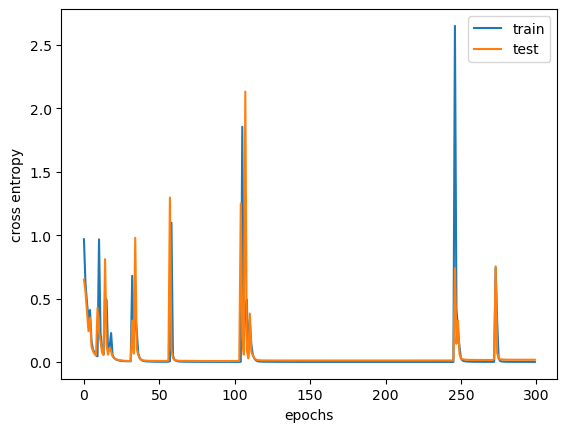

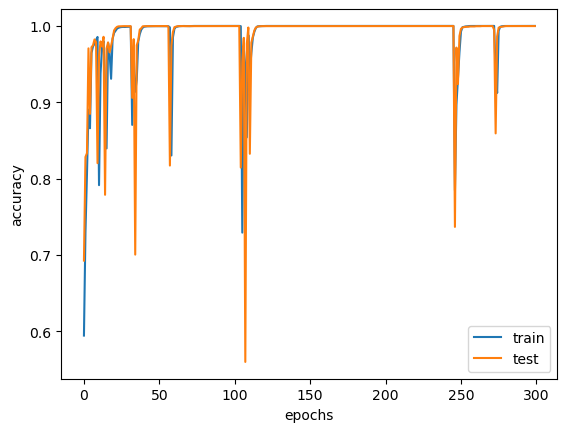

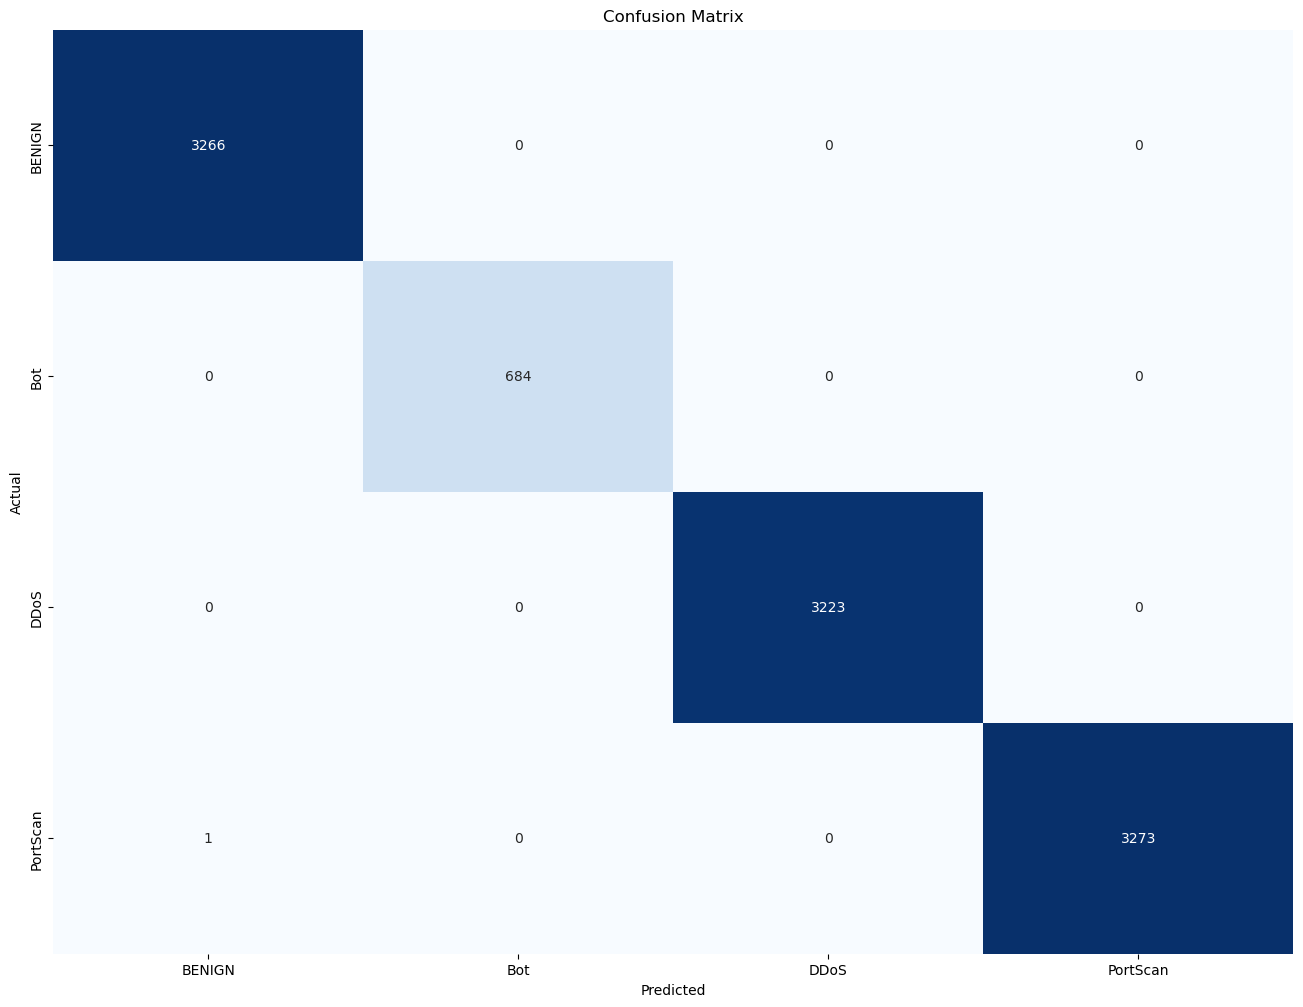

,precision,recall,f1-score,support
BENIGN,0.999694,1.000000,0.999847,3266.000000
Bot,1.000000,1.000000,1.000000,684.000000
DDoS,1.000000,1.000000,1.000000,3223.000000
PortScan,1.000000,0.999695,0.999847,3274.000000
accuracy,0.999904,0.999904,0.999904,0.999904
macro avg,0.999923,0.999924,0.999924,10447.000000
weighted avg,0.999904,0.999904,0.999904,10447.000000


In [23]:
training_model(model=dnn_Mon_and_Fri, train_test=Mon_and_Fri)

### 凍結模型 1~6 層

Epoch 0 validation: Cross-entropy=0.80, Accuracy=56.0%
Epoch 1 validation: Cross-entropy=0.57, Accuracy=68.3%
Epoch 2 validation: Cross-entropy=0.52, Accuracy=72.6%
Epoch 3 validation: Cross-entropy=0.49, Accuracy=76.5%
Epoch 4 validation: Cross-entropy=0.47, Accuracy=80.2%
Epoch 5 validation: Cross-entropy=0.45, Accuracy=83.4%
Epoch 6 validation: Cross-entropy=0.44, Accuracy=86.5%
Epoch 7 validation: Cross-entropy=0.42, Accuracy=89.5%
Epoch 8 validation: Cross-entropy=0.41, Accuracy=90.9%
Epoch 9 validation: Cross-entropy=0.40, Accuracy=91.4%
Epoch 10 validation: Cross-entropy=0.39, Accuracy=91.9%
Epoch 11 validation: Cross-entropy=0.37, Accuracy=92.3%
Epoch 12 validation: Cross-entropy=0.36, Accuracy=92.5%
Epoch 13 validation: Cross-entropy=0.36, Accuracy=92.7%
Epoch 14 validation: Cross-entropy=0.35, Accuracy=92.9%
Epoch 15 validation: Cross-entropy=0.34, Accuracy=93.2%
Epoch 16 validation: Cross-entropy=0.33, Accuracy=93.4%
Epoch 17 validation: Cross-entropy=0.32, Accuracy=93.7%
Ep

Epoch 148 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 149 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 150 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 151 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 152 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 153 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 154 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 155 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 156 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 157 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 158 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 159 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 160 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 161 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 162 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 163 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 164 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 165 validation: Cross-ent

Epoch 297 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 298 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 299 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 300 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 301 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 302 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 303 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 304 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 305 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 306 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 307 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 308 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 309 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 310 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 311 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 312 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 313 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 314 validation: Cross-ent

Epoch 446 validation: Cross-entropy=0.04, Accuracy=99.3%
Epoch 447 validation: Cross-entropy=0.04, Accuracy=99.3%
Epoch 448 validation: Cross-entropy=0.04, Accuracy=99.3%
Epoch 449 validation: Cross-entropy=0.04, Accuracy=99.3%
Epoch 450 validation: Cross-entropy=0.04, Accuracy=99.3%
Epoch 451 validation: Cross-entropy=0.04, Accuracy=99.3%
Epoch 452 validation: Cross-entropy=0.04, Accuracy=99.3%
Epoch 453 validation: Cross-entropy=0.04, Accuracy=99.3%
Epoch 454 validation: Cross-entropy=0.04, Accuracy=99.3%
Epoch 455 validation: Cross-entropy=0.03, Accuracy=99.3%
Epoch 456 validation: Cross-entropy=0.03, Accuracy=99.3%
Epoch 457 validation: Cross-entropy=0.03, Accuracy=99.3%
Epoch 458 validation: Cross-entropy=0.03, Accuracy=99.3%
Epoch 459 validation: Cross-entropy=0.03, Accuracy=99.3%
Epoch 460 validation: Cross-entropy=0.03, Accuracy=99.3%
Epoch 461 validation: Cross-entropy=0.03, Accuracy=99.3%
Epoch 462 validation: Cross-entropy=0.03, Accuracy=99.3%
Epoch 463 validation: Cross-ent

Epoch 595 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 596 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 597 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 598 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 599 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 600 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 601 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 602 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 603 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 604 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 605 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 606 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 607 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 608 validation: Cross-entropy=0.03, Accuracy=99.6%
Epoch 609 validation: Cross-entropy=0.03, Accuracy=99.6%
Epoch 610 validation: Cross-entropy=0.03, Accuracy=99.6%
Epoch 611 validation: Cross-entropy=0.03, Accuracy=99.6%
Epoch 612 validation: Cross-ent

Epoch 746 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 747 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 748 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 749 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 750 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 751 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 752 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 753 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 754 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 755 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 756 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 757 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 758 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 759 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 760 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 761 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 762 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 763 validation: Cross-ent

Epoch 894 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 895 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 896 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 897 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 898 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 899 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 900 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 901 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 902 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 903 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 904 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 905 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 906 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 907 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 908 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 909 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 910 validation: Cross-entropy=0.02, Accuracy=99.8%
Epoch 911 validation: Cross-ent

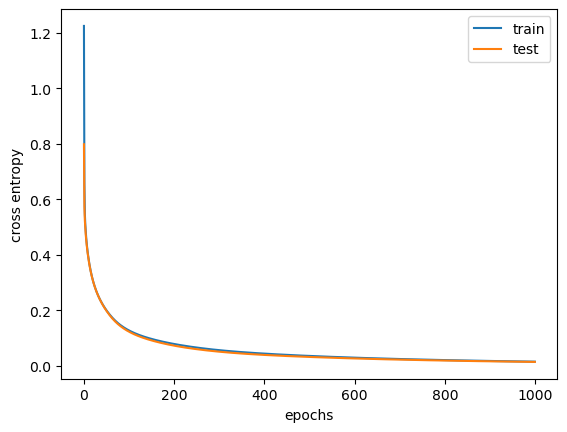

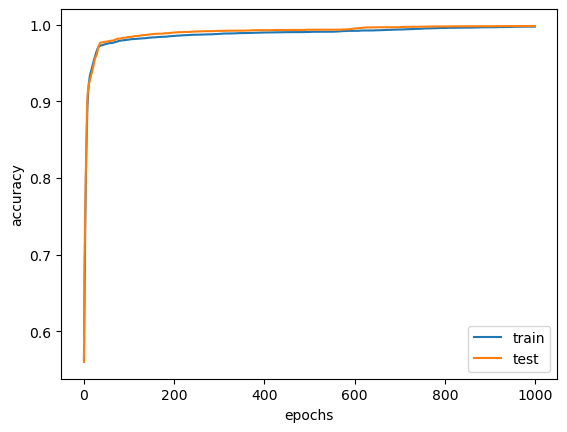

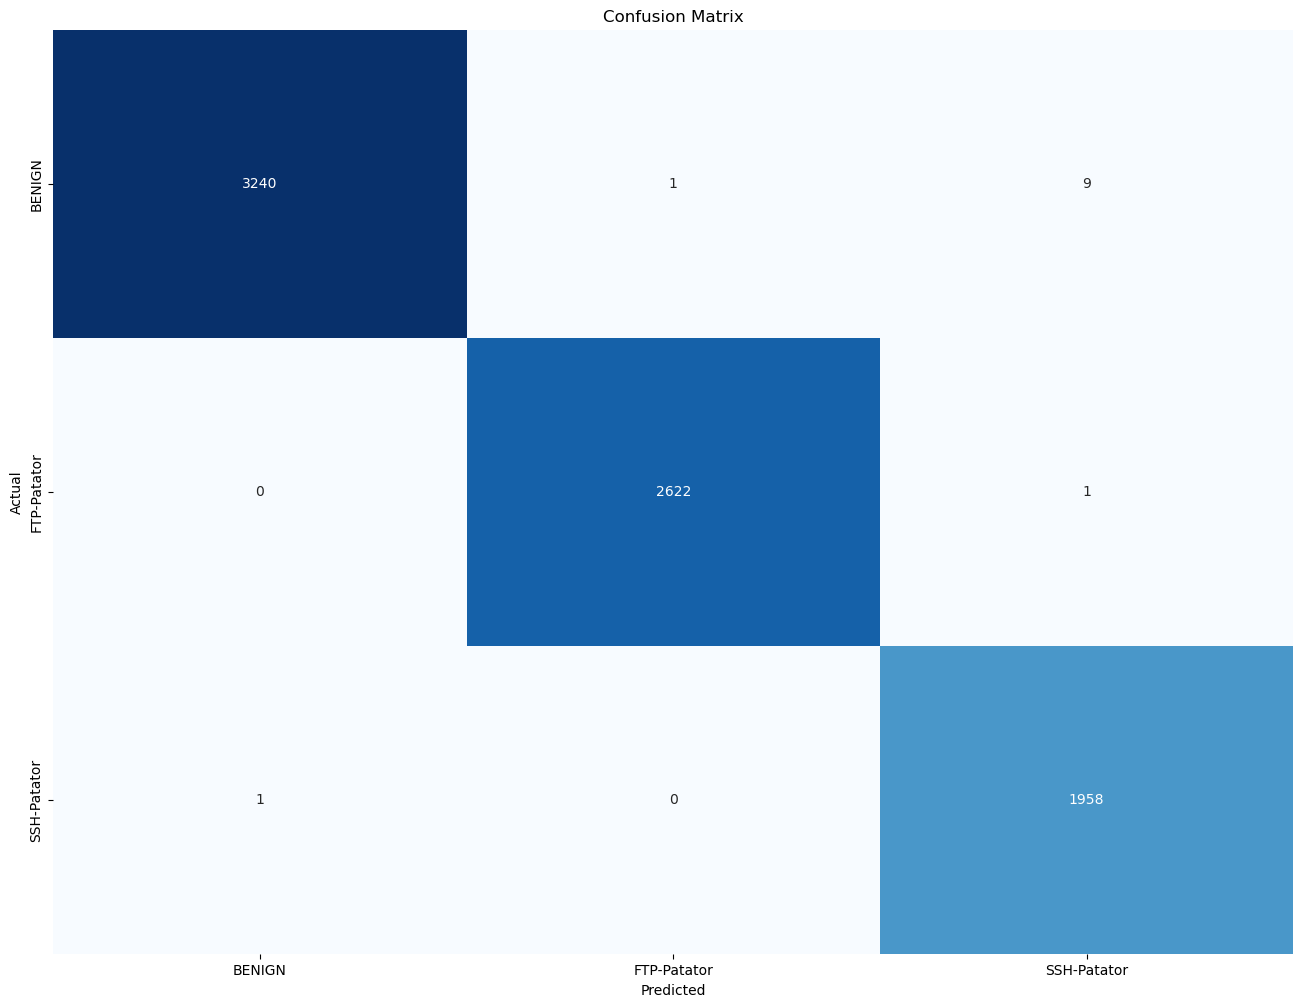

,precision,recall,f1-score,support
BENIGN,0.999691,0.996923,0.998305,3250.000000
FTP-Patator,0.999619,0.999619,0.999619,2623.000000
SSH-Patator,0.994919,0.999490,0.997199,1959.000000
accuracy,0.998468,0.998468,0.998468,0.998468
macro avg,0.998076,0.998677,0.998374,7832.000000
weighted avg,0.998473,0.998468,0.998468,7832.000000


Epoch 0 validation: Cross-entropy=1.36, Accuracy=42.2%
Epoch 1 validation: Cross-entropy=1.13, Accuracy=45.2%
Epoch 2 validation: Cross-entropy=1.09, Accuracy=48.9%
Epoch 3 validation: Cross-entropy=1.05, Accuracy=50.1%
Epoch 4 validation: Cross-entropy=1.03, Accuracy=51.3%
Epoch 5 validation: Cross-entropy=1.00, Accuracy=53.3%
Epoch 6 validation: Cross-entropy=0.98, Accuracy=56.1%
Epoch 7 validation: Cross-entropy=0.96, Accuracy=58.3%
Epoch 8 validation: Cross-entropy=0.94, Accuracy=60.1%
Epoch 9 validation: Cross-entropy=0.93, Accuracy=62.1%
Epoch 10 validation: Cross-entropy=0.91, Accuracy=63.9%
Epoch 11 validation: Cross-entropy=0.89, Accuracy=65.5%
Epoch 12 validation: Cross-entropy=0.88, Accuracy=66.6%
Epoch 13 validation: Cross-entropy=0.87, Accuracy=68.0%
Epoch 14 validation: Cross-entropy=0.85, Accuracy=69.4%
Epoch 15 validation: Cross-entropy=0.84, Accuracy=70.8%
Epoch 16 validation: Cross-entropy=0.83, Accuracy=71.8%
Epoch 17 validation: Cross-entropy=0.81, Accuracy=72.4%
Ep

Epoch 151 validation: Cross-entropy=0.38, Accuracy=88.4%
Epoch 152 validation: Cross-entropy=0.38, Accuracy=88.5%
Epoch 153 validation: Cross-entropy=0.38, Accuracy=88.5%
Epoch 154 validation: Cross-entropy=0.38, Accuracy=88.6%
Epoch 155 validation: Cross-entropy=0.38, Accuracy=88.6%
Epoch 156 validation: Cross-entropy=0.38, Accuracy=88.7%
Epoch 157 validation: Cross-entropy=0.38, Accuracy=88.8%
Epoch 158 validation: Cross-entropy=0.38, Accuracy=88.8%
Epoch 159 validation: Cross-entropy=0.38, Accuracy=88.9%
Epoch 160 validation: Cross-entropy=0.37, Accuracy=89.0%
Epoch 161 validation: Cross-entropy=0.37, Accuracy=89.0%
Epoch 162 validation: Cross-entropy=0.37, Accuracy=89.1%
Epoch 163 validation: Cross-entropy=0.37, Accuracy=89.1%
Epoch 164 validation: Cross-entropy=0.37, Accuracy=89.1%
Epoch 165 validation: Cross-entropy=0.37, Accuracy=89.2%
Epoch 166 validation: Cross-entropy=0.37, Accuracy=89.3%
Epoch 167 validation: Cross-entropy=0.37, Accuracy=89.3%
Epoch 168 validation: Cross-ent

Epoch 295 validation: Cross-entropy=0.28, Accuracy=91.9%
Epoch 296 validation: Cross-entropy=0.28, Accuracy=91.9%
Epoch 297 validation: Cross-entropy=0.28, Accuracy=91.9%
Epoch 298 validation: Cross-entropy=0.28, Accuracy=91.9%
Epoch 299 validation: Cross-entropy=0.28, Accuracy=92.0%
Epoch 300 validation: Cross-entropy=0.28, Accuracy=92.0%
Epoch 301 validation: Cross-entropy=0.28, Accuracy=92.0%
Epoch 302 validation: Cross-entropy=0.28, Accuracy=92.0%
Epoch 303 validation: Cross-entropy=0.28, Accuracy=92.0%
Epoch 304 validation: Cross-entropy=0.28, Accuracy=92.0%
Epoch 305 validation: Cross-entropy=0.28, Accuracy=92.1%
Epoch 306 validation: Cross-entropy=0.27, Accuracy=92.1%
Epoch 307 validation: Cross-entropy=0.27, Accuracy=92.1%
Epoch 308 validation: Cross-entropy=0.27, Accuracy=92.1%
Epoch 309 validation: Cross-entropy=0.27, Accuracy=92.1%
Epoch 310 validation: Cross-entropy=0.27, Accuracy=92.1%
Epoch 311 validation: Cross-entropy=0.27, Accuracy=92.1%
Epoch 312 validation: Cross-ent

Epoch 439 validation: Cross-entropy=0.22, Accuracy=93.7%
Epoch 440 validation: Cross-entropy=0.22, Accuracy=93.7%
Epoch 441 validation: Cross-entropy=0.22, Accuracy=93.7%
Epoch 442 validation: Cross-entropy=0.22, Accuracy=93.7%
Epoch 443 validation: Cross-entropy=0.22, Accuracy=93.8%
Epoch 444 validation: Cross-entropy=0.22, Accuracy=93.8%
Epoch 445 validation: Cross-entropy=0.22, Accuracy=93.8%
Epoch 446 validation: Cross-entropy=0.22, Accuracy=93.8%
Epoch 447 validation: Cross-entropy=0.22, Accuracy=93.8%
Epoch 448 validation: Cross-entropy=0.22, Accuracy=93.8%
Epoch 449 validation: Cross-entropy=0.22, Accuracy=93.8%
Epoch 450 validation: Cross-entropy=0.22, Accuracy=93.9%
Epoch 451 validation: Cross-entropy=0.22, Accuracy=93.9%
Epoch 452 validation: Cross-entropy=0.22, Accuracy=93.9%
Epoch 453 validation: Cross-entropy=0.22, Accuracy=93.9%
Epoch 454 validation: Cross-entropy=0.22, Accuracy=93.9%
Epoch 455 validation: Cross-entropy=0.22, Accuracy=93.9%
Epoch 456 validation: Cross-ent

Epoch 583 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 584 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 585 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 586 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 587 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 588 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 589 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 590 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 591 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 592 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 593 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 594 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 595 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 596 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 597 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 598 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 599 validation: Cross-entropy=0.18, Accuracy=94.8%
Epoch 600 validation: Cross-ent

Epoch 727 validation: Cross-entropy=0.16, Accuracy=95.3%
Epoch 728 validation: Cross-entropy=0.16, Accuracy=95.3%
Epoch 729 validation: Cross-entropy=0.16, Accuracy=95.3%
Epoch 730 validation: Cross-entropy=0.16, Accuracy=95.3%
Epoch 731 validation: Cross-entropy=0.16, Accuracy=95.3%
Epoch 732 validation: Cross-entropy=0.16, Accuracy=95.3%
Epoch 733 validation: Cross-entropy=0.16, Accuracy=95.3%
Epoch 734 validation: Cross-entropy=0.16, Accuracy=95.3%
Epoch 735 validation: Cross-entropy=0.16, Accuracy=95.3%
Epoch 736 validation: Cross-entropy=0.15, Accuracy=95.4%
Epoch 737 validation: Cross-entropy=0.15, Accuracy=95.4%
Epoch 738 validation: Cross-entropy=0.15, Accuracy=95.4%
Epoch 739 validation: Cross-entropy=0.15, Accuracy=95.4%
Epoch 740 validation: Cross-entropy=0.15, Accuracy=95.4%
Epoch 741 validation: Cross-entropy=0.15, Accuracy=95.4%
Epoch 742 validation: Cross-entropy=0.15, Accuracy=95.4%
Epoch 743 validation: Cross-entropy=0.15, Accuracy=95.4%
Epoch 744 validation: Cross-ent

Epoch 878 validation: Cross-entropy=0.13, Accuracy=96.2%
Epoch 879 validation: Cross-entropy=0.13, Accuracy=96.2%
Epoch 880 validation: Cross-entropy=0.13, Accuracy=96.2%
Epoch 881 validation: Cross-entropy=0.13, Accuracy=96.2%
Epoch 882 validation: Cross-entropy=0.13, Accuracy=96.2%
Epoch 883 validation: Cross-entropy=0.13, Accuracy=96.3%
Epoch 884 validation: Cross-entropy=0.13, Accuracy=96.3%
Epoch 885 validation: Cross-entropy=0.13, Accuracy=96.3%
Epoch 886 validation: Cross-entropy=0.13, Accuracy=96.3%
Epoch 887 validation: Cross-entropy=0.13, Accuracy=96.3%
Epoch 888 validation: Cross-entropy=0.13, Accuracy=96.3%
Epoch 889 validation: Cross-entropy=0.13, Accuracy=96.3%
Epoch 890 validation: Cross-entropy=0.13, Accuracy=96.3%
Epoch 891 validation: Cross-entropy=0.13, Accuracy=96.3%
Epoch 892 validation: Cross-entropy=0.13, Accuracy=96.3%
Epoch 893 validation: Cross-entropy=0.13, Accuracy=96.3%
Epoch 894 validation: Cross-entropy=0.13, Accuracy=96.3%
Epoch 895 validation: Cross-ent

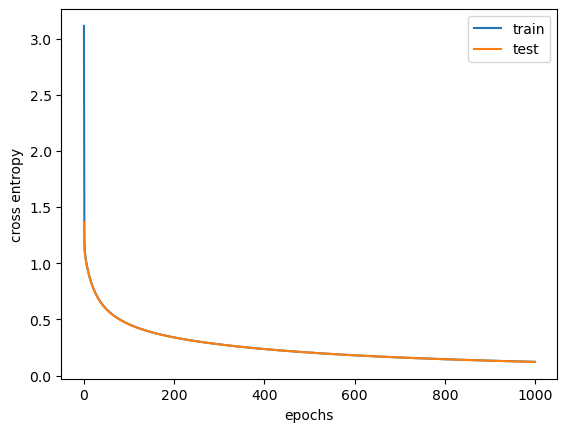

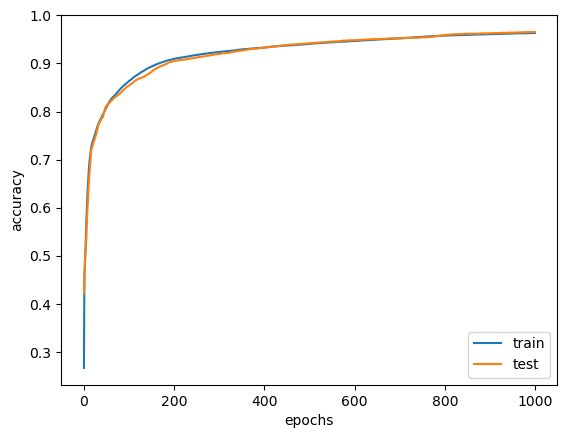

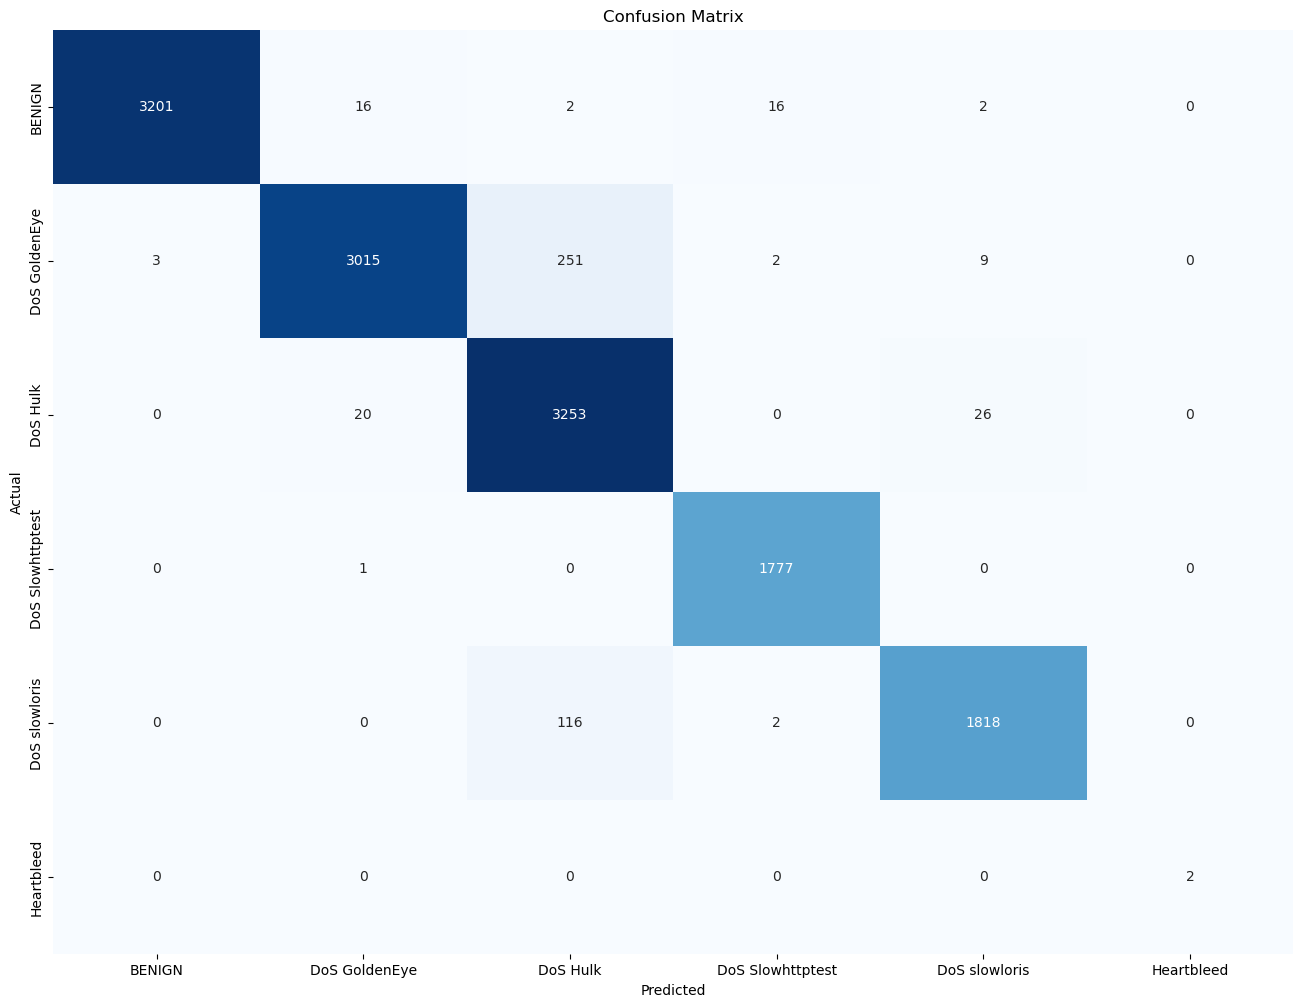

,precision,recall,f1-score,support
BENIGN,0.999064,0.988879,0.993945,3237.000000
DoS GoldenEye,0.987877,0.919207,0.952306,3280.000000
DoS Hulk,0.898123,0.986056,0.940038,3299.000000
DoS Slowhttptest,0.988870,0.999438,0.994126,1778.000000
DoS slowloris,0.980054,0.939050,0.959114,1936.000000
Heartbleed,1.000000,1.000000,1.000000,2.000000
accuracy,0.965563,0.965563,0.965563,0.965563
macro avg,0.975665,0.972105,0.973255,13532.000000
weighted avg,0.967685,0.965563,0.965751,13532.000000


Epoch 0 validation: Cross-entropy=1.80, Accuracy=7.7%
Epoch 1 validation: Cross-entropy=0.37, Accuracy=90.5%
Epoch 2 validation: Cross-entropy=0.30, Accuracy=91.1%
Epoch 3 validation: Cross-entropy=0.27, Accuracy=91.7%
Epoch 4 validation: Cross-entropy=0.26, Accuracy=92.1%
Epoch 5 validation: Cross-entropy=0.24, Accuracy=92.2%
Epoch 6 validation: Cross-entropy=0.23, Accuracy=92.4%
Epoch 7 validation: Cross-entropy=0.23, Accuracy=92.4%
Epoch 8 validation: Cross-entropy=0.22, Accuracy=92.5%
Epoch 9 validation: Cross-entropy=0.21, Accuracy=92.7%
Epoch 10 validation: Cross-entropy=0.21, Accuracy=92.8%
Epoch 11 validation: Cross-entropy=0.20, Accuracy=92.8%
Epoch 12 validation: Cross-entropy=0.20, Accuracy=92.9%
Epoch 13 validation: Cross-entropy=0.19, Accuracy=93.0%
Epoch 14 validation: Cross-entropy=0.19, Accuracy=93.1%
Epoch 15 validation: Cross-entropy=0.19, Accuracy=93.1%
Epoch 16 validation: Cross-entropy=0.18, Accuracy=93.1%
Epoch 17 validation: Cross-entropy=0.18, Accuracy=93.3%
Epo

Epoch 153 validation: Cross-entropy=0.09, Accuracy=95.9%
Epoch 154 validation: Cross-entropy=0.09, Accuracy=95.9%
Epoch 155 validation: Cross-entropy=0.09, Accuracy=95.9%
Epoch 156 validation: Cross-entropy=0.09, Accuracy=95.9%
Epoch 157 validation: Cross-entropy=0.09, Accuracy=95.9%
Epoch 158 validation: Cross-entropy=0.09, Accuracy=95.9%
Epoch 159 validation: Cross-entropy=0.09, Accuracy=96.0%
Epoch 160 validation: Cross-entropy=0.09, Accuracy=96.0%
Epoch 161 validation: Cross-entropy=0.09, Accuracy=96.0%
Epoch 162 validation: Cross-entropy=0.09, Accuracy=96.0%
Epoch 163 validation: Cross-entropy=0.09, Accuracy=96.0%
Epoch 164 validation: Cross-entropy=0.09, Accuracy=96.0%
Epoch 165 validation: Cross-entropy=0.09, Accuracy=96.1%
Epoch 166 validation: Cross-entropy=0.09, Accuracy=96.1%
Epoch 167 validation: Cross-entropy=0.09, Accuracy=96.1%
Epoch 168 validation: Cross-entropy=0.09, Accuracy=96.1%
Epoch 169 validation: Cross-entropy=0.09, Accuracy=96.1%
Epoch 170 validation: Cross-ent

Epoch 309 validation: Cross-entropy=0.07, Accuracy=96.6%
Epoch 310 validation: Cross-entropy=0.07, Accuracy=96.6%
Epoch 311 validation: Cross-entropy=0.07, Accuracy=96.7%
Epoch 312 validation: Cross-entropy=0.07, Accuracy=96.7%
Epoch 313 validation: Cross-entropy=0.07, Accuracy=96.7%
Epoch 314 validation: Cross-entropy=0.07, Accuracy=96.7%
Epoch 315 validation: Cross-entropy=0.07, Accuracy=96.7%
Epoch 316 validation: Cross-entropy=0.07, Accuracy=96.7%
Epoch 317 validation: Cross-entropy=0.07, Accuracy=96.7%
Epoch 318 validation: Cross-entropy=0.07, Accuracy=96.7%
Epoch 319 validation: Cross-entropy=0.07, Accuracy=96.7%
Epoch 320 validation: Cross-entropy=0.07, Accuracy=96.7%
Epoch 321 validation: Cross-entropy=0.07, Accuracy=96.7%
Epoch 322 validation: Cross-entropy=0.07, Accuracy=96.7%
Epoch 323 validation: Cross-entropy=0.07, Accuracy=96.7%
Epoch 324 validation: Cross-entropy=0.07, Accuracy=96.7%
Epoch 325 validation: Cross-entropy=0.07, Accuracy=96.7%
Epoch 326 validation: Cross-ent

Epoch 466 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 467 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 468 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 469 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 470 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 471 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 472 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 473 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 474 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 475 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 476 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 477 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 478 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 479 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 480 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 481 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 482 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 483 validation: Cross-ent

Epoch 621 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 622 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 623 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 624 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 625 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 626 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 627 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 628 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 629 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 630 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 631 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 632 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 633 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 634 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 635 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 636 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 637 validation: Cross-entropy=0.05, Accuracy=98.2%
Epoch 638 validation: Cross-ent

Epoch 779 validation: Cross-entropy=0.05, Accuracy=98.7%
Epoch 780 validation: Cross-entropy=0.05, Accuracy=98.7%
Epoch 781 validation: Cross-entropy=0.05, Accuracy=98.7%
Epoch 782 validation: Cross-entropy=0.05, Accuracy=98.7%
Epoch 783 validation: Cross-entropy=0.05, Accuracy=98.7%
Epoch 784 validation: Cross-entropy=0.04, Accuracy=98.7%
Epoch 785 validation: Cross-entropy=0.04, Accuracy=98.7%
Epoch 786 validation: Cross-entropy=0.04, Accuracy=98.7%
Epoch 787 validation: Cross-entropy=0.04, Accuracy=98.7%
Epoch 788 validation: Cross-entropy=0.04, Accuracy=98.7%
Epoch 789 validation: Cross-entropy=0.04, Accuracy=98.7%
Epoch 790 validation: Cross-entropy=0.04, Accuracy=98.7%
Epoch 791 validation: Cross-entropy=0.04, Accuracy=98.7%
Epoch 792 validation: Cross-entropy=0.04, Accuracy=98.7%
Epoch 793 validation: Cross-entropy=0.04, Accuracy=98.7%
Epoch 794 validation: Cross-entropy=0.04, Accuracy=98.7%
Epoch 795 validation: Cross-entropy=0.04, Accuracy=98.7%
Epoch 796 validation: Cross-ent

Epoch 939 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 940 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 941 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 942 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 943 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 944 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 945 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 946 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 947 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 948 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 949 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 950 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 951 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 952 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 953 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 954 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 955 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 956 validation: Cross-ent

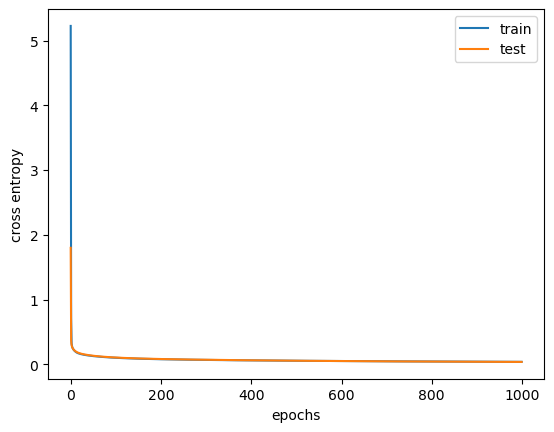

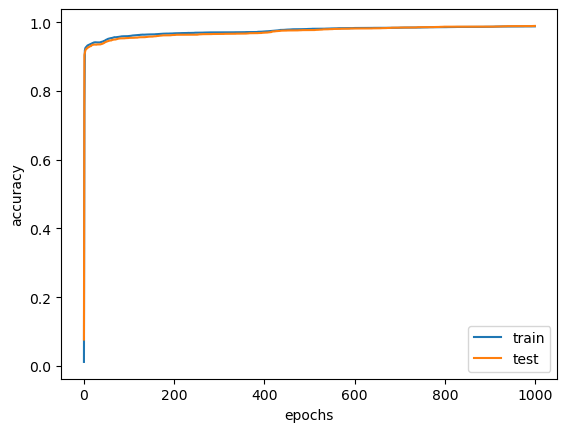

/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.draw()
/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


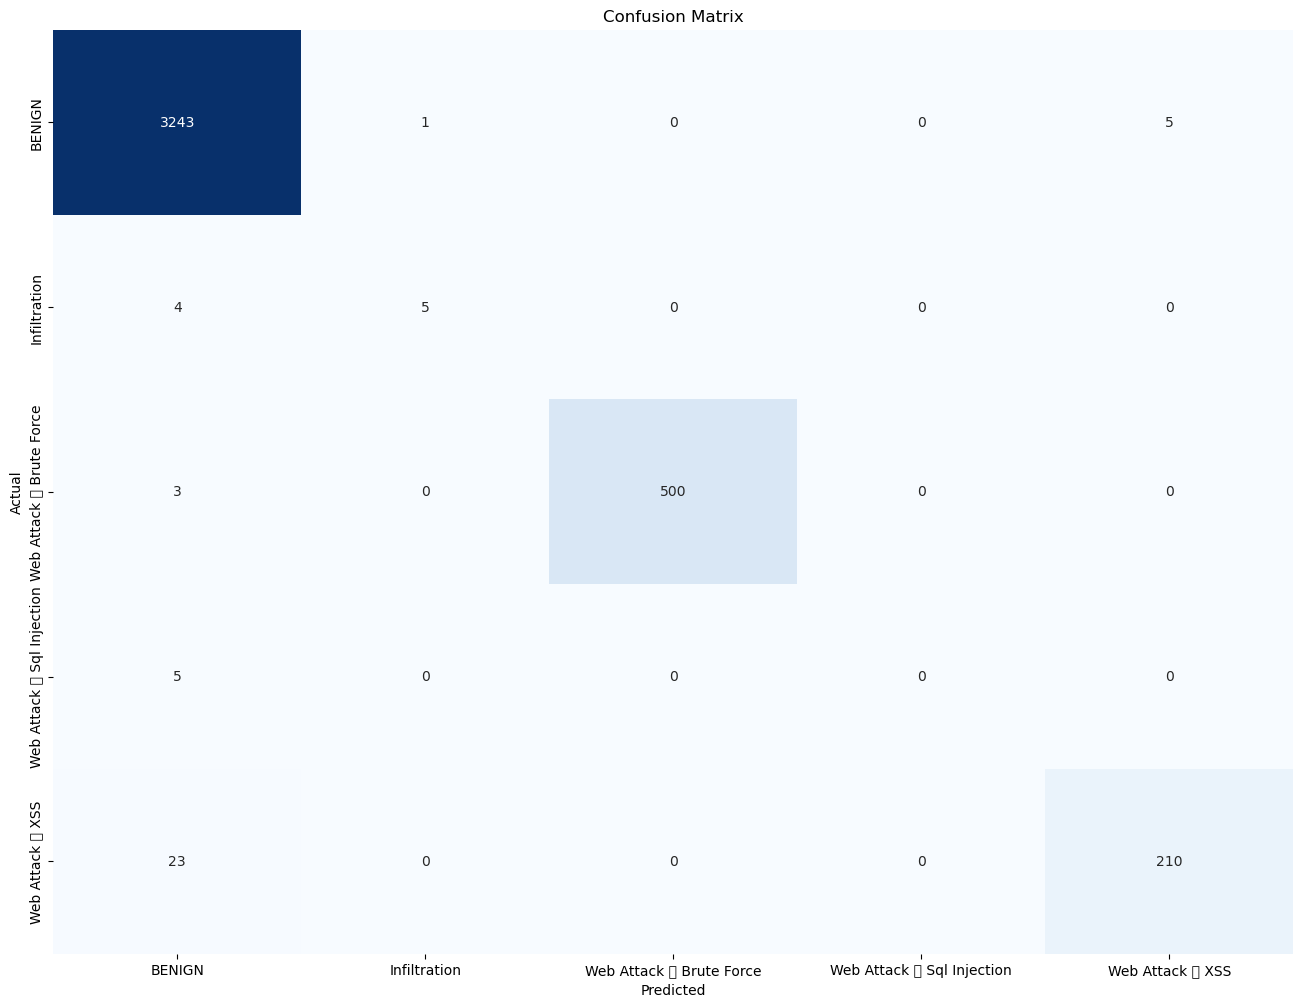

/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
BENIGN,0.989323,0.998153,0.993718,3249.000000
Infiltration,0.833333,0.555556,0.666667,9.000000
Web Attack  Brute Force,1.000000,0.994036,0.997009,503.000000
Web Attack  Sql Injection,0.000000,0.000000,0.000000,5.000000
Web Attack  XSS,0.976744,0.901288,0.937500,233.000000
accuracy,0.989747,0.989747,0.989747,0.989747
macro avg,0.759880,0.689806,0.718979,3999.000000
weighted avg,0.988345,0.989747,0.988878,3999.000000


In [24]:
# Tuesday
freezed_Tue = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Tue.hidden1.parameters():
    param.requires_grad = False
for param in freezed_Tue.hidden2.parameters():
    param.requires_grad = False
for param in freezed_Tue.hidden3.parameters():
    param.requires_grad = False
for param in freezed_Tue.hidden4.parameters():
    param.requires_grad = False
for param in freezed_Tue.hidden5.parameters():
    param.requires_grad = False
for param in freezed_Tue.hidden6.parameters():
    param.requires_grad = False
freezed_Tue.output = nn.Linear(500, len(Tue.categories_as_list)).to(DEVICE)
training_model(model=freezed_Tue, train_test=Tue, n_epochs=1000)

# Wendsday
freezed_Wed = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Wed.hidden1.parameters():
    param.requires_grad = False
for param in freezed_Wed.hidden2.parameters():
    param.requires_grad = False
for param in freezed_Wed.hidden3.parameters():
    param.requires_grad = False
for param in freezed_Wed.hidden4.parameters():
    param.requires_grad = False
for param in freezed_Wed.hidden5.parameters():
    param.requires_grad = False
for param in freezed_Wed.hidden6.parameters():
    param.requires_grad = False
freezed_Wed.output = nn.Linear(500, len(Wed.categories_as_list)).to(DEVICE)
training_model(model=freezed_Wed, train_test=Wed, n_epochs=1000)

# Thursday
freezed_Thu = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Thu.hidden1.parameters():
    param.requires_grad = False
for param in freezed_Thu.hidden2.parameters():
    param.requires_grad = False
for param in freezed_Thu.hidden3.parameters():
    param.requires_grad = False
for param in freezed_Thu.hidden4.parameters():
    param.requires_grad = False
for param in freezed_Thu.hidden5.parameters():
    param.requires_grad = False
for param in freezed_Thu.hidden6.parameters():
    param.requires_grad = False
freezed_Thu.output = nn.Linear(500, len(Thu.categories_as_list)).to(DEVICE)
training_model(model=freezed_Thu, train_test=Thu, n_epochs=1000)

### 凍結模型 1~5 層

Epoch 0 validation: Cross-entropy=0.45, Accuracy=79.9%
Epoch 1 validation: Cross-entropy=0.33, Accuracy=93.4%
Epoch 2 validation: Cross-entropy=0.27, Accuracy=94.6%
Epoch 3 validation: Cross-entropy=0.23, Accuracy=95.7%
Epoch 4 validation: Cross-entropy=0.20, Accuracy=96.8%
Epoch 5 validation: Cross-entropy=0.17, Accuracy=97.8%
Epoch 6 validation: Cross-entropy=0.16, Accuracy=98.3%
Epoch 7 validation: Cross-entropy=0.14, Accuracy=98.5%
Epoch 8 validation: Cross-entropy=0.13, Accuracy=98.6%
Epoch 9 validation: Cross-entropy=0.12, Accuracy=98.7%
Epoch 10 validation: Cross-entropy=0.11, Accuracy=98.8%
Epoch 11 validation: Cross-entropy=0.10, Accuracy=98.9%
Epoch 12 validation: Cross-entropy=0.10, Accuracy=98.9%
Epoch 13 validation: Cross-entropy=0.09, Accuracy=98.9%
Epoch 14 validation: Cross-entropy=0.09, Accuracy=98.9%
Epoch 15 validation: Cross-entropy=0.08, Accuracy=99.0%
Epoch 16 validation: Cross-entropy=0.08, Accuracy=99.0%
Epoch 17 validation: Cross-entropy=0.08, Accuracy=99.0%
Ep

Epoch 150 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 151 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 152 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 153 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 154 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 155 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 156 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 157 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 158 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 159 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 160 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 161 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 162 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 163 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 164 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 165 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 166 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 167 validation: Cross-ent

Epoch 300 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 301 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 302 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 303 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 304 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 305 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 306 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 307 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 308 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 309 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 310 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 311 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 312 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 313 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 314 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 315 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 316 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 317 vali

Epoch 450 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 451 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 452 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 453 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 454 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 455 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 456 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 457 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 458 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 459 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 460 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 461 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 462 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 463 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 464 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 465 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 466 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 467 vali

Epoch 600 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 601 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 602 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 603 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 604 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 605 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 606 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 607 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 608 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 609 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 610 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 611 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 612 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 613 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 614 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 615 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 616 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 617 vali

Epoch 750 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 751 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 752 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 753 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 754 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 755 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 756 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 757 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 758 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 759 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 760 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 761 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 762 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 763 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 764 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 765 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 766 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 767 vali

Epoch 900 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 901 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 902 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 903 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 904 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 905 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 906 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 907 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 908 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 909 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 910 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 911 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 912 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 913 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 914 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 915 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 916 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 917 vali

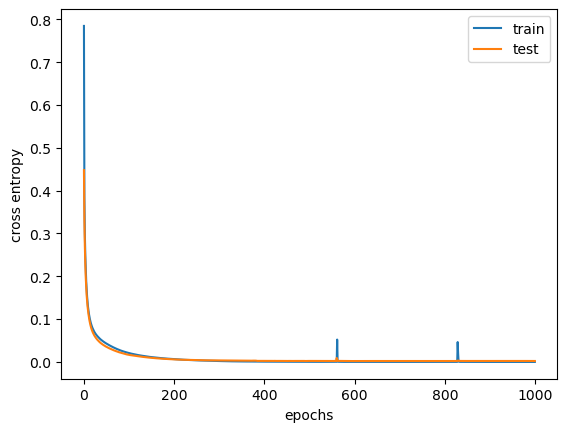

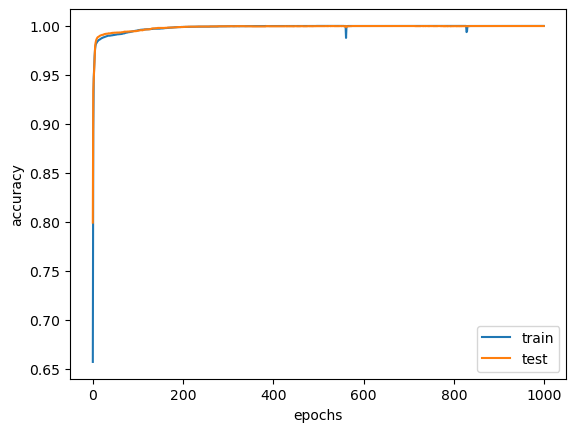

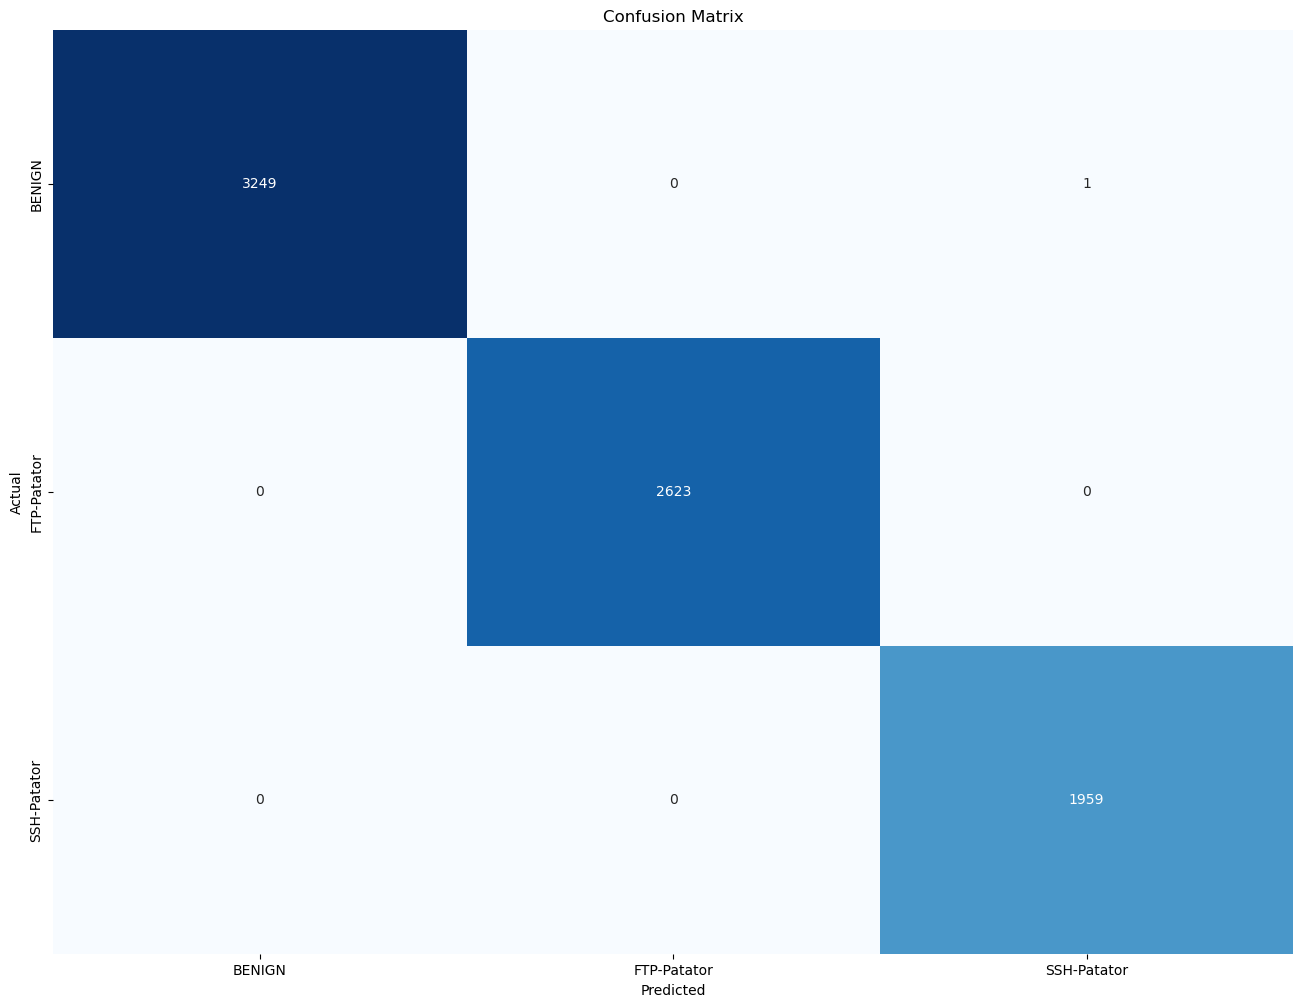

,precision,recall,f1-score,support
BENIGN,1.000000,0.999692,0.999846,3250.000000
FTP-Patator,1.000000,1.000000,1.000000,2623.000000
SSH-Patator,0.999490,1.000000,0.999745,1959.000000
accuracy,0.999872,0.999872,0.999872,0.999872
macro avg,0.999830,0.999897,0.999864,7832.000000
weighted avg,0.999872,0.999872,0.999872,7832.000000


Epoch 0 validation: Cross-entropy=0.94, Accuracy=61.0%
Epoch 1 validation: Cross-entropy=0.84, Accuracy=69.1%
Epoch 2 validation: Cross-entropy=0.77, Accuracy=71.8%
Epoch 3 validation: Cross-entropy=0.71, Accuracy=75.0%
Epoch 4 validation: Cross-entropy=0.67, Accuracy=78.1%
Epoch 5 validation: Cross-entropy=0.63, Accuracy=79.8%
Epoch 6 validation: Cross-entropy=0.59, Accuracy=82.8%
Epoch 7 validation: Cross-entropy=0.56, Accuracy=84.1%
Epoch 8 validation: Cross-entropy=0.53, Accuracy=85.0%
Epoch 9 validation: Cross-entropy=0.51, Accuracy=85.8%
Epoch 10 validation: Cross-entropy=0.49, Accuracy=86.9%
Epoch 11 validation: Cross-entropy=0.47, Accuracy=87.5%
Epoch 12 validation: Cross-entropy=0.45, Accuracy=88.0%
Epoch 13 validation: Cross-entropy=0.43, Accuracy=88.5%
Epoch 14 validation: Cross-entropy=0.41, Accuracy=88.8%
Epoch 15 validation: Cross-entropy=0.40, Accuracy=89.1%
Epoch 16 validation: Cross-entropy=0.38, Accuracy=89.3%
Epoch 17 validation: Cross-entropy=0.37, Accuracy=89.8%
Ep

Epoch 150 validation: Cross-entropy=0.04, Accuracy=99.0%
Epoch 151 validation: Cross-entropy=0.04, Accuracy=99.0%
Epoch 152 validation: Cross-entropy=0.04, Accuracy=99.0%
Epoch 153 validation: Cross-entropy=0.04, Accuracy=99.0%
Epoch 154 validation: Cross-entropy=0.04, Accuracy=99.0%
Epoch 155 validation: Cross-entropy=0.04, Accuracy=99.1%
Epoch 156 validation: Cross-entropy=0.04, Accuracy=99.1%
Epoch 157 validation: Cross-entropy=0.04, Accuracy=99.1%
Epoch 158 validation: Cross-entropy=0.04, Accuracy=99.1%
Epoch 159 validation: Cross-entropy=0.04, Accuracy=99.1%
Epoch 160 validation: Cross-entropy=0.04, Accuracy=99.1%
Epoch 161 validation: Cross-entropy=0.04, Accuracy=99.1%
Epoch 162 validation: Cross-entropy=0.04, Accuracy=99.1%
Epoch 163 validation: Cross-entropy=0.04, Accuracy=99.2%
Epoch 164 validation: Cross-entropy=0.04, Accuracy=99.1%
Epoch 165 validation: Cross-entropy=0.04, Accuracy=99.2%
Epoch 166 validation: Cross-entropy=0.04, Accuracy=99.2%
Epoch 167 validation: Cross-ent

Epoch 294 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 295 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 296 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 297 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 298 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 299 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 300 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 301 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 302 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 303 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 304 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 305 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 306 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 307 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 308 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 309 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 310 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 311 validation: Cross-ent

Epoch 438 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 439 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 440 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 441 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 442 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 443 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 444 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 445 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 446 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 447 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 448 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 449 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 450 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 451 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 452 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 453 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 454 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 455 validation: Cross-ent

Epoch 582 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 583 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 584 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 585 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 586 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 587 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 588 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 589 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 590 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 591 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 592 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 593 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 594 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 595 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 596 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 597 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 598 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 599 validation: Cross-ent

Epoch 726 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 727 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 728 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 729 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 730 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 731 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 732 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 733 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 734 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 735 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 736 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 737 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 738 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 739 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 740 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 741 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 742 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 743 validation: Cross-ent

Epoch 870 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 871 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 872 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 873 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 874 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 875 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 876 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 877 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 878 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 879 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 880 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 881 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 882 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 883 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 884 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 885 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 886 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 887 validation: Cross-ent

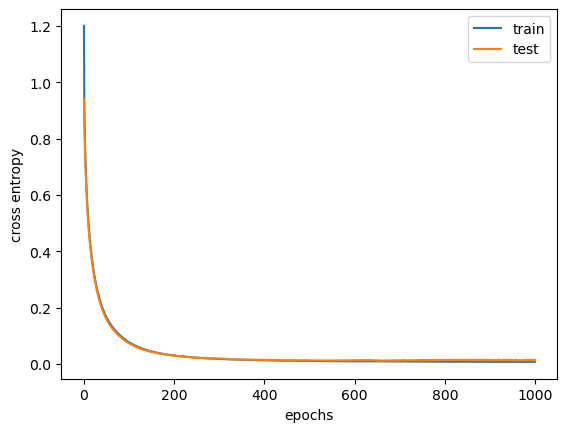

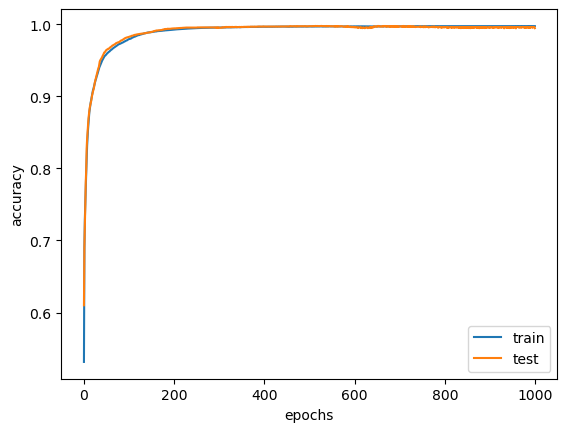

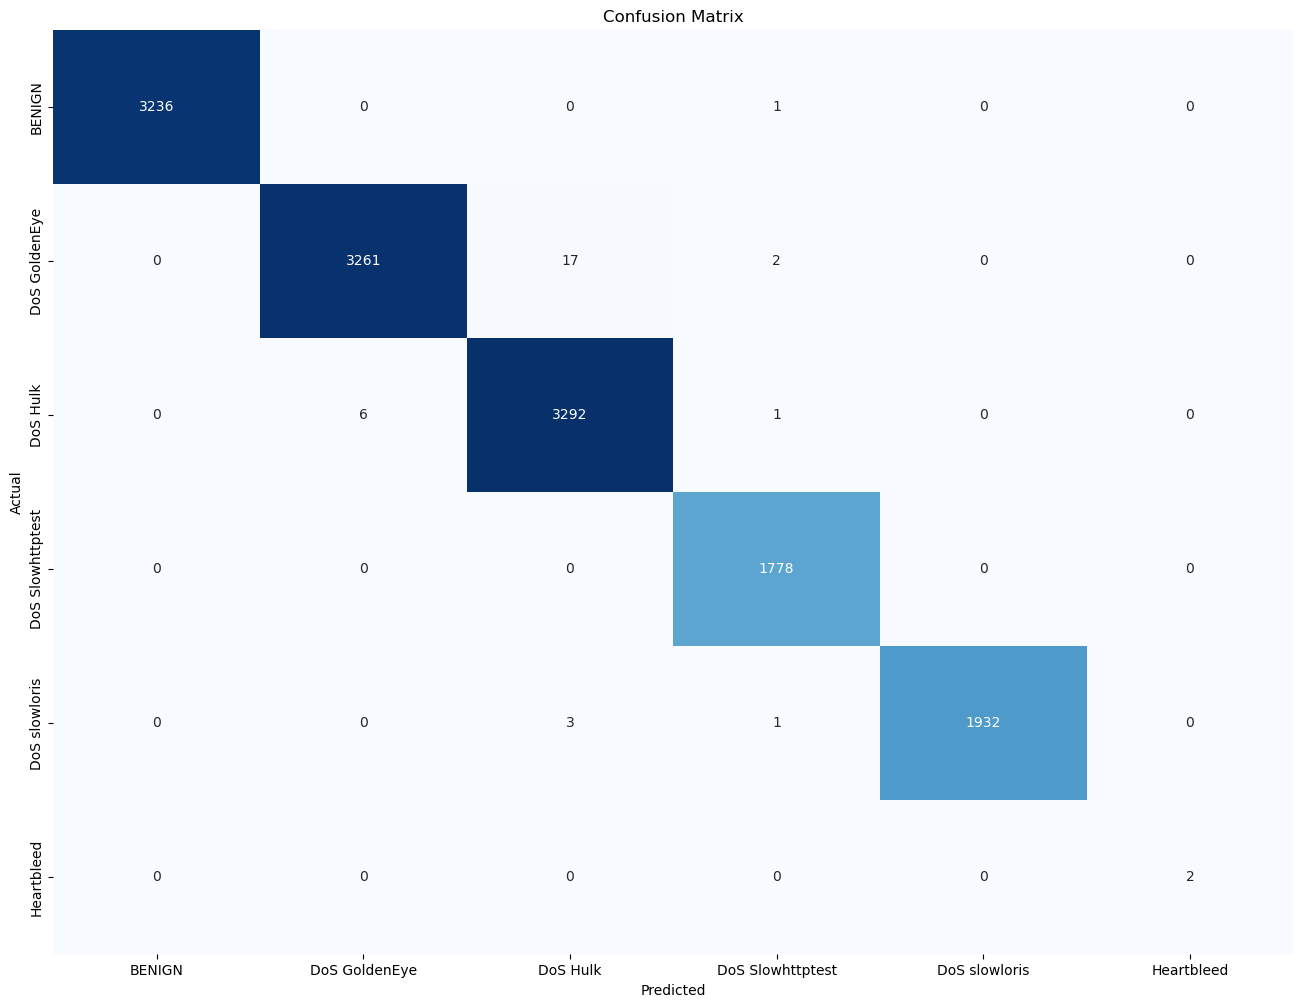

,precision,recall,f1-score,support
BENIGN,1.000000,0.999691,0.999846,3237.000000
DoS GoldenEye,0.998163,0.994207,0.996181,3280.000000
DoS Hulk,0.993961,0.997878,0.995916,3299.000000
DoS Slowhttptest,0.997196,1.000000,0.998596,1778.000000
DoS slowloris,1.000000,0.997934,0.998966,1936.000000
Heartbleed,1.000000,1.000000,1.000000,2.000000
accuracy,0.997709,0.997709,0.997709,0.997709
macro avg,0.998220,0.998285,0.998251,13532.000000
weighted avg,0.997714,0.997709,0.997709,13532.000000


Epoch 0 validation: Cross-entropy=0.67, Accuracy=82.6%
Epoch 1 validation: Cross-entropy=0.46, Accuracy=92.4%
Epoch 2 validation: Cross-entropy=0.34, Accuracy=93.1%
Epoch 3 validation: Cross-entropy=0.20, Accuracy=93.3%
Epoch 4 validation: Cross-entropy=0.18, Accuracy=92.9%
Epoch 5 validation: Cross-entropy=0.17, Accuracy=93.5%
Epoch 6 validation: Cross-entropy=0.16, Accuracy=93.4%
Epoch 7 validation: Cross-entropy=0.15, Accuracy=93.6%
Epoch 8 validation: Cross-entropy=0.15, Accuracy=93.6%
Epoch 9 validation: Cross-entropy=0.14, Accuracy=93.8%
Epoch 10 validation: Cross-entropy=0.14, Accuracy=94.2%
Epoch 11 validation: Cross-entropy=0.13, Accuracy=94.5%
Epoch 12 validation: Cross-entropy=0.13, Accuracy=94.7%
Epoch 13 validation: Cross-entropy=0.13, Accuracy=94.8%
Epoch 14 validation: Cross-entropy=0.12, Accuracy=95.1%
Epoch 15 validation: Cross-entropy=0.12, Accuracy=95.2%
Epoch 16 validation: Cross-entropy=0.12, Accuracy=95.4%
Epoch 17 validation: Cross-entropy=0.11, Accuracy=95.5%
Ep

Epoch 159 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 160 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 161 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 162 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 163 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 164 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 165 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 166 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 167 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 168 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 169 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 170 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 171 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 172 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 173 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 174 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 175 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 176 validation: Cross-ent

Epoch 319 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 320 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 321 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 322 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 323 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 324 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 325 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 326 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 327 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 328 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 329 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 330 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 331 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 332 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 333 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 334 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 335 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 336 validation: Cross-ent

Epoch 479 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 480 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 481 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 482 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 483 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 484 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 485 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 486 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 487 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 488 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 489 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 490 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 491 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 492 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 493 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 494 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 495 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 496 validation: Cross-ent

Epoch 639 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 640 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 641 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 642 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 643 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 644 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 645 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 646 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 647 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 648 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 649 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 650 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 651 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 652 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 653 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 654 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 655 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 656 validation: Cross-ent

Epoch 799 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 800 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 801 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 802 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 803 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 804 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 805 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 806 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 807 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 808 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 809 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 810 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 811 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 812 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 813 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 814 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 815 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 816 validation: Cross-ent

Epoch 959 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 960 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 961 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 962 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 963 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 964 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 965 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 966 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 967 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 968 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 969 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 970 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 971 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 972 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 973 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 974 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 975 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 976 validation: Cross-ent

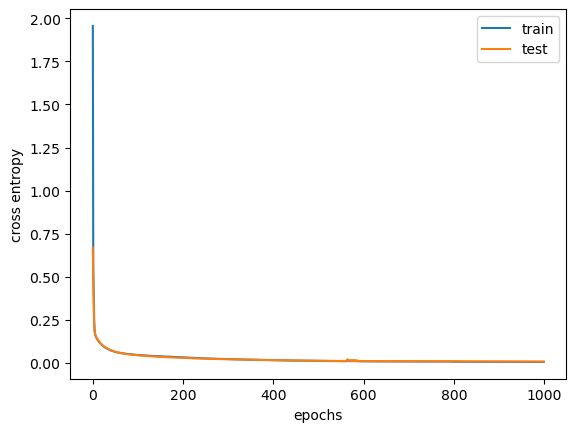

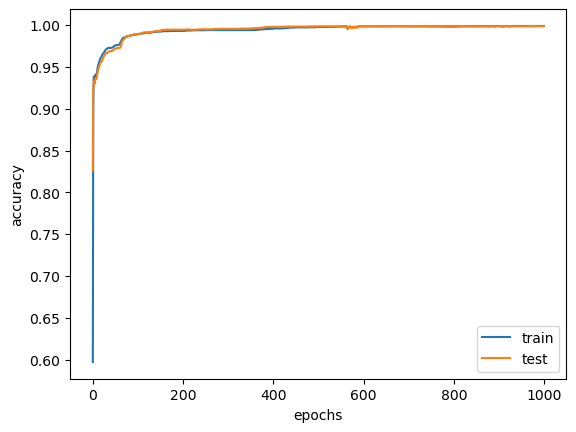

/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.draw()
/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


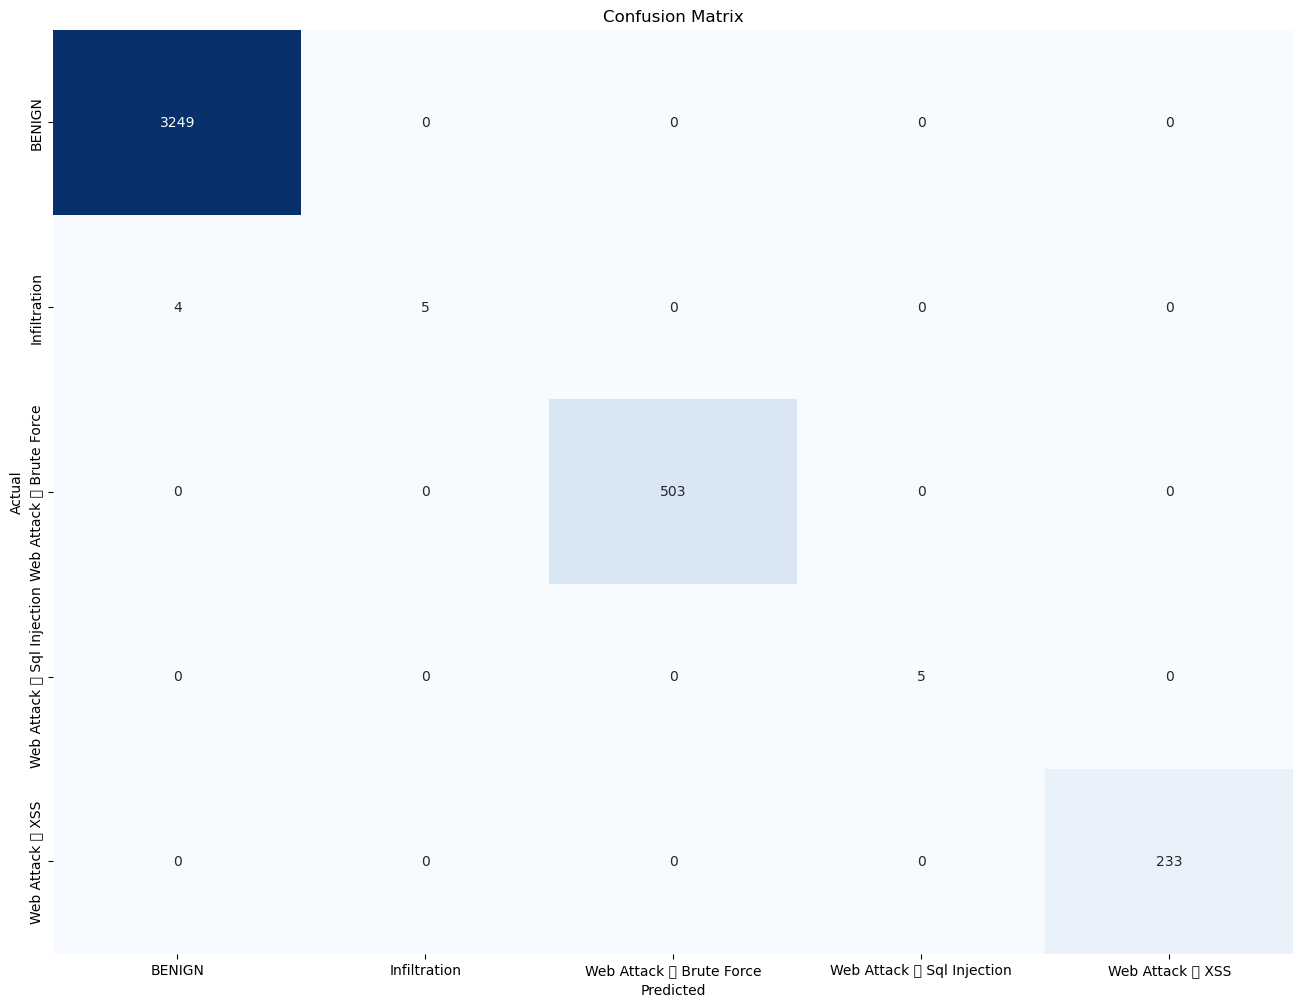

,precision,recall,f1-score,support
BENIGN,0.998770,1.000000,0.999385,3249.000
Infiltration,1.000000,0.555556,0.714286,9.000
Web Attack  Brute Force,1.000000,1.000000,1.000000,503.000
Web Attack  Sql Injection,1.000000,1.000000,1.000000,5.000
Web Attack  XSS,1.000000,1.000000,1.000000,233.000
accuracy,0.999000,0.999000,0.999000,0.999
macro avg,0.999754,0.911111,0.942734,3999.000
weighted avg,0.999001,0.999000,0.998857,3999.000


In [25]:
# Tuesday
freezed_Tue = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Tue.hidden1.parameters():
    param.requires_grad = False
for param in freezed_Tue.hidden2.parameters():
    param.requires_grad = False
for param in freezed_Tue.hidden3.parameters():
    param.requires_grad = False
for param in freezed_Tue.hidden4.parameters():
    param.requires_grad = False
for param in freezed_Tue.hidden5.parameters():
    param.requires_grad = False
freezed_Tue.output = nn.Linear(500, len(Tue.categories_as_list)).to(DEVICE)
training_model(model=freezed_Tue, train_test=Tue, n_epochs=1000)

# Wendsday
freezed_Wed = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Wed.hidden1.parameters():
    param.requires_grad = False
for param in freezed_Wed.hidden2.parameters():
    param.requires_grad = False
for param in freezed_Wed.hidden3.parameters():
    param.requires_grad = False
for param in freezed_Wed.hidden4.parameters():
    param.requires_grad = False
for param in freezed_Wed.hidden5.parameters():
    param.requires_grad = False
freezed_Wed.output = nn.Linear(500, len(Wed.categories_as_list)).to(DEVICE)
training_model(model=freezed_Wed, train_test=Wed, n_epochs=1000)

# Thursday
freezed_Thu = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Thu.hidden1.parameters():
    param.requires_grad = False
for param in freezed_Thu.hidden2.parameters():
    param.requires_grad = False
for param in freezed_Thu.hidden3.parameters():
    param.requires_grad = False
for param in freezed_Thu.hidden4.parameters():
    param.requires_grad = False
for param in freezed_Thu.hidden5.parameters():
    param.requires_grad = False
freezed_Thu.output = nn.Linear(500, len(Thu.categories_as_list)).to(DEVICE)
training_model(model=freezed_Thu, train_test=Thu, n_epochs=1000)

### 凍結模型 1~4 層

Epoch 0 validation: Cross-entropy=0.32, Accuracy=87.7%
Epoch 1 validation: Cross-entropy=0.20, Accuracy=95.5%
Epoch 2 validation: Cross-entropy=0.14, Accuracy=98.1%
Epoch 3 validation: Cross-entropy=0.10, Accuracy=98.8%
Epoch 4 validation: Cross-entropy=0.08, Accuracy=99.1%
Epoch 5 validation: Cross-entropy=0.07, Accuracy=99.2%
Epoch 6 validation: Cross-entropy=0.06, Accuracy=99.2%
Epoch 7 validation: Cross-entropy=0.06, Accuracy=99.2%
Epoch 8 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 9 validation: Cross-entropy=0.05, Accuracy=99.3%
Epoch 10 validation: Cross-entropy=0.05, Accuracy=99.3%
Epoch 11 validation: Cross-entropy=0.04, Accuracy=99.3%
Epoch 12 validation: Cross-entropy=0.04, Accuracy=99.4%
Epoch 13 validation: Cross-entropy=0.04, Accuracy=99.4%
Epoch 14 validation: Cross-entropy=0.04, Accuracy=99.4%
Epoch 15 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 16 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 17 validation: Cross-entropy=0.03, Accuracy=99.5%
Ep

Epoch 153 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 154 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 155 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 156 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 157 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 158 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 159 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 160 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 161 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 162 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 163 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 164 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 165 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 166 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 167 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 168 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 169 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 170 validation: Cro

Epoch 304 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 305 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 306 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 307 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 308 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 309 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 310 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 311 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 312 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 313 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 314 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 315 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 316 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 317 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 318 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 319 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 320 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 321 validation: Cross-ent

Epoch 452 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 453 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 454 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 455 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 456 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 457 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 458 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 459 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 460 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 461 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 462 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 463 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 464 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 465 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 466 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 467 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 468 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 469 validation: Cross-ent

Epoch 595 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 596 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 597 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 598 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 599 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 600 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 601 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 602 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 603 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 604 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 605 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 606 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 607 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 608 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 609 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 610 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 611 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 612 vali

Epoch 740 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 741 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 742 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 743 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 744 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 745 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 746 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 747 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 748 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 749 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 750 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 751 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 752 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 753 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 754 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 755 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 756 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 757 validation: Cross-e

Epoch 885 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 886 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 887 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 888 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 889 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 890 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 891 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 892 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 893 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 894 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 895 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 896 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 897 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 898 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 899 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 900 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 901 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 902 validation:

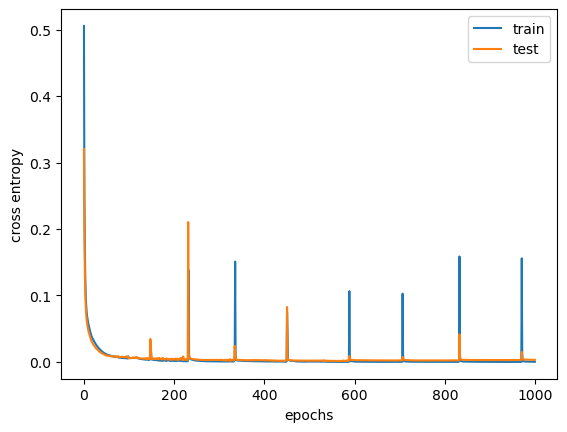

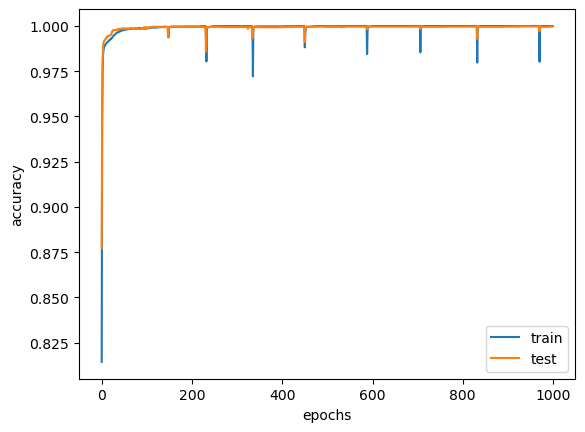

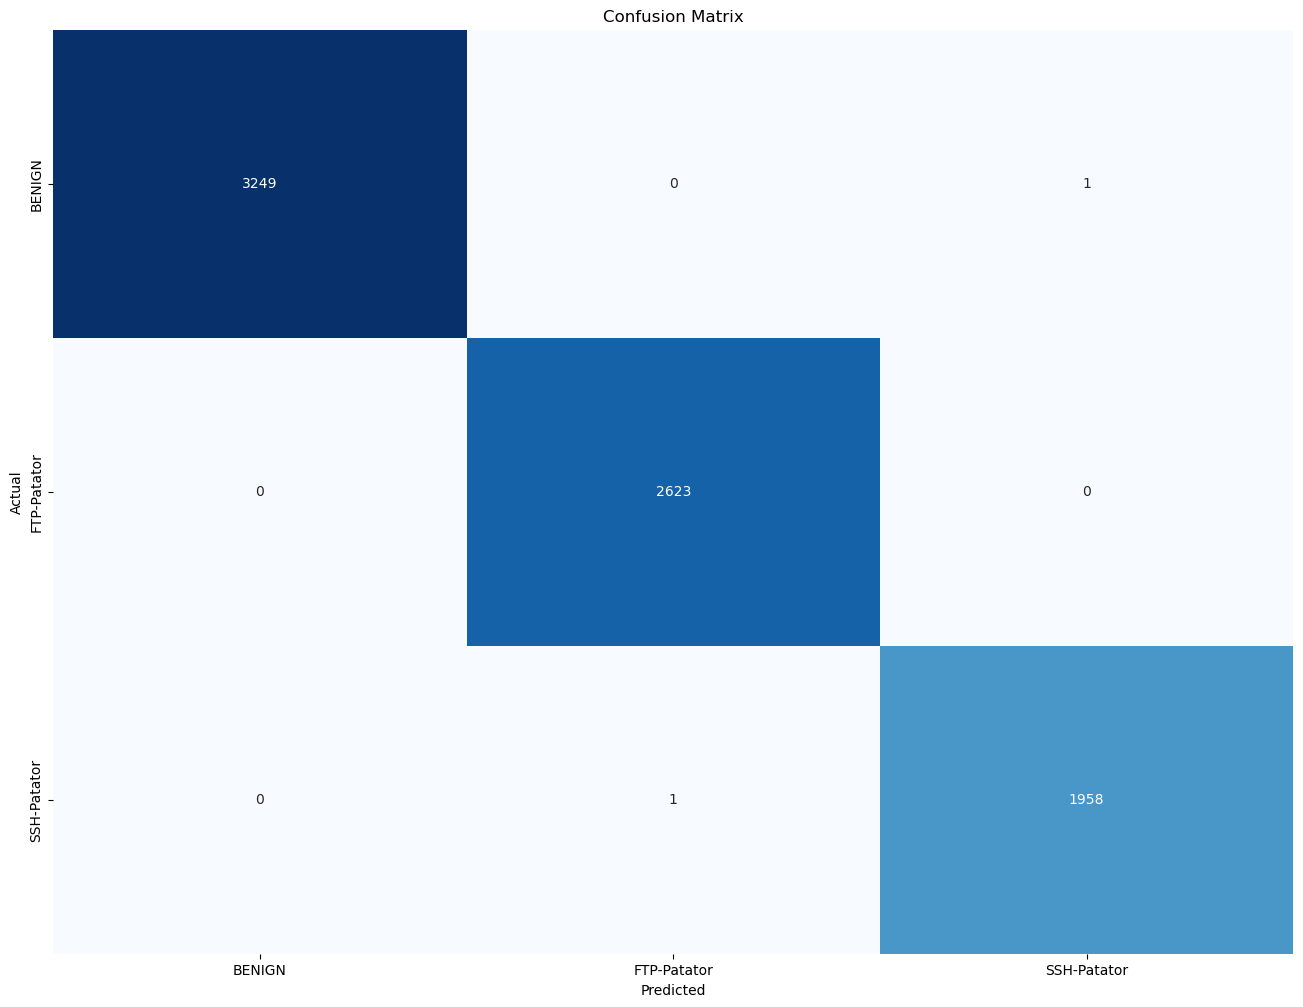

,precision,recall,f1-score,support
BENIGN,1.000000,0.999692,0.999846,3250.000000
FTP-Patator,0.999619,1.000000,0.999809,2623.000000
SSH-Patator,0.999490,0.999490,0.999490,1959.000000
accuracy,0.999745,0.999745,0.999745,0.999745
macro avg,0.999703,0.999727,0.999715,7832.000000
weighted avg,0.999745,0.999745,0.999745,7832.000000


Epoch 0 validation: Cross-entropy=0.99, Accuracy=54.7%
Epoch 1 validation: Cross-entropy=0.83, Accuracy=69.7%
Epoch 2 validation: Cross-entropy=0.71, Accuracy=77.6%
Epoch 3 validation: Cross-entropy=0.63, Accuracy=82.5%
Epoch 4 validation: Cross-entropy=0.55, Accuracy=86.6%
Epoch 5 validation: Cross-entropy=0.49, Accuracy=87.6%
Epoch 6 validation: Cross-entropy=0.44, Accuracy=88.5%
Epoch 7 validation: Cross-entropy=0.40, Accuracy=89.3%
Epoch 8 validation: Cross-entropy=0.36, Accuracy=90.7%
Epoch 9 validation: Cross-entropy=0.33, Accuracy=91.8%
Epoch 10 validation: Cross-entropy=0.31, Accuracy=92.4%
Epoch 11 validation: Cross-entropy=0.28, Accuracy=93.0%
Epoch 12 validation: Cross-entropy=0.26, Accuracy=93.3%
Epoch 13 validation: Cross-entropy=0.25, Accuracy=93.3%
Epoch 14 validation: Cross-entropy=0.23, Accuracy=94.0%
Epoch 15 validation: Cross-entropy=0.21, Accuracy=94.7%
Epoch 16 validation: Cross-entropy=0.20, Accuracy=95.0%
Epoch 17 validation: Cross-entropy=0.19, Accuracy=95.2%
Ep

Epoch 150 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 151 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 152 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 153 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 154 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 155 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 156 validation: Cross-entropy=0.02, Accuracy=99.4%
Epoch 157 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 158 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 159 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 160 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 161 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 162 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 163 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 164 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 165 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 166 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 167 validation: Cross-ent

Epoch 295 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 296 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 297 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 298 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 299 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 300 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 301 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 302 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 303 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 304 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 305 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 306 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 307 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 308 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 309 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 310 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 311 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 312 validation: Cross-ent

Epoch 440 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 441 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 442 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 443 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 444 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 445 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 446 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 447 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 448 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 449 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 450 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 451 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 452 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 453 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 454 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 455 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 456 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 457 validation: Cross-ent

Epoch 585 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 586 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 587 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 588 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 589 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 590 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 591 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 592 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 593 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 594 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 595 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 596 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 597 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 598 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 599 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 600 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 601 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 602 validation: Cross-ent

Epoch 730 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 731 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 732 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 733 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 734 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 735 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 736 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 737 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 738 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 739 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 740 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 741 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 742 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 743 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 744 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 745 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 746 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 747 validation: Cross-ent

Epoch 875 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 876 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 877 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 878 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 879 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 880 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 881 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 882 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 883 validation: Cross-entropy=0.03, Accuracy=99.0%
Epoch 884 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 885 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 886 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 887 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 888 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 889 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 890 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 891 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 892 validation: Cross-ent

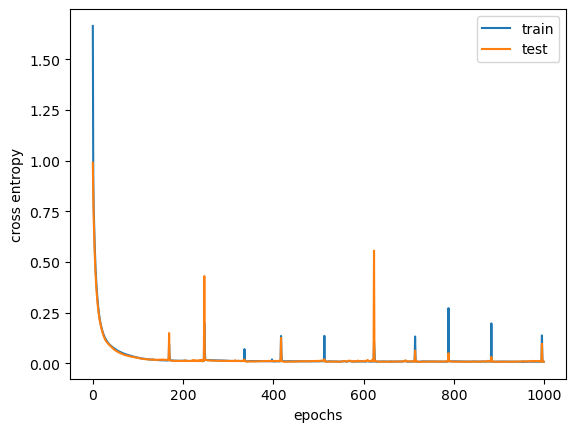

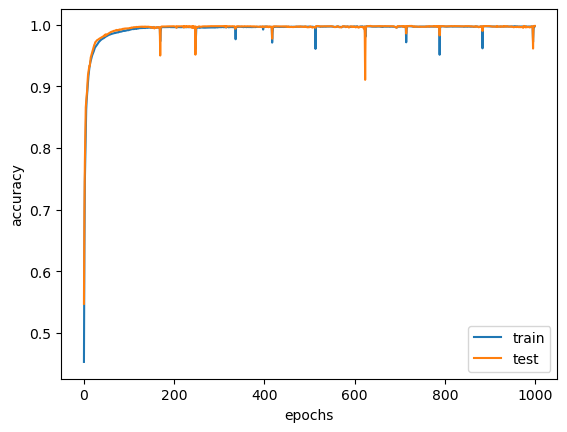

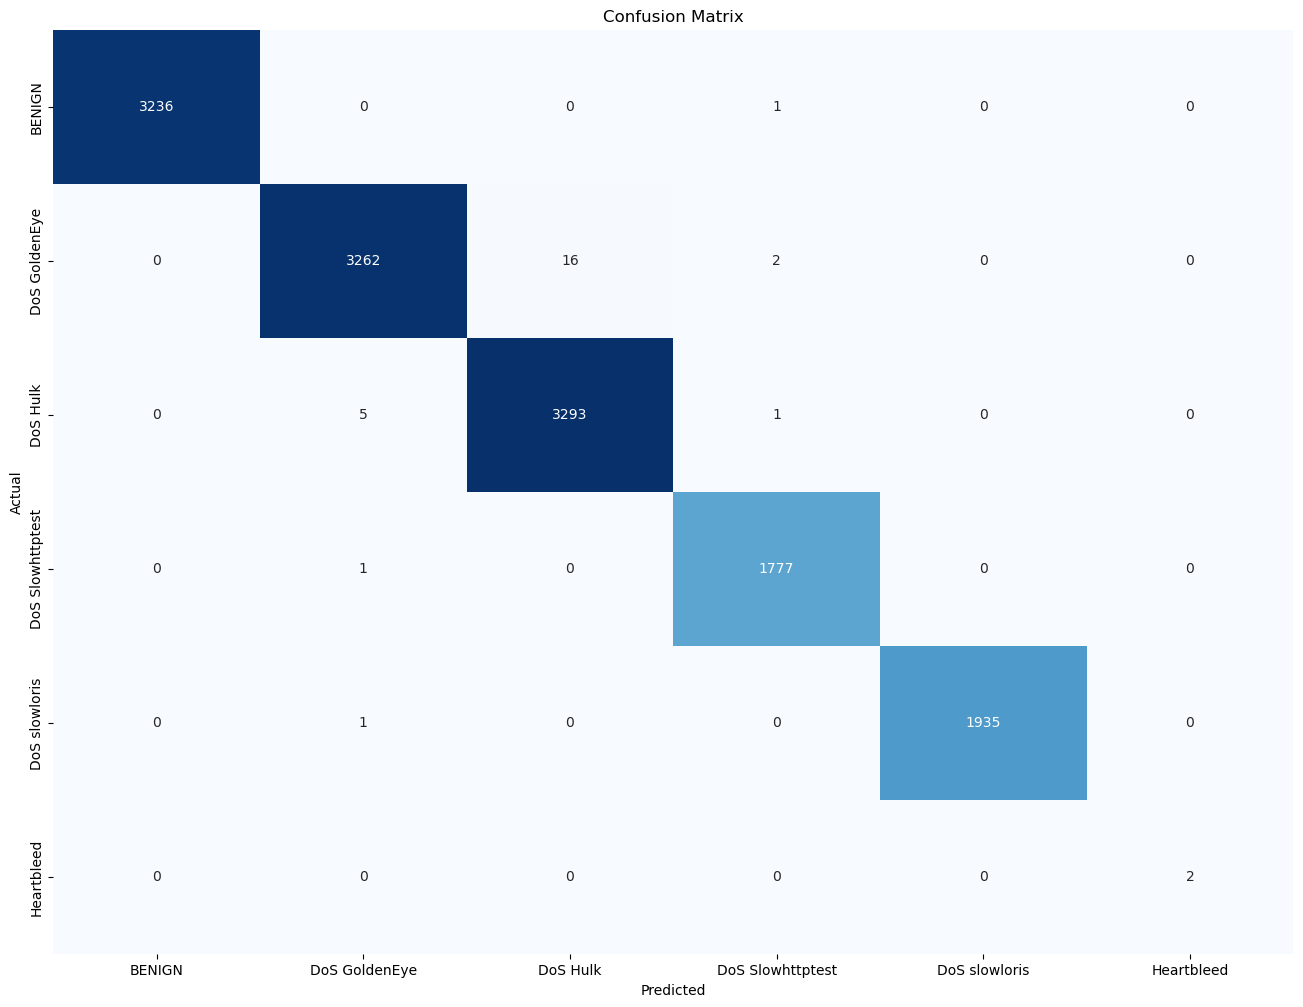

,precision,recall,f1-score,support
BENIGN,1.000000,0.999691,0.999846,3237.000000
DoS GoldenEye,0.997859,0.994512,0.996183,3280.000000
DoS Hulk,0.995165,0.998181,0.996671,3299.000000
DoS Slowhttptest,0.997754,0.999438,0.998595,1778.000000
DoS slowloris,1.000000,0.999483,0.999742,1936.000000
Heartbleed,1.000000,1.000000,1.000000,2.000000
accuracy,0.998005,0.998005,0.998005,0.998005
macro avg,0.998463,0.998551,0.998506,13532.000000
weighted avg,0.998007,0.998005,0.998005,13532.000000


Epoch 0 validation: Cross-entropy=0.53, Accuracy=89.2%
Epoch 1 validation: Cross-entropy=0.31, Accuracy=92.7%
Epoch 2 validation: Cross-entropy=0.21, Accuracy=93.9%
Epoch 3 validation: Cross-entropy=0.17, Accuracy=93.5%
Epoch 4 validation: Cross-entropy=0.14, Accuracy=93.5%
Epoch 5 validation: Cross-entropy=0.13, Accuracy=94.8%
Epoch 6 validation: Cross-entropy=0.12, Accuracy=95.5%
Epoch 7 validation: Cross-entropy=0.11, Accuracy=96.0%
Epoch 8 validation: Cross-entropy=0.10, Accuracy=96.4%
Epoch 9 validation: Cross-entropy=0.10, Accuracy=96.6%
Epoch 10 validation: Cross-entropy=0.09, Accuracy=96.8%
Epoch 11 validation: Cross-entropy=0.09, Accuracy=96.8%
Epoch 12 validation: Cross-entropy=0.08, Accuracy=96.9%
Epoch 13 validation: Cross-entropy=0.08, Accuracy=96.9%
Epoch 14 validation: Cross-entropy=0.07, Accuracy=97.0%
Epoch 15 validation: Cross-entropy=0.07, Accuracy=97.1%
Epoch 16 validation: Cross-entropy=0.07, Accuracy=97.2%
Epoch 17 validation: Cross-entropy=0.06, Accuracy=97.2%
Ep

Epoch 153 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 154 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 155 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 156 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 157 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 158 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 159 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 160 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 161 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 162 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 163 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 164 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 165 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 166 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 167 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 168 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 169 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 170 validation: Cross-ent

Epoch 306 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 307 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 308 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 309 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 310 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 311 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 312 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 313 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 314 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 315 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 316 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 317 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 318 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 319 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 320 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 321 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 322 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 323 validation: Cross-ent

Epoch 459 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 460 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 461 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 462 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 463 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 464 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 465 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 466 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 467 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 468 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 469 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 470 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 471 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 472 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 473 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 474 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 475 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 476 validation: Cross-ent

Epoch 612 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 613 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 614 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 615 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 616 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 617 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 618 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 619 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 620 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 621 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 622 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 623 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 624 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 625 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 626 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 627 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 628 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 629 validation: Cross-ent

Epoch 765 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 766 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 767 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 768 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 769 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 770 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 771 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 772 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 773 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 774 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 775 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 776 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 777 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 778 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 779 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 780 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 781 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 782 validation: Cross-ent

Epoch 918 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 919 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 920 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 921 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 922 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 923 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 924 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 925 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 926 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 927 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 928 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 929 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 930 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 931 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 932 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 933 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 934 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 935 validation: Cross-ent

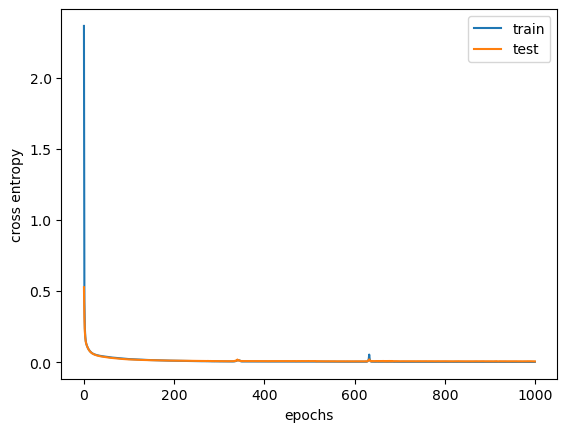

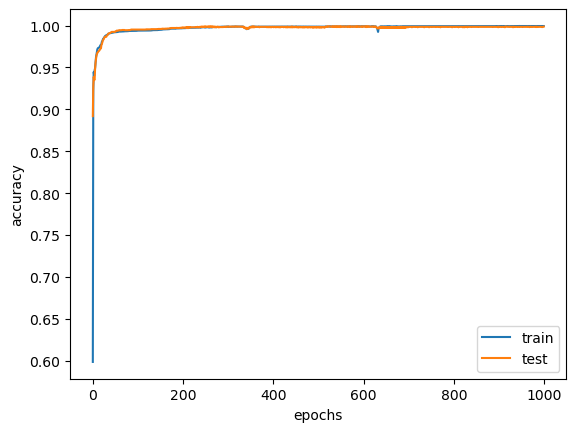

/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.draw()
/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


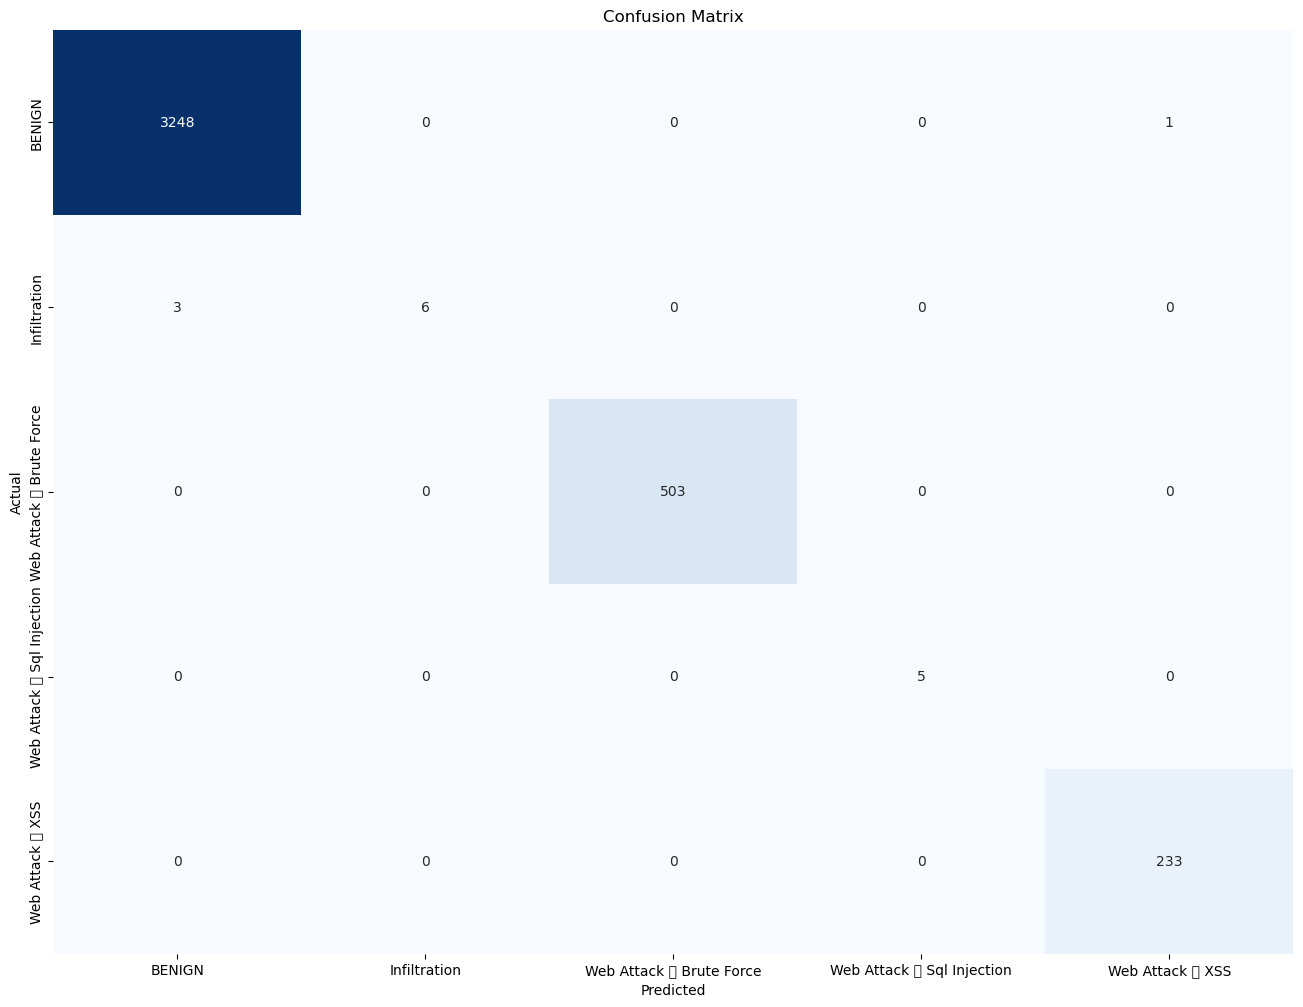

,precision,recall,f1-score,support
BENIGN,0.999077,0.999692,0.999385,3249.000
Infiltration,1.000000,0.666667,0.800000,9.000
Web Attack  Brute Force,1.000000,1.000000,1.000000,503.000
Web Attack  Sql Injection,1.000000,1.000000,1.000000,5.000
Web Attack  XSS,0.995726,1.000000,0.997859,233.000
accuracy,0.999000,0.999000,0.999000,0.999
macro avg,0.998961,0.933272,0.959449,3999.000
weighted avg,0.999001,0.999000,0.998925,3999.000


In [26]:
# Tuesday
freezed_Tue = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Tue.hidden1.parameters():
    param.requires_grad = False
for param in freezed_Tue.hidden2.parameters():
    param.requires_grad = False
for param in freezed_Tue.hidden3.parameters():
    param.requires_grad = False
for param in freezed_Tue.hidden4.parameters():
    param.requires_grad = False
freezed_Tue.output = nn.Linear(500, len(Tue.categories_as_list)).to(DEVICE)
training_model(model=freezed_Tue, train_test=Tue, n_epochs=1000)

# Wendsday
freezed_Wed = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Wed.hidden1.parameters():
    param.requires_grad = False
for param in freezed_Wed.hidden2.parameters():
    param.requires_grad = False
for param in freezed_Wed.hidden3.parameters():
    param.requires_grad = False
for param in freezed_Wed.hidden4.parameters():
    param.requires_grad = False
freezed_Wed.output = nn.Linear(500, len(Wed.categories_as_list)).to(DEVICE)
training_model(model=freezed_Wed, train_test=Wed, n_epochs=1000)

# Thursday
freezed_Thu = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Thu.hidden1.parameters():
    param.requires_grad = False
for param in freezed_Thu.hidden2.parameters():
    param.requires_grad = False
for param in freezed_Thu.hidden3.parameters():
    param.requires_grad = False
for param in freezed_Thu.hidden4.parameters():
    param.requires_grad = False
freezed_Thu.output = nn.Linear(500, len(Thu.categories_as_list)).to(DEVICE)
training_model(model=freezed_Thu, train_test=Thu, n_epochs=1000)

### 凍結模型 1~3 層

Epoch 0 validation: Cross-entropy=0.27, Accuracy=94.7%
Epoch 1 validation: Cross-entropy=0.15, Accuracy=97.1%
Epoch 2 validation: Cross-entropy=0.10, Accuracy=98.7%
Epoch 3 validation: Cross-entropy=0.08, Accuracy=99.0%
Epoch 4 validation: Cross-entropy=0.07, Accuracy=99.2%
Epoch 5 validation: Cross-entropy=0.06, Accuracy=99.2%
Epoch 6 validation: Cross-entropy=0.05, Accuracy=99.3%
Epoch 7 validation: Cross-entropy=0.05, Accuracy=99.3%
Epoch 8 validation: Cross-entropy=0.04, Accuracy=99.4%
Epoch 9 validation: Cross-entropy=0.04, Accuracy=99.4%
Epoch 10 validation: Cross-entropy=0.04, Accuracy=99.4%
Epoch 11 validation: Cross-entropy=0.04, Accuracy=99.5%
Epoch 12 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 13 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 14 validation: Cross-entropy=0.03, Accuracy=99.6%
Epoch 15 validation: Cross-entropy=0.03, Accuracy=99.7%
Epoch 16 validation: Cross-entropy=0.03, Accuracy=99.7%
Epoch 17 validation: Cross-entropy=0.02, Accuracy=99.6%
Ep

Epoch 149 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 150 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 151 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 152 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 153 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 154 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 155 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 156 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 157 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 158 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 159 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 160 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 161 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 162 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 163 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 164 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 165 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 166 validation: Cross-ent

Epoch 294 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 295 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 296 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 297 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 298 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 299 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 300 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 301 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 302 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 303 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 304 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 305 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 306 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 307 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 308 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 309 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 310 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 311 validation: Cross-en

Epoch 438 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 439 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 440 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 441 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 442 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 443 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 444 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 445 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 446 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 447 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 448 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 449 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 450 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 451 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 452 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 453 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 454 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 455 validation: Cro

Epoch 587 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 588 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 589 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 590 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 591 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 592 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 593 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 594 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 595 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 596 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 597 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 598 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 599 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 600 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 601 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 602 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 603 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 604 validation: Cross-en

Epoch 733 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 734 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 735 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 736 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 737 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 738 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 739 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 740 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 741 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 742 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 743 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 744 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 745 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 746 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 747 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 748 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 749 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 750 vali

Epoch 879 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 880 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 881 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 882 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 883 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 884 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 885 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 886 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 887 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 888 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 889 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 890 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 891 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 892 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 893 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 894 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 895 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 896 vali

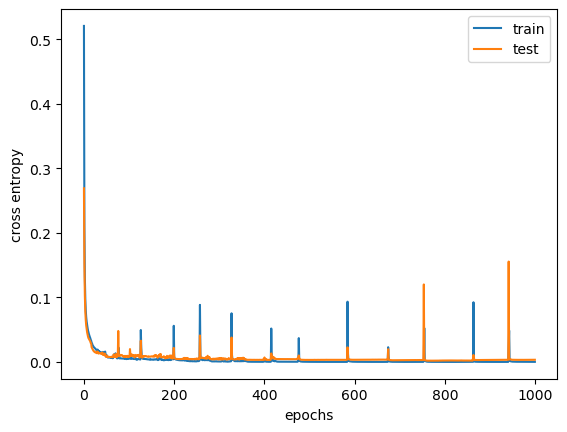

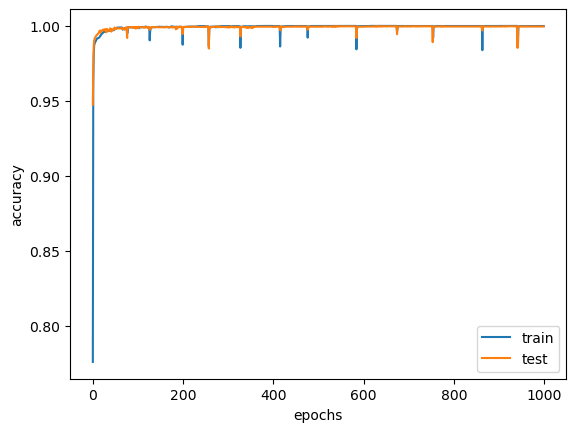

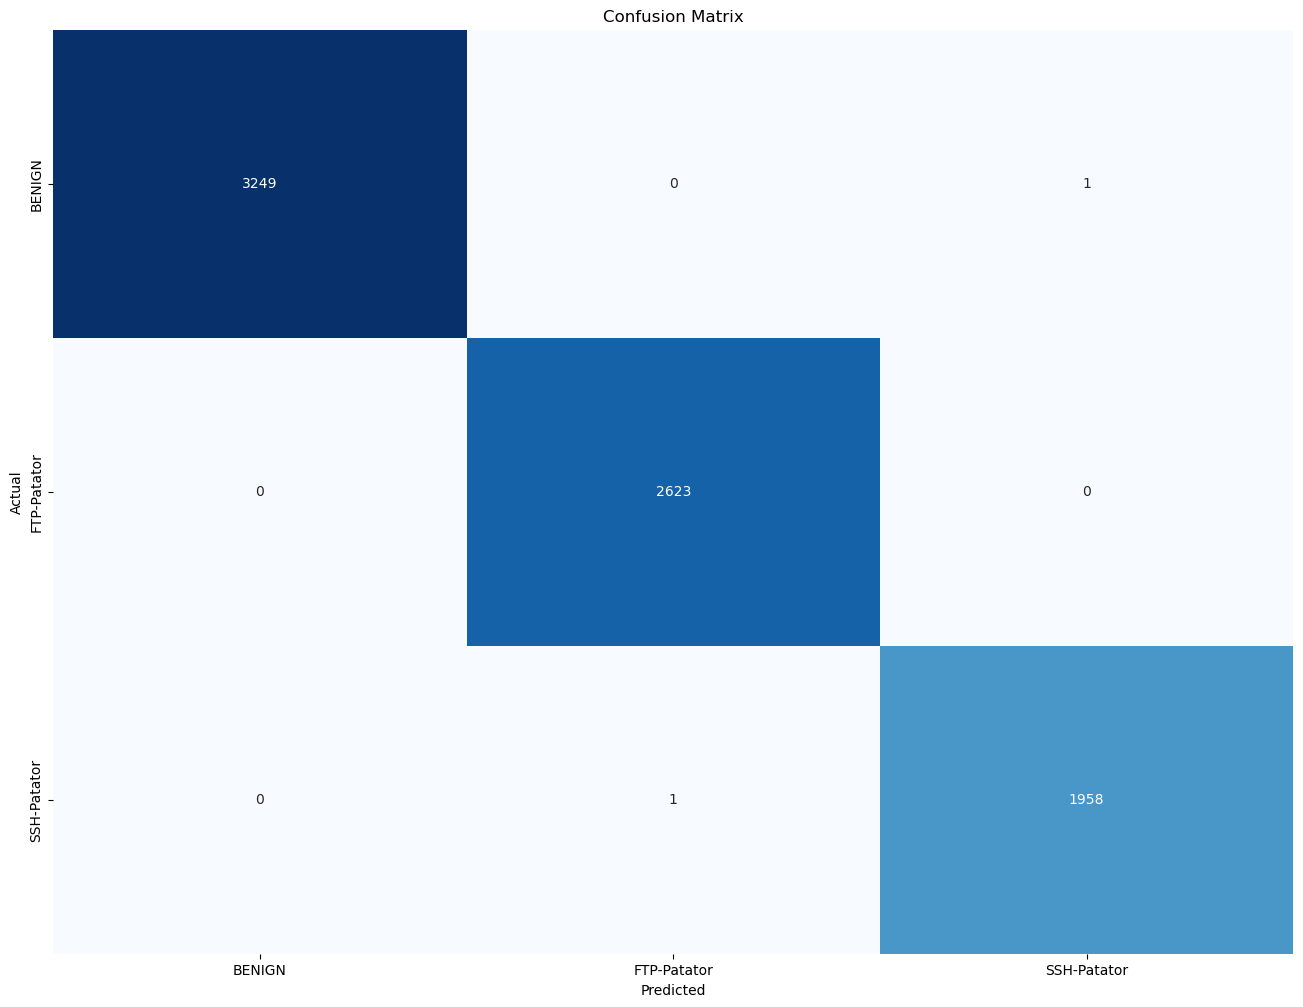

,precision,recall,f1-score,support
BENIGN,1.000000,0.999692,0.999846,3250.000000
FTP-Patator,0.999619,1.000000,0.999809,2623.000000
SSH-Patator,0.999490,0.999490,0.999490,1959.000000
accuracy,0.999745,0.999745,0.999745,0.999745
macro avg,0.999703,0.999727,0.999715,7832.000000
weighted avg,0.999745,0.999745,0.999745,7832.000000


Epoch 0 validation: Cross-entropy=0.88, Accuracy=64.2%
Epoch 1 validation: Cross-entropy=0.69, Accuracy=75.3%
Epoch 2 validation: Cross-entropy=0.55, Accuracy=82.6%
Epoch 3 validation: Cross-entropy=0.45, Accuracy=85.5%
Epoch 4 validation: Cross-entropy=0.39, Accuracy=87.8%
Epoch 5 validation: Cross-entropy=0.33, Accuracy=89.7%
Epoch 6 validation: Cross-entropy=0.30, Accuracy=91.4%
Epoch 7 validation: Cross-entropy=0.27, Accuracy=92.0%
Epoch 8 validation: Cross-entropy=0.23, Accuracy=92.8%
Epoch 9 validation: Cross-entropy=0.20, Accuracy=94.3%
Epoch 10 validation: Cross-entropy=0.17, Accuracy=95.5%
Epoch 11 validation: Cross-entropy=0.16, Accuracy=96.3%
Epoch 12 validation: Cross-entropy=0.14, Accuracy=96.3%
Epoch 13 validation: Cross-entropy=0.14, Accuracy=96.0%
Epoch 14 validation: Cross-entropy=0.13, Accuracy=95.8%
Epoch 15 validation: Cross-entropy=0.12, Accuracy=95.9%
Epoch 16 validation: Cross-entropy=0.12, Accuracy=96.3%
Epoch 17 validation: Cross-entropy=0.11, Accuracy=96.1%
Ep

Epoch 149 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 150 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 151 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 152 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 153 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 154 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 155 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 156 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 157 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 158 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 159 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 160 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 161 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 162 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 163 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 164 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 165 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 166 validation: Cross-ent

Epoch 293 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 294 validation: Cross-entropy=0.01, Accuracy=99.4%
Epoch 295 validation: Cross-entropy=0.01, Accuracy=99.4%
Epoch 296 validation: Cross-entropy=0.02, Accuracy=99.4%
Epoch 297 validation: Cross-entropy=0.02, Accuracy=99.3%
Epoch 298 validation: Cross-entropy=0.02, Accuracy=99.2%
Epoch 299 validation: Cross-entropy=0.02, Accuracy=99.2%
Epoch 300 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 301 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 302 validation: Cross-entropy=0.02, Accuracy=99.0%
Epoch 303 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 304 validation: Cross-entropy=0.02, Accuracy=99.0%
Epoch 305 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 306 validation: Cross-entropy=0.02, Accuracy=99.0%
Epoch 307 validation: Cross-entropy=0.02, Accuracy=99.0%
Epoch 308 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 309 validation: Cross-entropy=0.02, Accuracy=99.0%
Epoch 310 validation: Cross-ent

Epoch 437 validation: Cross-entropy=0.03, Accuracy=99.0%
Epoch 438 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 439 validation: Cross-entropy=0.02, Accuracy=99.2%
Epoch 440 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 441 validation: Cross-entropy=0.02, Accuracy=99.2%
Epoch 442 validation: Cross-entropy=0.02, Accuracy=99.0%
Epoch 443 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 444 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 445 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 446 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 447 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 448 validation: Cross-entropy=0.02, Accuracy=99.2%
Epoch 449 validation: Cross-entropy=0.02, Accuracy=99.0%
Epoch 450 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 451 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 452 validation: Cross-entropy=0.02, Accuracy=99.3%
Epoch 453 validation: Cross-entropy=0.02, Accuracy=99.2%
Epoch 454 validation: Cross-ent

Epoch 582 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 583 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 584 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 585 validation: Cross-entropy=0.02, Accuracy=99.2%
Epoch 586 validation: Cross-entropy=0.08, Accuracy=97.0%
Epoch 587 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 588 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 589 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 590 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 591 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 592 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 593 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 594 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 595 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 596 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 597 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 598 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 599 validation: Cross-ent

Epoch 728 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 729 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 730 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 731 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 732 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 733 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 734 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 735 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 736 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 737 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 738 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 739 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 740 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 741 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 742 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 743 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 744 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 745 validation: Cross-ent

Epoch 872 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 873 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 874 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 875 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 876 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 877 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 878 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 879 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 880 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 881 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 882 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 883 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 884 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 885 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 886 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 887 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 888 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 889 validation: Cross-ent

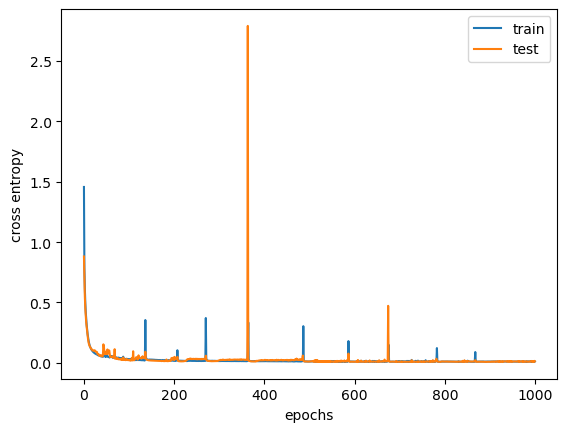

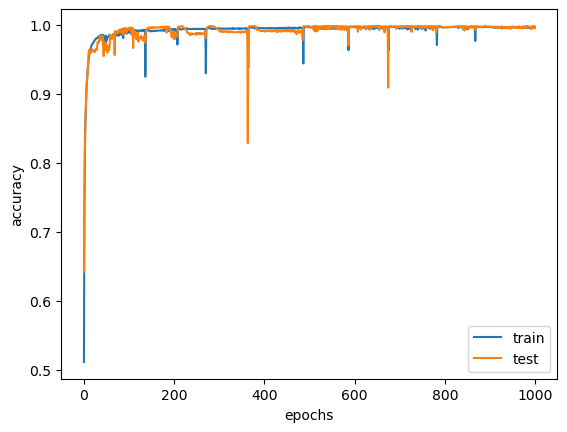

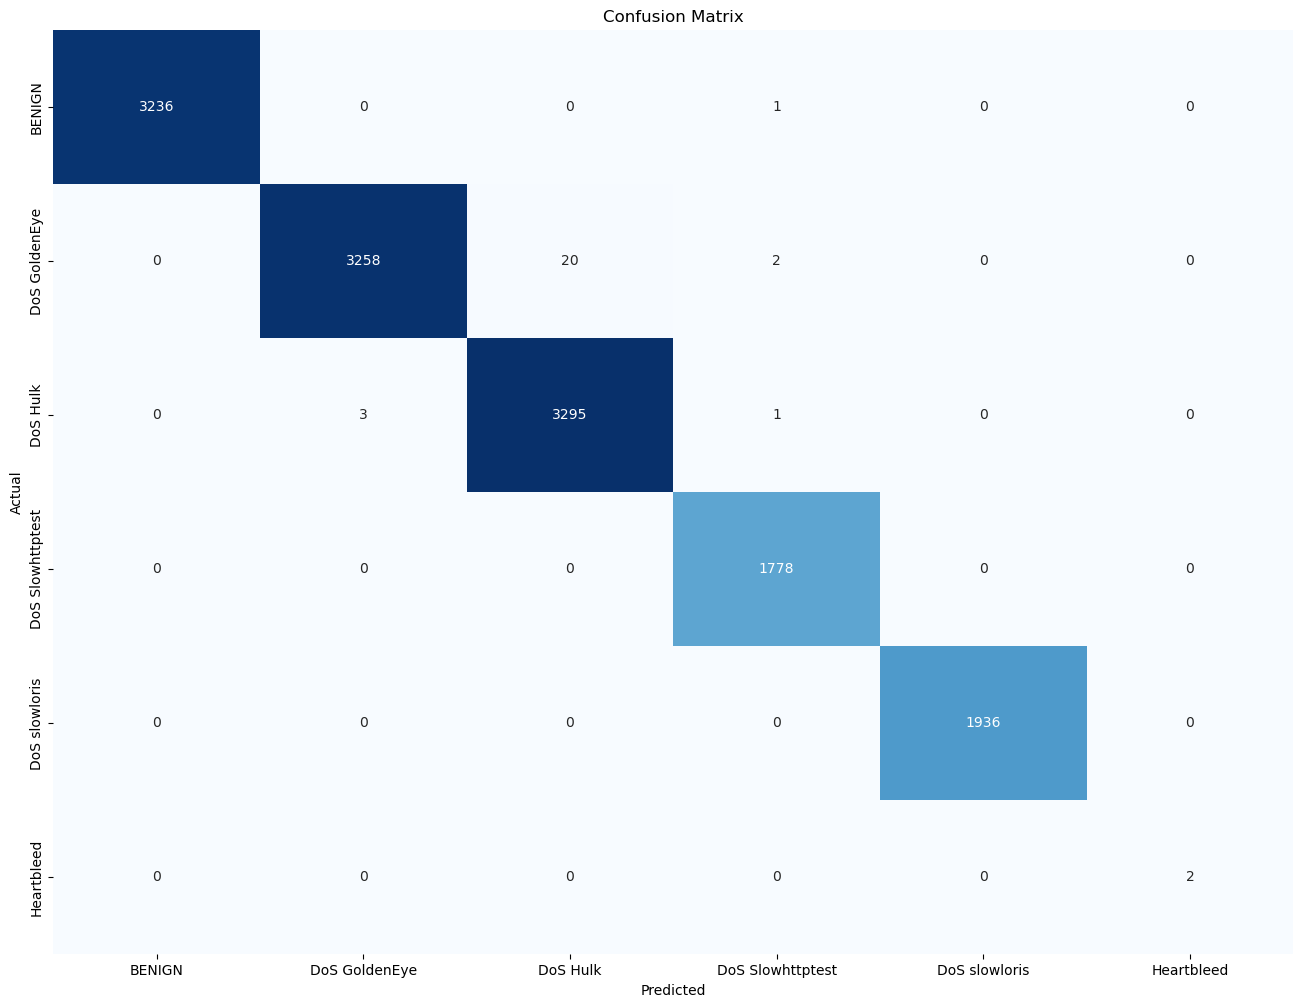

,precision,recall,f1-score,support
BENIGN,1.000000,0.999691,0.999846,3237.000000
DoS GoldenEye,0.999080,0.993293,0.996178,3280.000000
DoS Hulk,0.993967,0.998788,0.996371,3299.000000
DoS Slowhttptest,0.997755,1.000000,0.998876,1778.000000
DoS slowloris,1.000000,1.000000,1.000000,1936.000000
Heartbleed,1.000000,1.000000,1.000000,2.000000
accuracy,0.998005,0.998005,0.998005,0.998005
macro avg,0.998467,0.998629,0.998545,13532.000000
weighted avg,0.998011,0.998005,0.998004,13532.000000


Epoch 0 validation: Cross-entropy=0.30, Accuracy=91.6%
Epoch 1 validation: Cross-entropy=0.20, Accuracy=93.4%
Epoch 2 validation: Cross-entropy=0.15, Accuracy=94.8%
Epoch 3 validation: Cross-entropy=0.12, Accuracy=95.8%
Epoch 4 validation: Cross-entropy=0.10, Accuracy=96.0%
Epoch 5 validation: Cross-entropy=0.09, Accuracy=96.3%
Epoch 6 validation: Cross-entropy=0.08, Accuracy=96.6%
Epoch 7 validation: Cross-entropy=0.08, Accuracy=96.8%
Epoch 8 validation: Cross-entropy=0.07, Accuracy=96.9%
Epoch 9 validation: Cross-entropy=0.07, Accuracy=97.0%
Epoch 10 validation: Cross-entropy=0.06, Accuracy=97.8%
Epoch 11 validation: Cross-entropy=0.06, Accuracy=98.2%
Epoch 12 validation: Cross-entropy=0.06, Accuracy=98.4%
Epoch 13 validation: Cross-entropy=0.05, Accuracy=98.6%
Epoch 14 validation: Cross-entropy=0.05, Accuracy=98.6%
Epoch 15 validation: Cross-entropy=0.05, Accuracy=98.7%
Epoch 16 validation: Cross-entropy=0.05, Accuracy=98.8%
Epoch 17 validation: Cross-entropy=0.04, Accuracy=98.9%
Ep

Epoch 150 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 151 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 152 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 153 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 154 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 155 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 156 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 157 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 158 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 159 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 160 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 161 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 162 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 163 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 164 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 165 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 166 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 167 validation: Cross-ent

Epoch 300 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 301 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 302 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 303 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 304 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 305 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 306 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 307 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 308 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 309 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 310 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 311 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 312 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 313 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 314 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 315 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 316 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 317 validation: Cross-ent

Epoch 450 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 451 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 452 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 453 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 454 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 455 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 456 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 457 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 458 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 459 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 460 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 461 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 462 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 463 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 464 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 465 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 466 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 467 validation: Cross-ent

Epoch 600 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 601 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 602 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 603 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 604 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 605 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 606 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 607 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 608 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 609 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 610 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 611 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 612 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 613 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 614 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 615 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 616 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 617 validation: Cross-ent

Epoch 750 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 751 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 752 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 753 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 754 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 755 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 756 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 757 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 758 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 759 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 760 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 761 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 762 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 763 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 764 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 765 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 766 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 767 validation: Cross-ent

Epoch 899 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 900 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 901 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 902 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 903 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 904 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 905 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 906 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 907 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 908 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 909 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 910 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 911 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 912 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 913 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 914 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 915 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 916 validation: Cross-ent

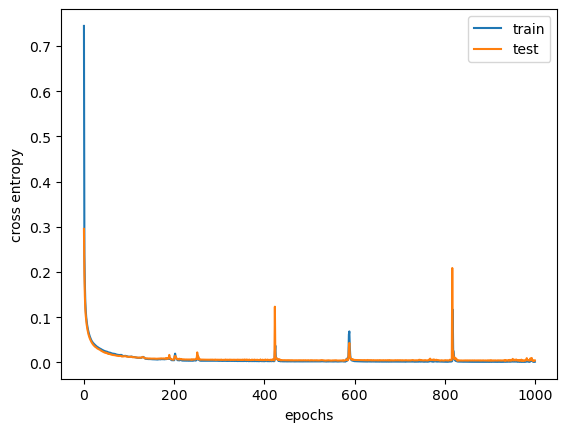

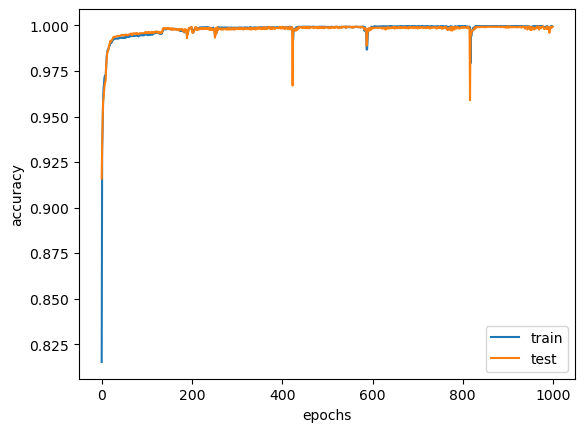

/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.draw()
/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


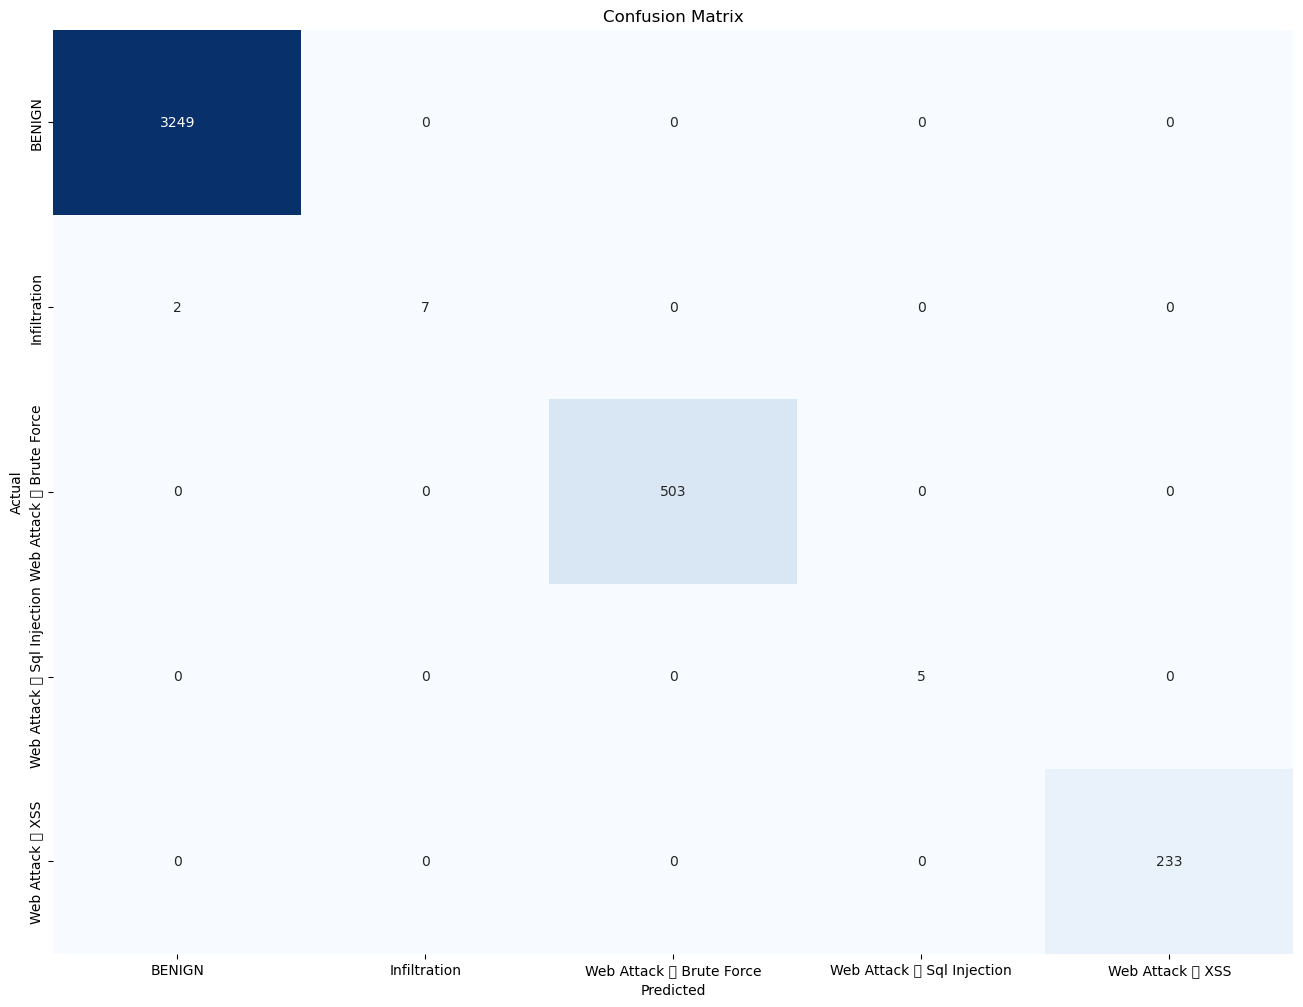

,precision,recall,f1-score,support
BENIGN,0.999385,1.000000,0.999692,3249.0000
Infiltration,1.000000,0.777778,0.875000,9.0000
Web Attack  Brute Force,1.000000,1.000000,1.000000,503.0000
Web Attack  Sql Injection,1.000000,1.000000,1.000000,5.0000
Web Attack  XSS,1.000000,1.000000,1.000000,233.0000
accuracy,0.999500,0.999500,0.999500,0.9995
macro avg,0.999877,0.955556,0.974938,3999.0000
weighted avg,0.999500,0.999500,0.999469,3999.0000


In [27]:
# Tuesday
freezed_Tue = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Tue.hidden1.parameters():
    param.requires_grad = False
for param in freezed_Tue.hidden2.parameters():
    param.requires_grad = False
for param in freezed_Tue.hidden3.parameters():
    param.requires_grad = False
freezed_Tue.output = nn.Linear(500, len(Tue.categories_as_list)).to(DEVICE)
training_model(model=freezed_Tue, train_test=Tue, n_epochs=1000)

# Wendsday
freezed_Wed = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Wed.hidden1.parameters():
    param.requires_grad = False
for param in freezed_Wed.hidden2.parameters():
    param.requires_grad = False
for param in freezed_Wed.hidden3.parameters():
    param.requires_grad = False
freezed_Wed.output = nn.Linear(500, len(Wed.categories_as_list)).to(DEVICE)
training_model(model=freezed_Wed, train_test=Wed, n_epochs=1000)

# Thursday
freezed_Thu = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Thu.hidden1.parameters():
    param.requires_grad = False
for param in freezed_Thu.hidden2.parameters():
    param.requires_grad = False
for param in freezed_Thu.hidden3.parameters():
    param.requires_grad = False
freezed_Thu.output = nn.Linear(500, len(Thu.categories_as_list)).to(DEVICE)
training_model(model=freezed_Thu, train_test=Thu, n_epochs=1000)

### 凍結模型 1~2 層

Epoch 0 validation: Cross-entropy=0.27, Accuracy=94.5%
Epoch 1 validation: Cross-entropy=0.14, Accuracy=97.5%
Epoch 2 validation: Cross-entropy=0.09, Accuracy=98.9%
Epoch 3 validation: Cross-entropy=0.07, Accuracy=99.1%
Epoch 4 validation: Cross-entropy=0.06, Accuracy=99.2%
Epoch 5 validation: Cross-entropy=0.05, Accuracy=99.3%
Epoch 6 validation: Cross-entropy=0.05, Accuracy=99.4%
Epoch 7 validation: Cross-entropy=0.04, Accuracy=99.4%
Epoch 8 validation: Cross-entropy=0.04, Accuracy=99.5%
Epoch 9 validation: Cross-entropy=0.04, Accuracy=99.5%
Epoch 10 validation: Cross-entropy=0.04, Accuracy=99.5%
Epoch 11 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 12 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 13 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 14 validation: Cross-entropy=0.02, Accuracy=99.4%
Epoch 15 validation: Cross-entropy=0.02, Accuracy=99.4%
Epoch 16 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 17 validation: Cross-entropy=0.02, Accuracy=99.7%
Ep

Epoch 147 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 148 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 149 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 150 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 151 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 152 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 153 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 154 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 155 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 156 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 157 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 158 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 159 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 160 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 161 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 162 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 163 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 164 validation: Cross-ent

Epoch 293 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 294 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 295 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 296 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 297 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 298 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 299 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 300 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 301 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 302 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 303 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 304 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 305 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 306 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 307 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 308 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 309 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 310 validation: Cross-ent

Epoch 439 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 440 validation: Cross-entropy=0.04, Accuracy=99.9%
Epoch 441 validation: Cross-entropy=0.01, Accuracy=100.0%
Epoch 442 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 443 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 444 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 445 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 446 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 447 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 448 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 449 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 450 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 451 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 452 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 453 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 454 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 455 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 456 validation: Cro

Epoch 586 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 587 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 588 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 589 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 590 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 591 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 592 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 593 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 594 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 595 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 596 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 597 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 598 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 599 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 600 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 601 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 602 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 603 validation: Cross-en

Epoch 733 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 734 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 735 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 736 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 737 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 738 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 739 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 740 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 741 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 742 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 743 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 744 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 745 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 746 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 747 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 748 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 749 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 750 vali

Epoch 879 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 880 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 881 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 882 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 883 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 884 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 885 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 886 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 887 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 888 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 889 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 890 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 891 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 892 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 893 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 894 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 895 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 896 vali

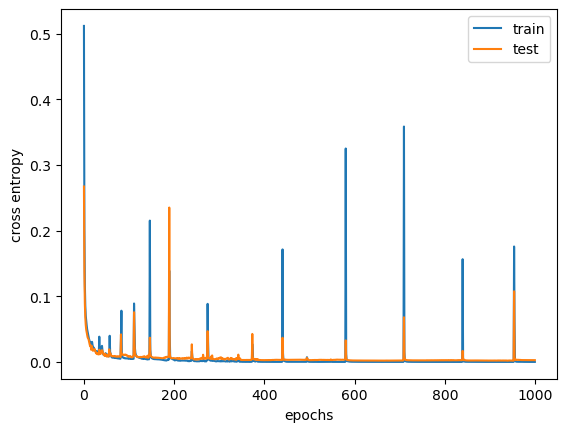

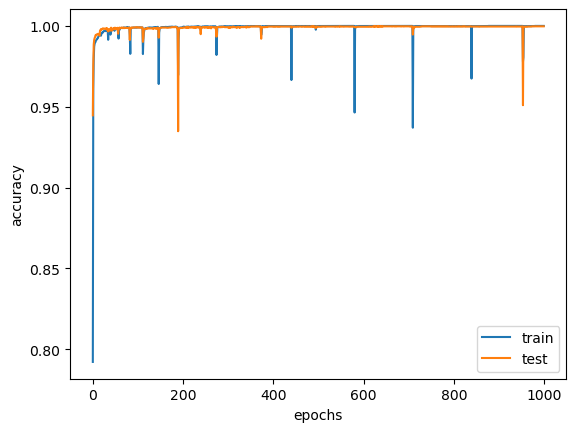

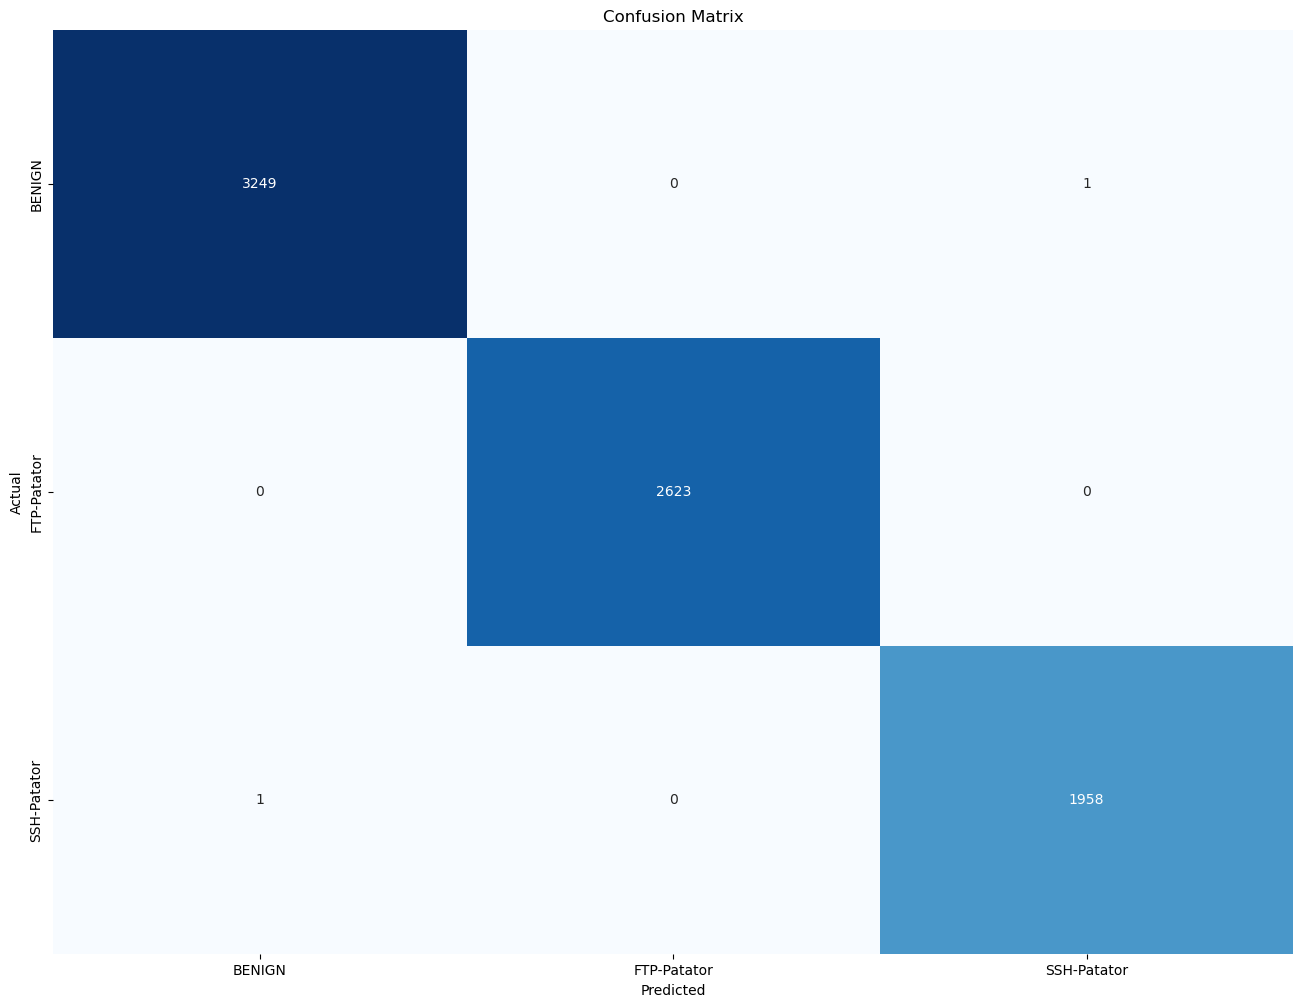

,precision,recall,f1-score,support
BENIGN,0.999692,0.999692,0.999692,3250.000000
FTP-Patator,1.000000,1.000000,1.000000,2623.000000
SSH-Patator,0.999490,0.999490,0.999490,1959.000000
accuracy,0.999745,0.999745,0.999745,0.999745
macro avg,0.999727,0.999727,0.999727,7832.000000
weighted avg,0.999745,0.999745,0.999745,7832.000000


Epoch 0 validation: Cross-entropy=0.95, Accuracy=58.5%
Epoch 1 validation: Cross-entropy=0.72, Accuracy=74.0%
Epoch 2 validation: Cross-entropy=0.53, Accuracy=82.2%
Epoch 3 validation: Cross-entropy=0.39, Accuracy=89.4%
Epoch 4 validation: Cross-entropy=0.30, Accuracy=92.1%
Epoch 5 validation: Cross-entropy=0.25, Accuracy=93.2%
Epoch 6 validation: Cross-entropy=0.23, Accuracy=93.2%
Epoch 7 validation: Cross-entropy=0.22, Accuracy=92.8%
Epoch 8 validation: Cross-entropy=0.20, Accuracy=93.6%
Epoch 9 validation: Cross-entropy=0.20, Accuracy=93.5%
Epoch 10 validation: Cross-entropy=0.17, Accuracy=94.3%
Epoch 11 validation: Cross-entropy=0.15, Accuracy=94.8%
Epoch 12 validation: Cross-entropy=0.14, Accuracy=94.7%
Epoch 13 validation: Cross-entropy=0.14, Accuracy=94.7%
Epoch 14 validation: Cross-entropy=0.17, Accuracy=92.9%
Epoch 15 validation: Cross-entropy=0.13, Accuracy=94.8%
Epoch 16 validation: Cross-entropy=0.13, Accuracy=94.6%
Epoch 17 validation: Cross-entropy=0.13, Accuracy=94.7%
Ep

Epoch 148 validation: Cross-entropy=0.03, Accuracy=99.3%
Epoch 149 validation: Cross-entropy=0.03, Accuracy=99.0%
Epoch 150 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 151 validation: Cross-entropy=0.04, Accuracy=98.3%
Epoch 152 validation: Cross-entropy=0.04, Accuracy=98.3%
Epoch 153 validation: Cross-entropy=0.06, Accuracy=97.9%
Epoch 154 validation: Cross-entropy=0.03, Accuracy=99.3%
Epoch 155 validation: Cross-entropy=0.04, Accuracy=98.2%
Epoch 156 validation: Cross-entropy=0.04, Accuracy=98.7%
Epoch 157 validation: Cross-entropy=0.53, Accuracy=85.2%
Epoch 158 validation: Cross-entropy=0.03, Accuracy=99.3%
Epoch 159 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 160 validation: Cross-entropy=0.02, Accuracy=99.4%
Epoch 161 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 162 validation: Cross-entropy=0.02, Accuracy=99.4%
Epoch 163 validation: Cross-entropy=0.02, Accuracy=99.4%
Epoch 164 validation: Cross-entropy=0.02, Accuracy=99.4%
Epoch 165 validation: Cross-ent

Epoch 292 validation: Cross-entropy=0.03, Accuracy=98.8%
Epoch 293 validation: Cross-entropy=0.03, Accuracy=98.6%
Epoch 294 validation: Cross-entropy=0.02, Accuracy=99.3%
Epoch 295 validation: Cross-entropy=0.02, Accuracy=99.4%
Epoch 296 validation: Cross-entropy=0.02, Accuracy=99.3%
Epoch 297 validation: Cross-entropy=0.02, Accuracy=99.0%
Epoch 298 validation: Cross-entropy=0.03, Accuracy=98.6%
Epoch 299 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 300 validation: Cross-entropy=0.02, Accuracy=99.0%
Epoch 301 validation: Cross-entropy=0.02, Accuracy=99.4%
Epoch 302 validation: Cross-entropy=0.04, Accuracy=98.3%
Epoch 303 validation: Cross-entropy=0.09, Accuracy=97.0%
Epoch 304 validation: Cross-entropy=0.02, Accuracy=99.3%
Epoch 305 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 306 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 307 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 308 validation: Cross-entropy=0.02, Accuracy=99.0%
Epoch 309 validation: Cross-ent

Epoch 436 validation: Cross-entropy=0.03, Accuracy=98.6%
Epoch 437 validation: Cross-entropy=0.05, Accuracy=98.8%
Epoch 438 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 439 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 440 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 441 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 442 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 443 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 444 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 445 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 446 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 447 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 448 validation: Cross-entropy=0.02, Accuracy=99.3%
Epoch 449 validation: Cross-entropy=0.02, Accuracy=99.2%
Epoch 450 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 451 validation: Cross-entropy=0.02, Accuracy=99.0%
Epoch 452 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 453 validation: Cross-ent

Epoch 580 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 581 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 582 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 583 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 584 validation: Cross-entropy=0.01, Accuracy=99.3%
Epoch 585 validation: Cross-entropy=0.02, Accuracy=99.3%
Epoch 586 validation: Cross-entropy=0.01, Accuracy=99.3%
Epoch 587 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 588 validation: Cross-entropy=0.01, Accuracy=99.4%
Epoch 589 validation: Cross-entropy=0.02, Accuracy=99.2%
Epoch 590 validation: Cross-entropy=0.01, Accuracy=99.4%
Epoch 591 validation: Cross-entropy=0.04, Accuracy=98.6%
Epoch 592 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 593 validation: Cross-entropy=0.05, Accuracy=98.1%
Epoch 594 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 595 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 596 validation: Cross-entropy=0.02, Accuracy=99.3%
Epoch 597 validation: Cross-ent

Epoch 724 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 725 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 726 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 727 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 728 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 729 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 730 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 731 validation: Cross-entropy=0.01, Accuracy=99.4%
Epoch 732 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 733 validation: Cross-entropy=0.01, Accuracy=99.3%
Epoch 734 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 735 validation: Cross-entropy=0.01, Accuracy=99.4%
Epoch 736 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 737 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 738 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 739 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 740 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 741 validation: Cross-ent

Epoch 868 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 869 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 870 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 871 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 872 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 873 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 874 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 875 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 876 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 877 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 878 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 879 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 880 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 881 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 882 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 883 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 884 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 885 validation: Cross-ent

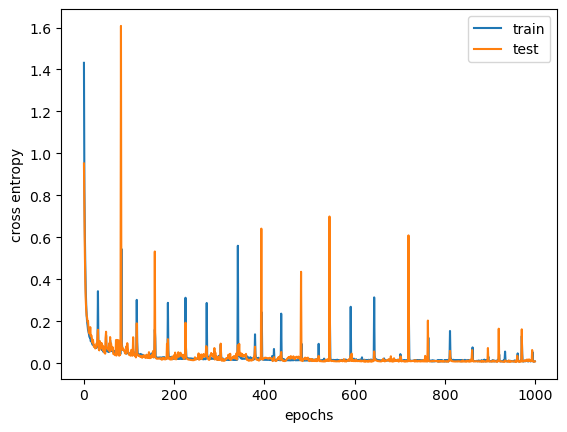

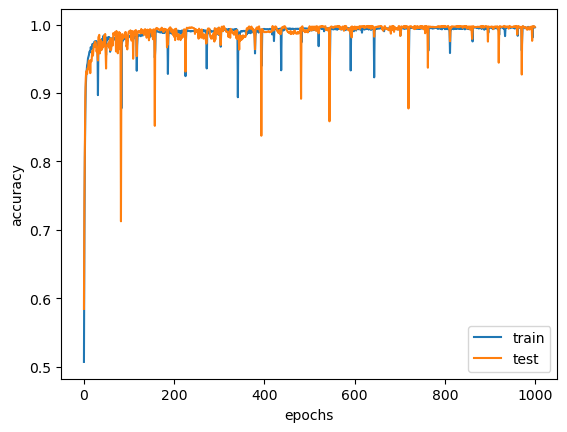

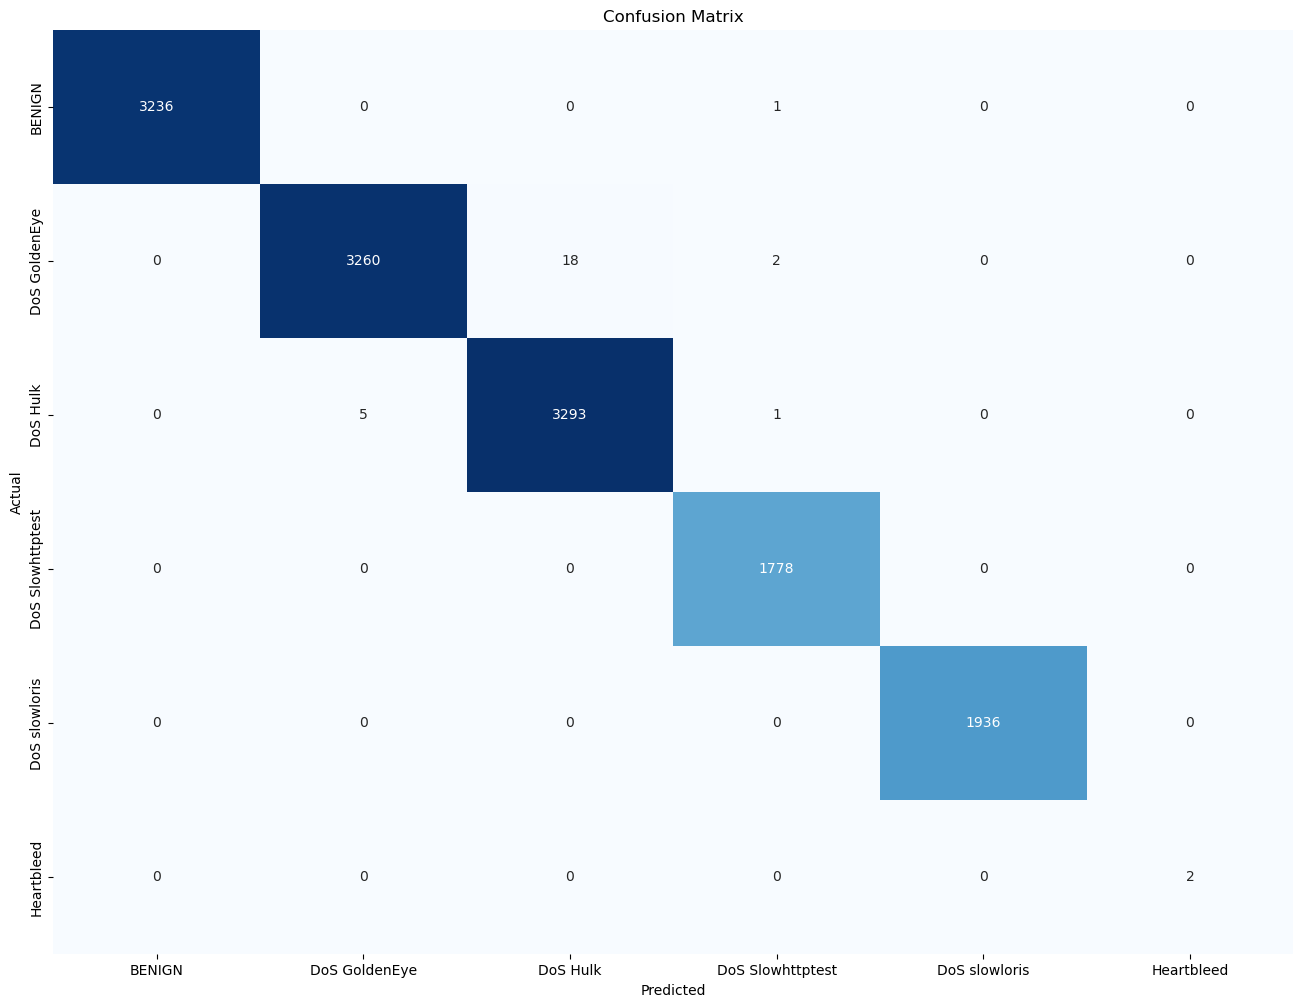

,precision,recall,f1-score,support
BENIGN,1.000000,0.999691,0.999846,3237.000000
DoS GoldenEye,0.998469,0.993902,0.996180,3280.000000
DoS Hulk,0.994564,0.998181,0.996369,3299.000000
DoS Slowhttptest,0.997755,1.000000,0.998876,1778.000000
DoS slowloris,1.000000,1.000000,1.000000,1936.000000
Heartbleed,1.000000,1.000000,1.000000,2.000000
accuracy,0.998005,0.998005,0.998005,0.998005
macro avg,0.998465,0.998629,0.998545,13532.000000
weighted avg,0.998009,0.998005,0.998004,13532.000000


Epoch 0 validation: Cross-entropy=0.34, Accuracy=91.6%
Epoch 1 validation: Cross-entropy=0.20, Accuracy=93.6%
Epoch 2 validation: Cross-entropy=0.14, Accuracy=94.5%
Epoch 3 validation: Cross-entropy=0.12, Accuracy=94.5%
Epoch 4 validation: Cross-entropy=0.10, Accuracy=96.0%
Epoch 5 validation: Cross-entropy=0.09, Accuracy=96.4%
Epoch 6 validation: Cross-entropy=0.08, Accuracy=96.6%
Epoch 7 validation: Cross-entropy=0.08, Accuracy=96.8%
Epoch 8 validation: Cross-entropy=0.07, Accuracy=96.9%
Epoch 9 validation: Cross-entropy=0.07, Accuracy=97.0%
Epoch 10 validation: Cross-entropy=0.06, Accuracy=97.1%
Epoch 11 validation: Cross-entropy=0.06, Accuracy=97.3%
Epoch 12 validation: Cross-entropy=0.05, Accuracy=98.1%
Epoch 13 validation: Cross-entropy=0.05, Accuracy=98.3%
Epoch 14 validation: Cross-entropy=0.05, Accuracy=98.6%
Epoch 15 validation: Cross-entropy=0.05, Accuracy=98.6%
Epoch 16 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 17 validation: Cross-entropy=0.04, Accuracy=99.0%
Ep

Epoch 156 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 157 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 158 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 159 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 160 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 161 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 162 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 163 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 164 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 165 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 166 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 167 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 168 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 169 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 170 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 171 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 172 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 173 validation: Cross-ent

Epoch 312 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 313 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 314 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 315 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 316 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 317 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 318 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 319 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 320 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 321 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 322 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 323 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 324 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 325 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 326 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 327 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 328 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 329 validation: Cross-ent

Epoch 468 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 469 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 470 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 471 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 472 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 473 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 474 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 475 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 476 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 477 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 478 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 479 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 480 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 481 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 482 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 483 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 484 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 485 validation: Cross-ent

Epoch 624 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 625 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 626 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 627 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 628 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 629 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 630 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 631 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 632 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 633 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 634 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 635 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 636 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 637 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 638 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 639 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 640 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 641 validation: Cross-ent

Epoch 780 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 781 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 782 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 783 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 784 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 785 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 786 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 787 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 788 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 789 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 790 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 791 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 792 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 793 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 794 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 795 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 796 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 797 validation: Cross-ent

Epoch 936 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 937 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 938 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 939 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 940 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 941 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 942 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 943 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 944 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 945 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 946 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 947 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 948 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 949 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 950 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 951 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 952 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 953 validation: Cross-en

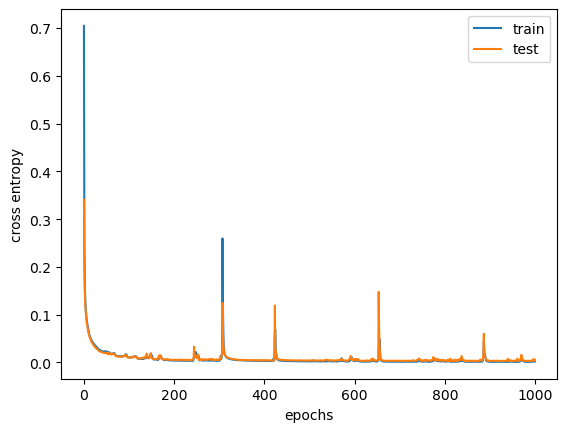

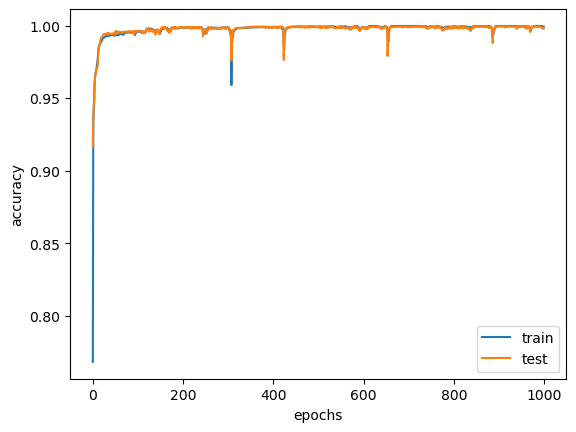

/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.draw()
/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


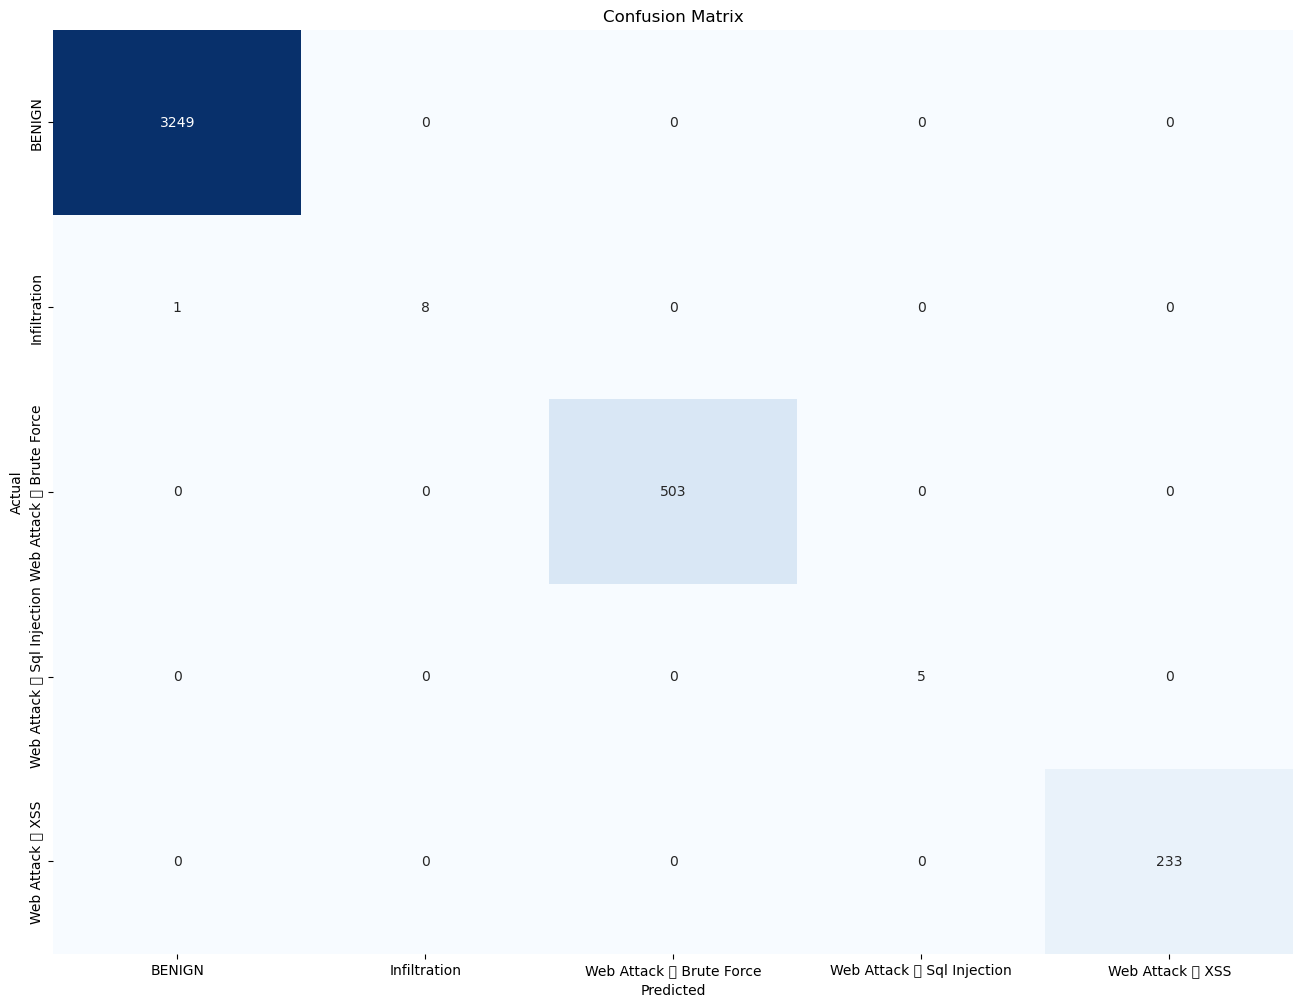

,precision,recall,f1-score,support
BENIGN,0.999692,1.000000,0.999846,3249.00000
Infiltration,1.000000,0.888889,0.941176,9.00000
Web Attack  Brute Force,1.000000,1.000000,1.000000,503.00000
Web Attack  Sql Injection,1.000000,1.000000,1.000000,5.00000
Web Attack  XSS,1.000000,1.000000,1.000000,233.00000
accuracy,0.999750,0.999750,0.999750,0.99975
macro avg,0.999938,0.977778,0.988205,3999.00000
weighted avg,0.999750,0.999750,0.999743,3999.00000


In [28]:
# Tuesday
freezed_Tue = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Tue.hidden1.parameters():
    param.requires_grad = False
for param in freezed_Tue.hidden2.parameters():
    param.requires_grad = False
freezed_Tue.output = nn.Linear(500, len(Tue.categories_as_list)).to(DEVICE)
training_model(model=freezed_Tue, train_test=Tue, n_epochs=1000)

# Wendsday
freezed_Wed = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Wed.hidden1.parameters():
    param.requires_grad = False
for param in freezed_Wed.hidden2.parameters():
    param.requires_grad = False
freezed_Wed.output = nn.Linear(500, len(Wed.categories_as_list)).to(DEVICE)
training_model(model=freezed_Wed, train_test=Wed, n_epochs=1000)

# Thursday
freezed_Thu = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Thu.hidden1.parameters():
    param.requires_grad = False
for param in freezed_Thu.hidden2.parameters():
    param.requires_grad = False
freezed_Thu.output = nn.Linear(500, len(Thu.categories_as_list)).to(DEVICE)
training_model(model=freezed_Thu, train_test=Thu, n_epochs=1000)

### 凍結模型 1 層

Epoch 0 validation: Cross-entropy=0.59, Accuracy=66.5%
Epoch 1 validation: Cross-entropy=0.36, Accuracy=87.3%
Epoch 2 validation: Cross-entropy=0.18, Accuracy=98.2%
Epoch 3 validation: Cross-entropy=0.10, Accuracy=98.8%
Epoch 4 validation: Cross-entropy=0.07, Accuracy=99.0%
Epoch 5 validation: Cross-entropy=0.06, Accuracy=99.2%
Epoch 6 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 7 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 8 validation: Cross-entropy=0.04, Accuracy=99.3%
Epoch 9 validation: Cross-entropy=0.04, Accuracy=99.3%
Epoch 10 validation: Cross-entropy=0.08, Accuracy=99.2%
Epoch 11 validation: Cross-entropy=0.05, Accuracy=99.2%
Epoch 12 validation: Cross-entropy=0.04, Accuracy=99.4%
Epoch 13 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 14 validation: Cross-entropy=0.04, Accuracy=99.3%
Epoch 15 validation: Cross-entropy=0.04, Accuracy=99.4%
Epoch 16 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 17 validation: Cross-entropy=0.04, Accuracy=99.0%
Ep

Epoch 150 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 151 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 152 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 153 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 154 validation: Cross-entropy=1.11, Accuracy=58.7%
Epoch 155 validation: Cross-entropy=0.13, Accuracy=97.5%
Epoch 156 validation: Cross-entropy=0.04, Accuracy=99.4%
Epoch 157 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 158 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 159 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 160 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 161 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 162 validation: Cross-entropy=0.03, Accuracy=99.0%
Epoch 163 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 164 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 165 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 166 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 167 validation: Cross-ent

Epoch 294 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 295 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 296 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 297 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 298 validation: Cross-entropy=0.02, Accuracy=99.1%
Epoch 299 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 300 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 301 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 302 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 303 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 304 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 305 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 306 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 307 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 308 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 309 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 310 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 311 validation: Cross-ent

Epoch 438 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 439 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 440 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 441 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 442 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 443 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 444 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 445 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 446 validation: Cross-entropy=0.03, Accuracy=99.3%
Epoch 447 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 448 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 449 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 450 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 451 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 452 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 453 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 454 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 455 validation: Cross-ent

Epoch 582 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 583 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 584 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 585 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 586 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 587 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 588 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 589 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 590 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 591 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 592 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 593 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 594 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 595 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 596 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 597 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 598 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 599 valid

Epoch 726 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 727 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 728 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 729 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 730 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 731 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 732 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 733 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 734 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 735 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 736 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 737 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 738 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 739 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 740 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 741 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 742 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 743 vali

Epoch 870 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 871 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 872 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 873 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 874 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 875 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 876 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 877 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 878 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 879 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 880 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 881 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 882 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 883 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 884 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 885 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 886 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 887 vali

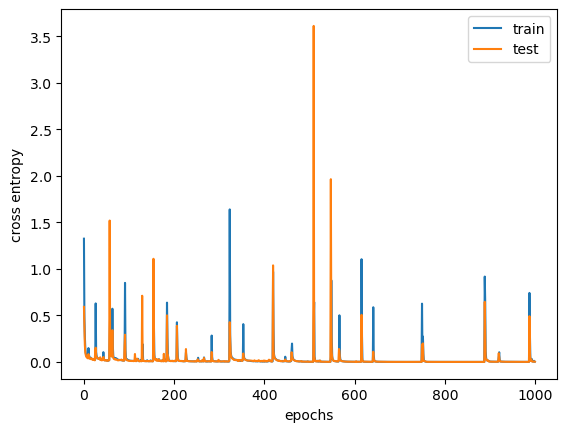

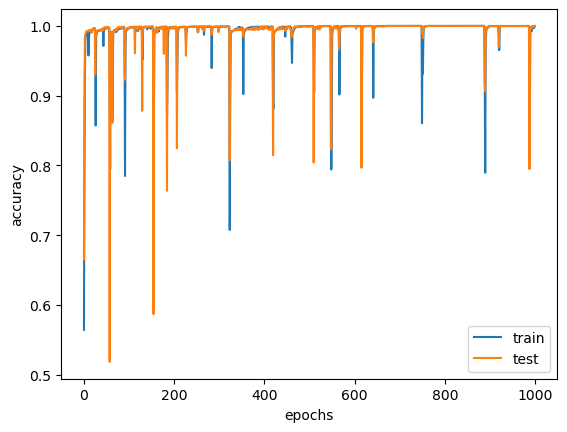

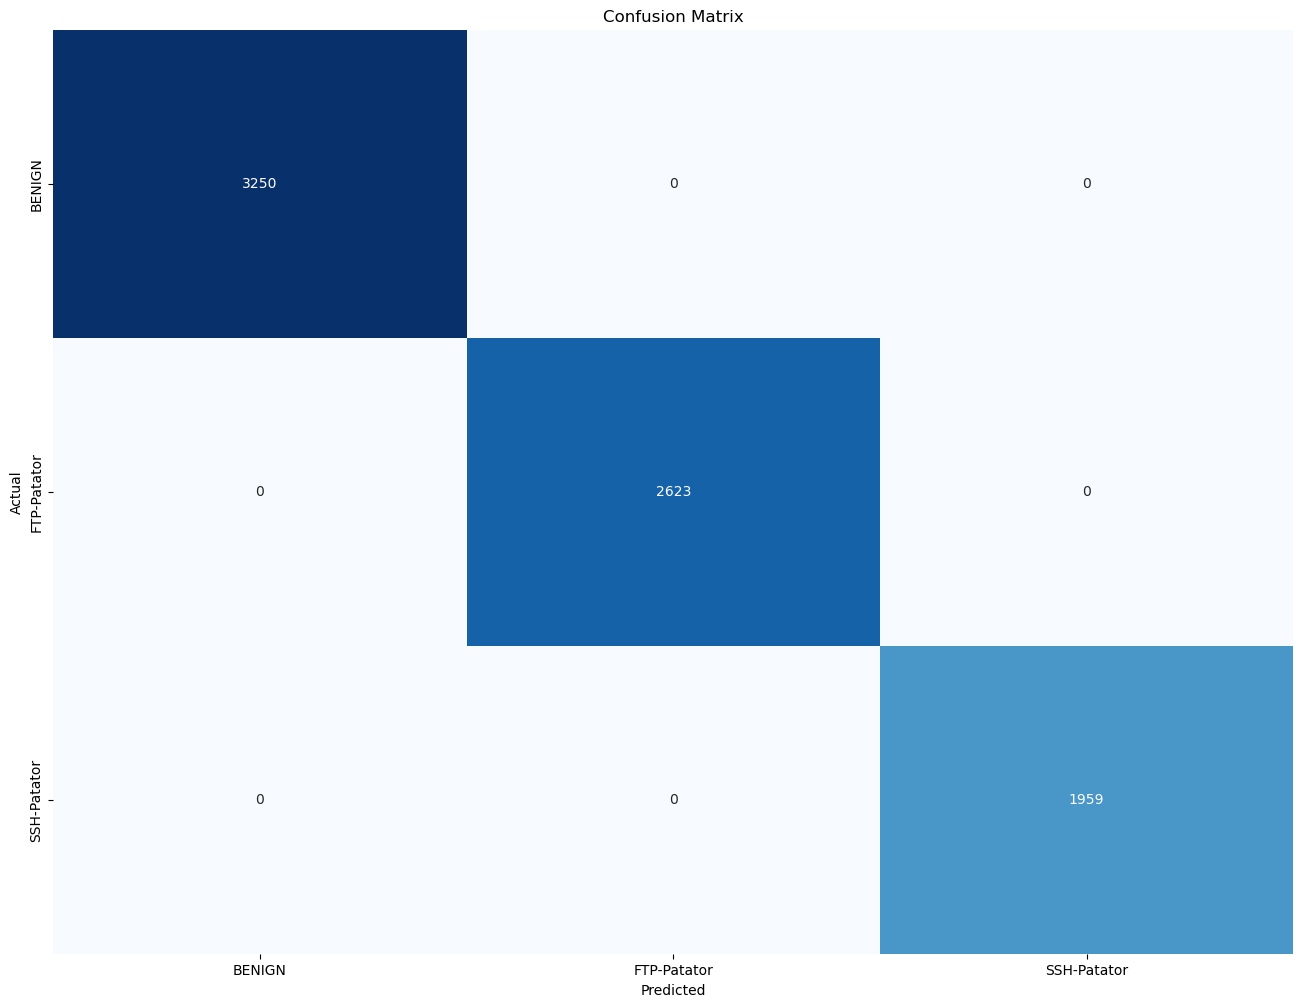

,precision,recall,f1-score,support
BENIGN,1.0,1.0,1.0,3250.0
FTP-Patator,1.0,1.0,1.0,2623.0
SSH-Patator,1.0,1.0,1.0,1959.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,7832.0
weighted avg,1.0,1.0,1.0,7832.0


Epoch 0 validation: Cross-entropy=1.14, Accuracy=49.1%
Epoch 1 validation: Cross-entropy=0.95, Accuracy=66.6%
Epoch 2 validation: Cross-entropy=0.80, Accuracy=68.5%
Epoch 3 validation: Cross-entropy=0.68, Accuracy=76.2%
Epoch 4 validation: Cross-entropy=0.51, Accuracy=82.9%
Epoch 5 validation: Cross-entropy=0.47, Accuracy=86.1%
Epoch 6 validation: Cross-entropy=0.37, Accuracy=93.2%
Epoch 7 validation: Cross-entropy=0.40, Accuracy=84.2%
Epoch 8 validation: Cross-entropy=0.41, Accuracy=83.7%
Epoch 9 validation: Cross-entropy=0.70, Accuracy=75.4%
Epoch 10 validation: Cross-entropy=0.21, Accuracy=94.3%
Epoch 11 validation: Cross-entropy=0.20, Accuracy=93.5%
Epoch 12 validation: Cross-entropy=0.22, Accuracy=93.5%
Epoch 13 validation: Cross-entropy=0.16, Accuracy=94.6%
Epoch 14 validation: Cross-entropy=0.19, Accuracy=94.5%
Epoch 15 validation: Cross-entropy=0.21, Accuracy=93.6%
Epoch 16 validation: Cross-entropy=0.15, Accuracy=94.8%
Epoch 17 validation: Cross-entropy=0.15, Accuracy=95.2%
Ep

Epoch 148 validation: Cross-entropy=0.06, Accuracy=97.4%
Epoch 149 validation: Cross-entropy=0.06, Accuracy=97.4%
Epoch 150 validation: Cross-entropy=0.06, Accuracy=97.4%
Epoch 151 validation: Cross-entropy=0.06, Accuracy=97.1%
Epoch 152 validation: Cross-entropy=0.06, Accuracy=97.3%
Epoch 153 validation: Cross-entropy=0.07, Accuracy=97.0%
Epoch 154 validation: Cross-entropy=0.06, Accuracy=97.2%
Epoch 155 validation: Cross-entropy=0.08, Accuracy=97.1%
Epoch 156 validation: Cross-entropy=0.05, Accuracy=97.5%
Epoch 157 validation: Cross-entropy=0.06, Accuracy=97.3%
Epoch 158 validation: Cross-entropy=0.08, Accuracy=96.9%
Epoch 159 validation: Cross-entropy=0.36, Accuracy=83.1%
Epoch 160 validation: Cross-entropy=0.24, Accuracy=94.7%
Epoch 161 validation: Cross-entropy=0.12, Accuracy=96.4%
Epoch 162 validation: Cross-entropy=0.09, Accuracy=96.9%
Epoch 163 validation: Cross-entropy=0.08, Accuracy=96.9%
Epoch 164 validation: Cross-entropy=0.06, Accuracy=97.4%
Epoch 165 validation: Cross-ent

Epoch 292 validation: Cross-entropy=0.04, Accuracy=98.9%
Epoch 293 validation: Cross-entropy=0.04, Accuracy=98.6%
Epoch 294 validation: Cross-entropy=0.05, Accuracy=97.9%
Epoch 295 validation: Cross-entropy=0.05, Accuracy=97.8%
Epoch 296 validation: Cross-entropy=0.04, Accuracy=98.3%
Epoch 297 validation: Cross-entropy=0.03, Accuracy=98.7%
Epoch 298 validation: Cross-entropy=0.03, Accuracy=98.8%
Epoch 299 validation: Cross-entropy=0.03, Accuracy=98.7%
Epoch 300 validation: Cross-entropy=0.03, Accuracy=98.7%
Epoch 301 validation: Cross-entropy=0.03, Accuracy=98.7%
Epoch 302 validation: Cross-entropy=0.03, Accuracy=99.0%
Epoch 303 validation: Cross-entropy=0.03, Accuracy=98.6%
Epoch 304 validation: Cross-entropy=0.04, Accuracy=98.4%
Epoch 305 validation: Cross-entropy=0.03, Accuracy=98.7%
Epoch 306 validation: Cross-entropy=0.06, Accuracy=97.9%
Epoch 307 validation: Cross-entropy=0.05, Accuracy=97.7%
Epoch 308 validation: Cross-entropy=0.03, Accuracy=98.4%
Epoch 309 validation: Cross-ent

Epoch 436 validation: Cross-entropy=0.03, Accuracy=98.8%
Epoch 437 validation: Cross-entropy=0.03, Accuracy=98.7%
Epoch 438 validation: Cross-entropy=0.03, Accuracy=98.8%
Epoch 439 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 440 validation: Cross-entropy=0.03, Accuracy=99.0%
Epoch 441 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 442 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 443 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 444 validation: Cross-entropy=0.03, Accuracy=99.0%
Epoch 445 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 446 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 447 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 448 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 449 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 450 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 451 validation: Cross-entropy=0.03, Accuracy=98.8%
Epoch 452 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 453 validation: Cross-ent

Epoch 580 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 581 validation: Cross-entropy=0.03, Accuracy=99.0%
Epoch 582 validation: Cross-entropy=0.03, Accuracy=99.0%
Epoch 583 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 584 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 585 validation: Cross-entropy=0.03, Accuracy=99.0%
Epoch 586 validation: Cross-entropy=0.03, Accuracy=98.8%
Epoch 587 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 588 validation: Cross-entropy=0.03, Accuracy=98.7%
Epoch 589 validation: Cross-entropy=0.03, Accuracy=98.8%
Epoch 590 validation: Cross-entropy=0.03, Accuracy=98.7%
Epoch 591 validation: Cross-entropy=0.03, Accuracy=99.0%
Epoch 592 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 593 validation: Cross-entropy=0.03, Accuracy=98.8%
Epoch 594 validation: Cross-entropy=0.03, Accuracy=98.7%
Epoch 595 validation: Cross-entropy=0.03, Accuracy=98.8%
Epoch 596 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 597 validation: Cross-ent

Epoch 724 validation: Cross-entropy=0.82, Accuracy=76.5%
Epoch 725 validation: Cross-entropy=0.25, Accuracy=86.4%
Epoch 726 validation: Cross-entropy=0.15, Accuracy=95.7%
Epoch 727 validation: Cross-entropy=0.07, Accuracy=98.4%
Epoch 728 validation: Cross-entropy=0.05, Accuracy=98.3%
Epoch 729 validation: Cross-entropy=0.04, Accuracy=98.7%
Epoch 730 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 731 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 732 validation: Cross-entropy=0.03, Accuracy=99.0%
Epoch 733 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 734 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 735 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 736 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 737 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 738 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 739 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 740 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 741 validation: Cross-ent

Epoch 868 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 869 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 870 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 871 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 872 validation: Cross-entropy=0.03, Accuracy=98.6%
Epoch 873 validation: Cross-entropy=0.03, Accuracy=99.0%
Epoch 874 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 875 validation: Cross-entropy=0.03, Accuracy=98.9%
Epoch 876 validation: Cross-entropy=0.03, Accuracy=98.8%
Epoch 877 validation: Cross-entropy=0.24, Accuracy=91.5%
Epoch 878 validation: Cross-entropy=0.15, Accuracy=93.6%
Epoch 879 validation: Cross-entropy=0.10, Accuracy=96.4%
Epoch 880 validation: Cross-entropy=0.08, Accuracy=97.2%
Epoch 881 validation: Cross-entropy=0.06, Accuracy=97.9%
Epoch 882 validation: Cross-entropy=0.06, Accuracy=98.0%
Epoch 883 validation: Cross-entropy=0.05, Accuracy=98.3%
Epoch 884 validation: Cross-entropy=0.04, Accuracy=98.3%
Epoch 885 validation: Cross-ent

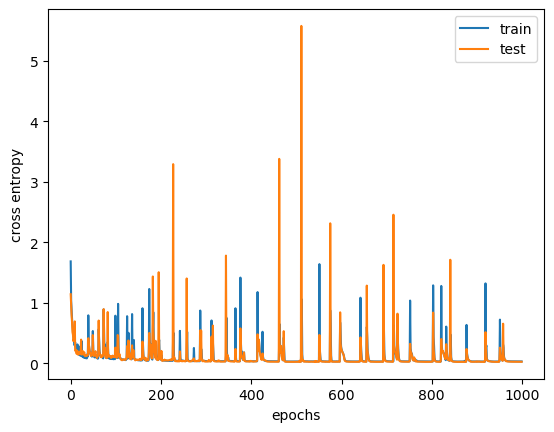

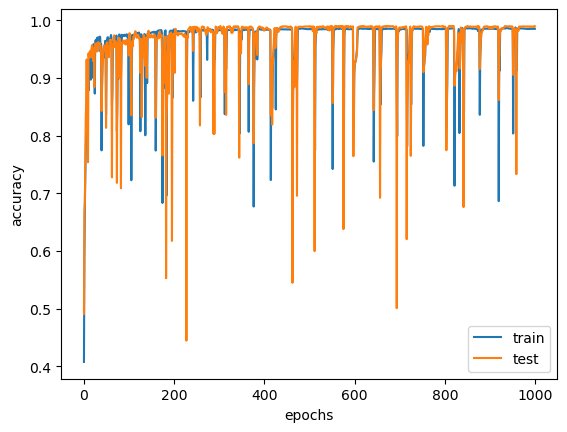

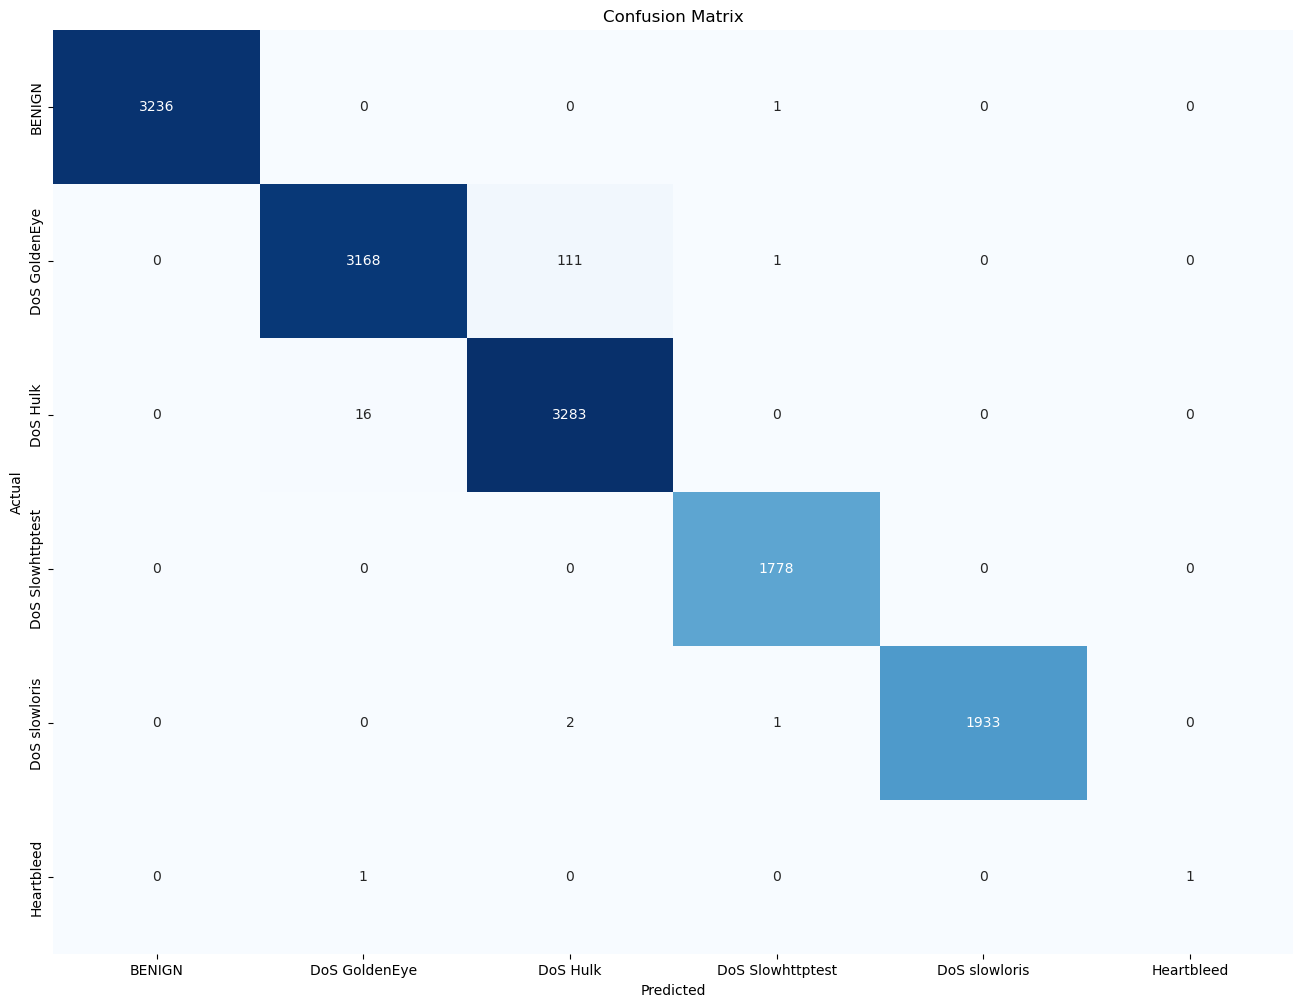

,precision,recall,f1-score,support
BENIGN,1.000000,0.999691,0.999846,3237.000000
DoS GoldenEye,0.994662,0.965854,0.980046,3280.000000
DoS Hulk,0.966726,0.995150,0.980732,3299.000000
DoS Slowhttptest,0.998316,1.000000,0.999157,1778.000000
DoS slowloris,1.000000,0.998450,0.999225,1936.000000
Heartbleed,1.000000,0.500000,0.666667,2.000000
accuracy,0.990171,0.990171,0.990171,0.990171
macro avg,0.993284,0.909858,0.937612,13532.000000
weighted avg,0.990373,0.990171,0.990158,13532.000000


Epoch 0 validation: Cross-entropy=0.38, Accuracy=87.5%
Epoch 1 validation: Cross-entropy=0.28, Accuracy=93.3%
Epoch 2 validation: Cross-entropy=0.22, Accuracy=93.2%
Epoch 3 validation: Cross-entropy=0.20, Accuracy=93.1%
Epoch 4 validation: Cross-entropy=0.18, Accuracy=93.5%
Epoch 5 validation: Cross-entropy=0.15, Accuracy=94.2%
Epoch 6 validation: Cross-entropy=0.15, Accuracy=95.4%
Epoch 7 validation: Cross-entropy=0.13, Accuracy=95.8%
Epoch 8 validation: Cross-entropy=0.12, Accuracy=95.8%
Epoch 9 validation: Cross-entropy=0.11, Accuracy=96.3%
Epoch 10 validation: Cross-entropy=0.10, Accuracy=96.5%
Epoch 11 validation: Cross-entropy=0.09, Accuracy=96.7%
Epoch 12 validation: Cross-entropy=0.08, Accuracy=96.8%
Epoch 13 validation: Cross-entropy=0.07, Accuracy=96.9%
Epoch 14 validation: Cross-entropy=0.07, Accuracy=97.3%
Epoch 15 validation: Cross-entropy=0.06, Accuracy=98.2%
Epoch 16 validation: Cross-entropy=0.06, Accuracy=98.6%
Epoch 17 validation: Cross-entropy=0.06, Accuracy=98.7%
Ep

Epoch 156 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 157 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 158 validation: Cross-entropy=0.02, Accuracy=99.4%
Epoch 159 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 160 validation: Cross-entropy=0.02, Accuracy=99.4%
Epoch 161 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 162 validation: Cross-entropy=0.02, Accuracy=99.3%
Epoch 163 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 164 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 165 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 166 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 167 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 168 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 169 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 170 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 171 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 172 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 173 validation: Cross-ent

Epoch 300 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 301 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 302 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 303 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 304 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 305 validation: Cross-entropy=0.03, Accuracy=99.2%
Epoch 306 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 307 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 308 validation: Cross-entropy=0.03, Accuracy=99.3%
Epoch 309 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 310 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 311 validation: Cross-entropy=0.07, Accuracy=98.0%
Epoch 312 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 313 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 314 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 315 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 316 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 317 validation: Cross-ent

Epoch 444 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 445 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 446 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 447 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 448 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 449 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 450 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 451 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 452 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 453 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 454 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 455 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 456 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 457 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 458 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 459 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 460 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 461 validation: Cross-ent

Epoch 588 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 589 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 590 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 591 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 592 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 593 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 594 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 595 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 596 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 597 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 598 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 599 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 600 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 601 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 602 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 603 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 604 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 605 validation: Cross-ent

Epoch 732 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 733 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 734 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 735 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 736 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 737 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 738 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 739 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 740 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 741 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 742 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 743 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 744 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 745 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 746 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 747 validation: Cross-entropy=0.02, Accuracy=99.4%
Epoch 748 validation: Cross-entropy=0.03, Accuracy=98.2%
Epoch 749 validation: Cross-ent

Epoch 876 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 877 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 878 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 879 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 880 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 881 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 882 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 883 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 884 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 885 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 886 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 887 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 888 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 889 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 890 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 891 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 892 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 893 validation: Cross-ent

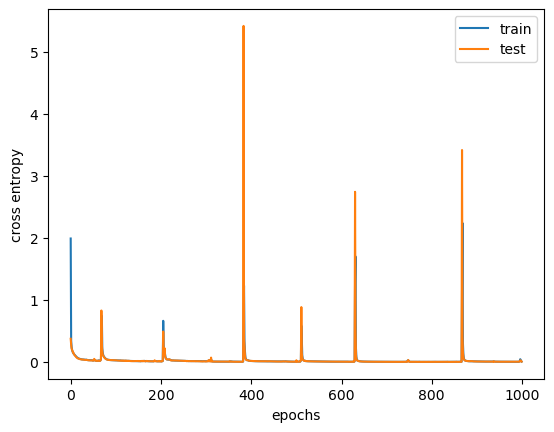

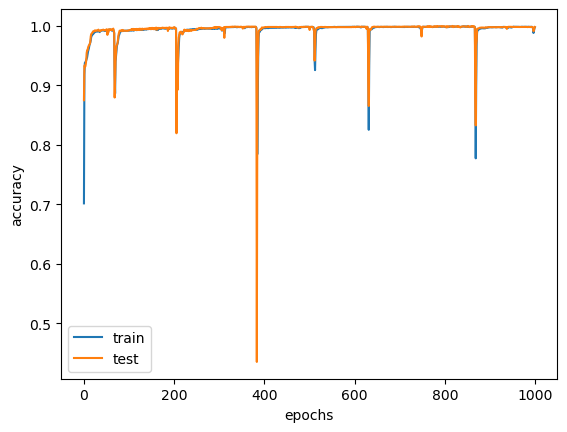

/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.draw()
/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


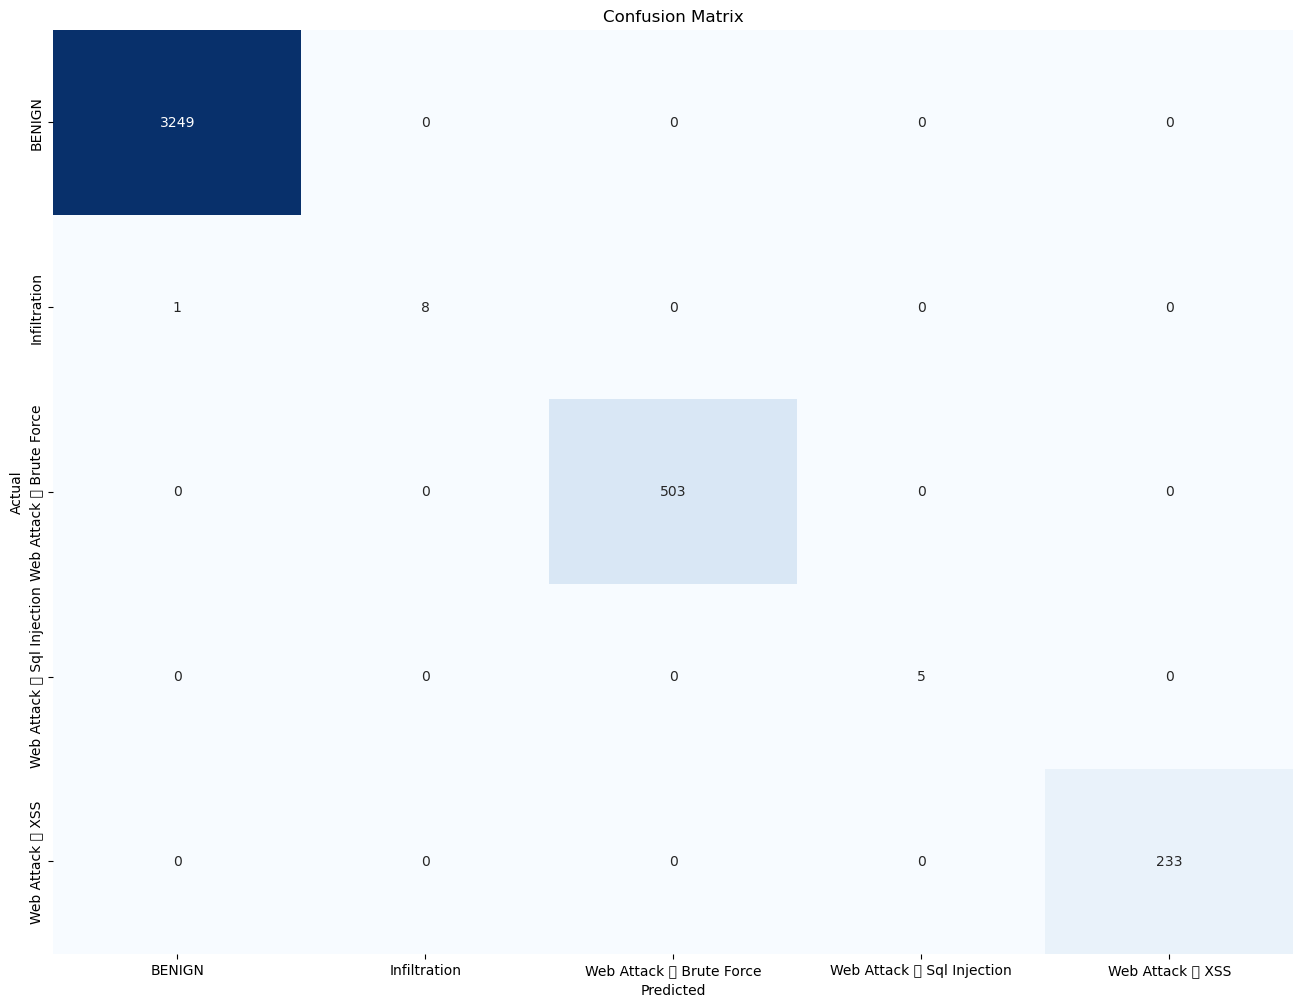

,precision,recall,f1-score,support
BENIGN,0.999692,1.000000,0.999846,3249.00000
Infiltration,1.000000,0.888889,0.941176,9.00000
Web Attack  Brute Force,1.000000,1.000000,1.000000,503.00000
Web Attack  Sql Injection,1.000000,1.000000,1.000000,5.00000
Web Attack  XSS,1.000000,1.000000,1.000000,233.00000
accuracy,0.999750,0.999750,0.999750,0.99975
macro avg,0.999938,0.977778,0.988205,3999.00000
weighted avg,0.999750,0.999750,0.999743,3999.00000


In [29]:
# Tuesday
freezed_Tue = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Tue.hidden1.parameters():
    param.requires_grad = False
freezed_Tue.output = nn.Linear(500, len(Tue.categories_as_list)).to(DEVICE)
training_model(model=freezed_Tue, train_test=Tue, n_epochs=1000)

# Wendsday
freezed_Wed = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Wed.hidden1.parameters():
    param.requires_grad = False
freezed_Wed.output = nn.Linear(500, len(Wed.categories_as_list)).to(DEVICE)
training_model(model=freezed_Wed, train_test=Wed, n_epochs=1000)

# Thursday
freezed_Thu = copy.deepcopy(dnn_Mon_and_Fri)
for param in freezed_Thu.hidden1.parameters():
    param.requires_grad = False
freezed_Thu.output = nn.Linear(500, len(Thu.categories_as_list)).to(DEVICE)
training_model(model=freezed_Thu, train_test=Thu, n_epochs=1000)

### 模型全解凍

Epoch 0 validation: Cross-entropy=0.48, Accuracy=81.6%
Epoch 1 validation: Cross-entropy=0.26, Accuracy=96.2%
Epoch 2 validation: Cross-entropy=0.13, Accuracy=98.6%
Epoch 3 validation: Cross-entropy=0.08, Accuracy=99.0%
Epoch 4 validation: Cross-entropy=0.06, Accuracy=99.2%
Epoch 5 validation: Cross-entropy=0.05, Accuracy=99.1%
Epoch 6 validation: Cross-entropy=0.04, Accuracy=99.2%
Epoch 7 validation: Cross-entropy=0.04, Accuracy=99.2%
Epoch 8 validation: Cross-entropy=0.04, Accuracy=99.1%
Epoch 9 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 10 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 11 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 12 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 13 validation: Cross-entropy=0.02, Accuracy=99.4%
Epoch 14 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 15 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 16 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 17 validation: Cross-entropy=0.57, Accuracy=81.8%
Ep

Epoch 149 validation: Cross-entropy=0.14, Accuracy=96.9%
Epoch 150 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 151 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 152 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 153 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 154 validation: Cross-entropy=0.54, Accuracy=80.3%
Epoch 155 validation: Cross-entropy=0.09, Accuracy=98.8%
Epoch 156 validation: Cross-entropy=0.04, Accuracy=99.3%
Epoch 157 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 158 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 159 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 160 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 161 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 162 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 163 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 164 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 165 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 166 validation: Cross-ent

Epoch 293 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 294 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 295 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 296 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 297 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 298 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 299 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 300 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 301 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 302 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 303 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 304 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 305 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 306 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 307 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 308 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 309 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 310 validation: Cross-ent

Epoch 436 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 437 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 438 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 439 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 440 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 441 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 442 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 443 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 444 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 445 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 446 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 447 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 448 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 449 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 450 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 451 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 452 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 453 validation: Cross-ent

Epoch 580 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 581 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 582 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 583 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 584 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 585 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 586 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 587 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 588 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 589 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 590 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 591 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 592 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 593 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 594 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 595 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 596 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 597 vali

Epoch 724 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 725 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 726 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 727 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 728 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 729 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 730 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 731 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 732 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 733 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 734 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 735 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 736 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 737 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 738 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 739 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 740 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 741 vali

Epoch 868 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 869 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 870 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 871 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 872 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 873 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 874 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 875 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 876 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 877 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 878 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 879 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 880 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 881 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 882 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 883 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 884 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 885 vali

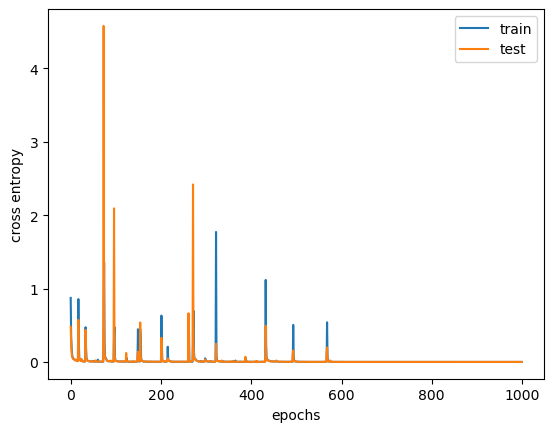

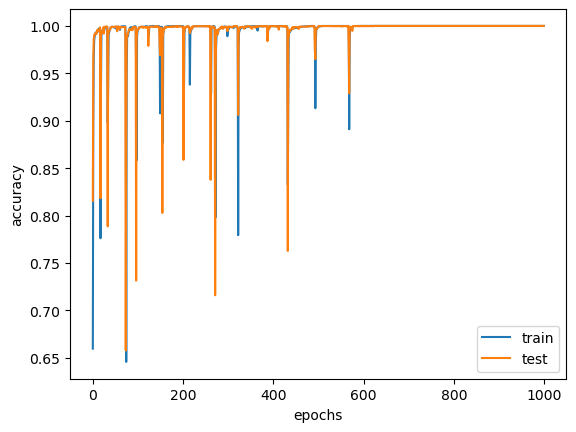

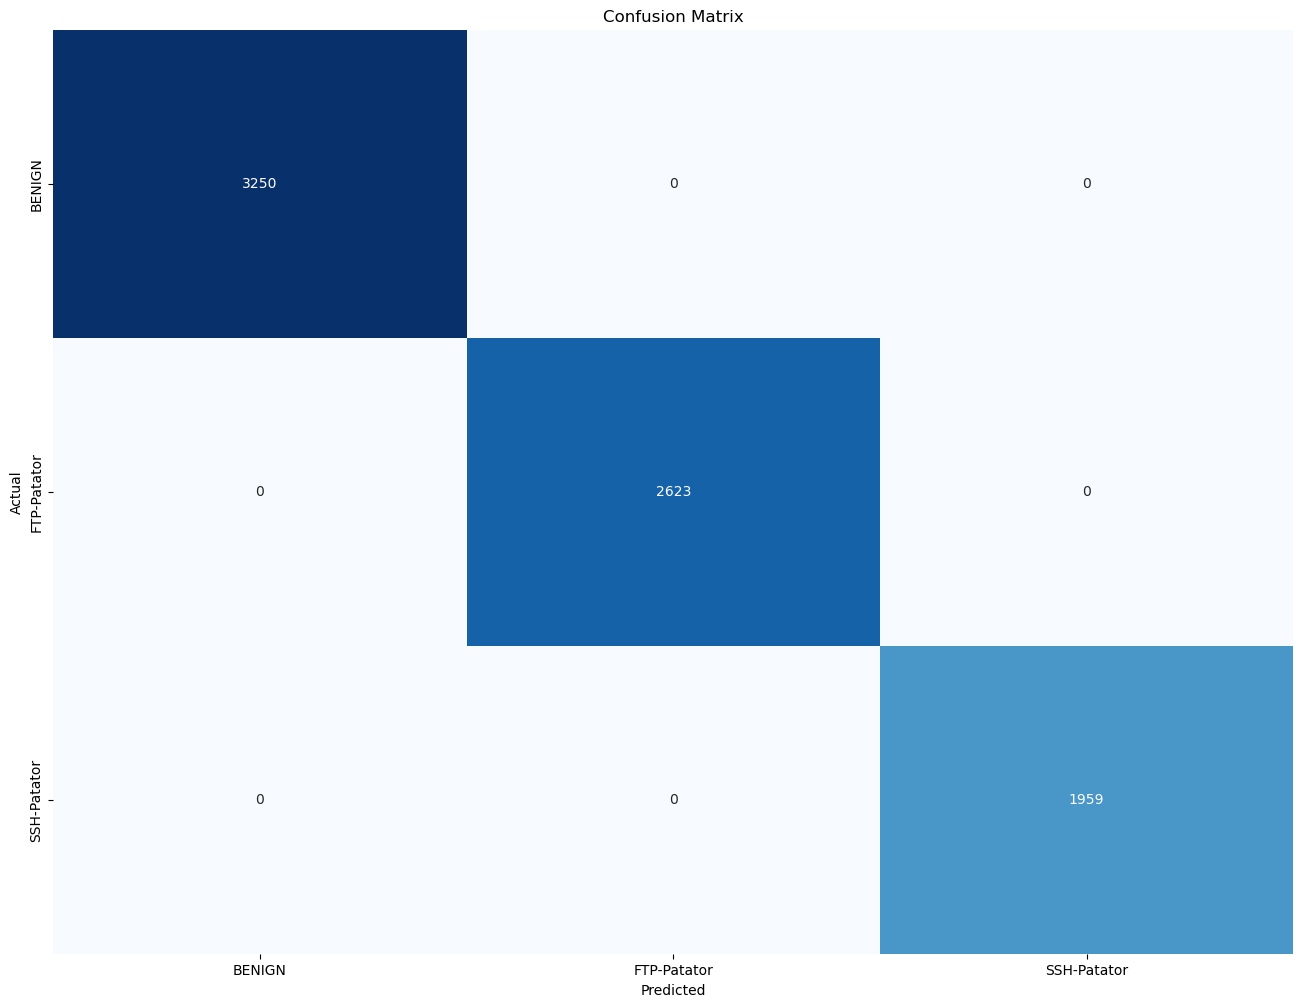

,precision,recall,f1-score,support
BENIGN,1.0,1.0,1.0,3250.0
FTP-Patator,1.0,1.0,1.0,2623.0
SSH-Patator,1.0,1.0,1.0,1959.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,7832.0
weighted avg,1.0,1.0,1.0,7832.0


Epoch 0 validation: Cross-entropy=1.12, Accuracy=57.7%
Epoch 1 validation: Cross-entropy=0.89, Accuracy=66.4%
Epoch 2 validation: Cross-entropy=0.71, Accuracy=71.1%
Epoch 3 validation: Cross-entropy=0.59, Accuracy=81.9%
Epoch 4 validation: Cross-entropy=0.51, Accuracy=83.5%
Epoch 5 validation: Cross-entropy=0.44, Accuracy=83.8%
Epoch 6 validation: Cross-entropy=0.41, Accuracy=83.6%
Epoch 7 validation: Cross-entropy=0.34, Accuracy=87.0%
Epoch 8 validation: Cross-entropy=0.30, Accuracy=92.3%
Epoch 9 validation: Cross-entropy=0.23, Accuracy=93.5%
Epoch 10 validation: Cross-entropy=0.19, Accuracy=95.0%
Epoch 11 validation: Cross-entropy=0.18, Accuracy=93.2%
Epoch 12 validation: Cross-entropy=0.17, Accuracy=95.0%
Epoch 13 validation: Cross-entropy=0.09, Accuracy=97.4%
Epoch 14 validation: Cross-entropy=0.08, Accuracy=97.0%
Epoch 15 validation: Cross-entropy=0.16, Accuracy=95.9%
Epoch 16 validation: Cross-entropy=0.07, Accuracy=97.4%
Epoch 17 validation: Cross-entropy=0.10, Accuracy=97.1%
Ep

Epoch 148 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 149 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 150 validation: Cross-entropy=0.07, Accuracy=97.3%
Epoch 151 validation: Cross-entropy=0.12, Accuracy=96.4%
Epoch 152 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 153 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 154 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 155 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 156 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 157 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 158 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 159 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 160 validation: Cross-entropy=0.02, Accuracy=98.9%
Epoch 161 validation: Cross-entropy=0.22, Accuracy=96.0%
Epoch 162 validation: Cross-entropy=0.05, Accuracy=97.8%
Epoch 163 validation: Cross-entropy=0.03, Accuracy=98.7%
Epoch 164 validation: Cross-entropy=0.05, Accuracy=97.5%
Epoch 165 validation: Cross-ent

Epoch 295 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 296 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 297 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 298 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 299 validation: Cross-entropy=0.14, Accuracy=95.4%
Epoch 300 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 301 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 302 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 303 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 304 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 305 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 306 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 307 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 308 validation: Cross-entropy=0.18, Accuracy=95.5%
Epoch 309 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 310 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 311 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 312 validation: Cross-ent

Epoch 442 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 443 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 444 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 445 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 446 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 447 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 448 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 449 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 450 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 451 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 452 validation: Cross-entropy=0.28, Accuracy=90.2%
Epoch 453 validation: Cross-entropy=0.09, Accuracy=98.4%
Epoch 454 validation: Cross-entropy=0.05, Accuracy=98.6%
Epoch 455 validation: Cross-entropy=0.03, Accuracy=99.1%
Epoch 456 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 457 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 458 validation: Cross-entropy=0.02, Accuracy=99.6%
Epoch 459 validation: Cross-

Epoch 586 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 587 validation: Cross-entropy=0.03, Accuracy=99.6%
Epoch 588 validation: Cross-entropy=0.01, Accuracy=99.9%
Epoch 589 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 590 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 591 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 592 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 593 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 594 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 595 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 596 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 597 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 598 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 599 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 600 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 601 validation: Cross-entropy=0.02, Accuracy=99.7%
Epoch 602 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 603 validation: C

Epoch 730 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 731 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 732 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 733 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 734 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 735 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 736 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 737 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 738 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 739 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 740 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 741 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 742 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 743 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 744 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 745 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 746 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 747 vali

Epoch 873 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 874 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 875 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 876 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 877 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 878 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 879 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 880 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 881 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 882 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 883 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 884 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 885 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 886 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 887 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 888 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 889 validation: Cross-entropy=0.00, Accuracy=100.0%
Epoch 890 vali

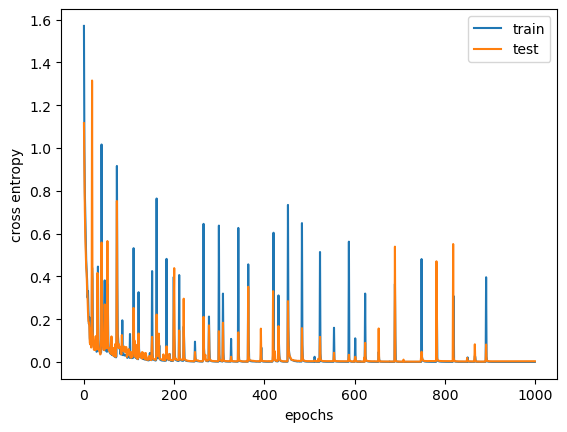

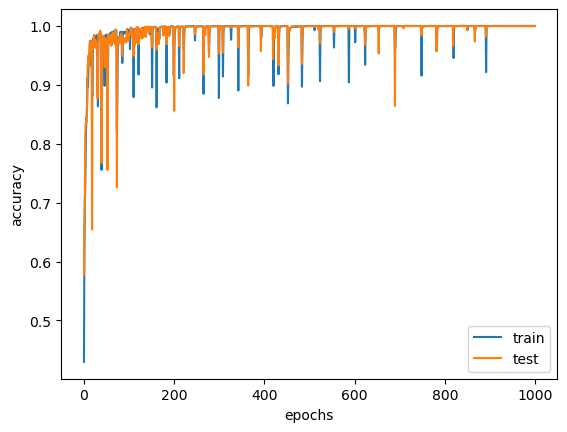

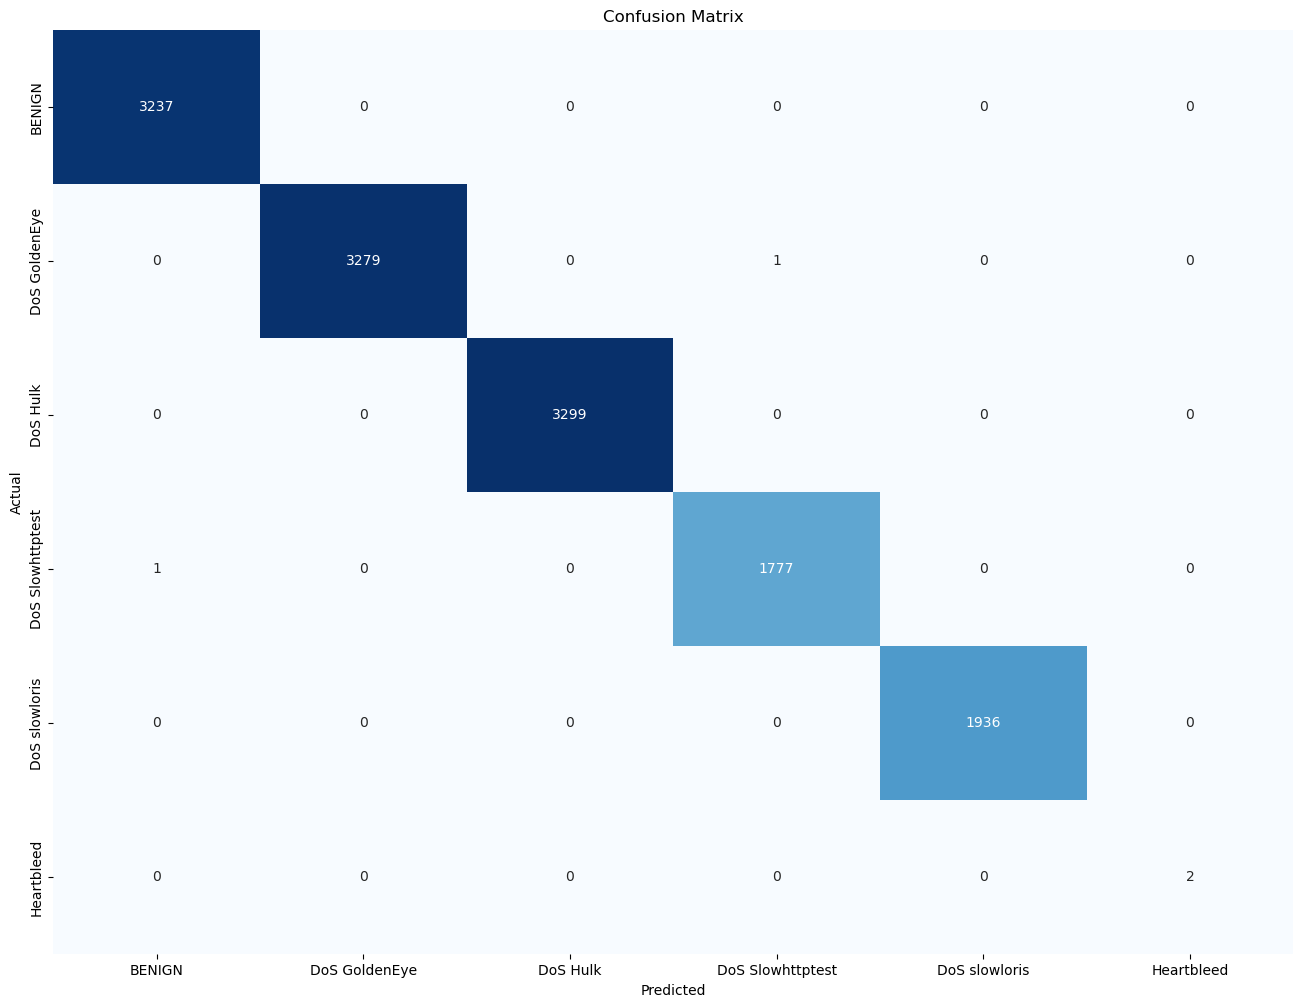

,precision,recall,f1-score,support
BENIGN,0.999691,1.000000,0.999846,3237.000000
DoS GoldenEye,1.000000,0.999695,0.999848,3280.000000
DoS Hulk,1.000000,1.000000,1.000000,3299.000000
DoS Slowhttptest,0.999438,0.999438,0.999438,1778.000000
DoS slowloris,1.000000,1.000000,1.000000,1936.000000
Heartbleed,1.000000,1.000000,1.000000,2.000000
accuracy,0.999852,0.999852,0.999852,0.999852
macro avg,0.999855,0.999855,0.999855,13532.000000
weighted avg,0.999852,0.999852,0.999852,13532.000000


Epoch 0 validation: Cross-entropy=0.48, Accuracy=86.2%
Epoch 1 validation: Cross-entropy=0.34, Accuracy=88.1%
Epoch 2 validation: Cross-entropy=0.25, Accuracy=93.6%
Epoch 3 validation: Cross-entropy=0.21, Accuracy=93.8%
Epoch 4 validation: Cross-entropy=0.19, Accuracy=93.6%
Epoch 5 validation: Cross-entropy=0.17, Accuracy=93.9%
Epoch 6 validation: Cross-entropy=0.15, Accuracy=95.0%
Epoch 7 validation: Cross-entropy=0.14, Accuracy=95.6%
Epoch 8 validation: Cross-entropy=0.13, Accuracy=96.3%
Epoch 9 validation: Cross-entropy=0.11, Accuracy=96.6%
Epoch 10 validation: Cross-entropy=0.10, Accuracy=96.7%
Epoch 11 validation: Cross-entropy=0.09, Accuracy=96.8%
Epoch 12 validation: Cross-entropy=0.08, Accuracy=97.0%
Epoch 13 validation: Cross-entropy=0.08, Accuracy=97.1%
Epoch 14 validation: Cross-entropy=0.07, Accuracy=97.2%
Epoch 15 validation: Cross-entropy=0.07, Accuracy=97.3%
Epoch 16 validation: Cross-entropy=0.06, Accuracy=97.8%
Epoch 17 validation: Cross-entropy=0.06, Accuracy=98.4%
Ep

Epoch 154 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 155 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 156 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 157 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 158 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 159 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 160 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 161 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 162 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 163 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 164 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 165 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 166 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 167 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 168 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 169 validation: Cross-entropy=0.01, Accuracy=99.5%
Epoch 170 validation: Cross-entropy=0.01, Accuracy=99.6%
Epoch 171 validation: Cross-ent

Epoch 308 validation: Cross-entropy=0.40, Accuracy=92.2%
Epoch 309 validation: Cross-entropy=0.14, Accuracy=93.8%
Epoch 310 validation: Cross-entropy=0.10, Accuracy=97.6%
Epoch 311 validation: Cross-entropy=0.08, Accuracy=97.7%
Epoch 312 validation: Cross-entropy=0.07, Accuracy=97.7%
Epoch 313 validation: Cross-entropy=0.06, Accuracy=97.7%
Epoch 314 validation: Cross-entropy=0.05, Accuracy=97.9%
Epoch 315 validation: Cross-entropy=0.04, Accuracy=99.4%
Epoch 316 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 317 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 318 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 319 validation: Cross-entropy=0.03, Accuracy=99.5%
Epoch 320 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 321 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 322 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 323 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 324 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 325 validation: Cross-ent

Epoch 462 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 463 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 464 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 465 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 466 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 467 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 468 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 469 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 470 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 471 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 472 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 473 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 474 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 475 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 476 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 477 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 478 validation: Cross-entropy=2.98, Accuracy=87.7%
Epoch 479 validation: Cross-ent

Epoch 616 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 617 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 618 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 619 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 620 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 621 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 622 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 623 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 624 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 625 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 626 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 627 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 628 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 629 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 630 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 631 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 632 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 633 validation: Cross-ent

Epoch 770 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 771 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 772 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 773 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 774 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 775 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 776 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 777 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 778 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 779 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 780 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 781 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 782 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 783 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 784 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 785 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 786 validation: Cross-entropy=0.01, Accuracy=99.8%
Epoch 787 validation: Cross-ent

Epoch 924 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 925 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 926 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 927 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 928 validation: Cross-entropy=0.00, Accuracy=99.8%
Epoch 929 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 930 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 931 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 932 validation: Cross-entropy=0.00, Accuracy=99.9%
Epoch 933 validation: Cross-entropy=0.01, Accuracy=99.7%
Epoch 934 validation: Cross-entropy=0.51, Accuracy=88.4%
Epoch 935 validation: Cross-entropy=0.15, Accuracy=97.3%
Epoch 936 validation: Cross-entropy=0.06, Accuracy=98.8%
Epoch 937 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 938 validation: Cross-entropy=0.03, Accuracy=99.4%
Epoch 939 validation: Cross-entropy=0.02, Accuracy=99.5%
Epoch 940 validation: Cross-entropy=0.02, Accuracy=99.4%
Epoch 941 validation: Cross-ent

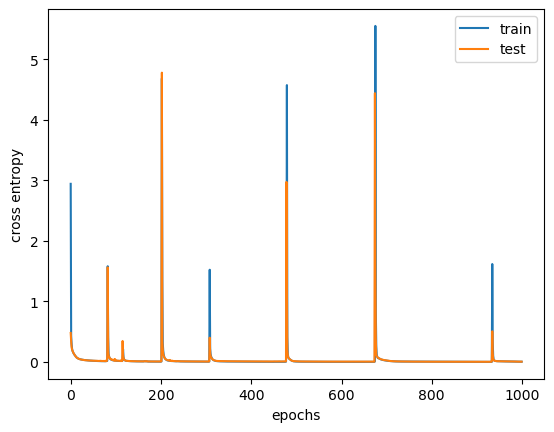

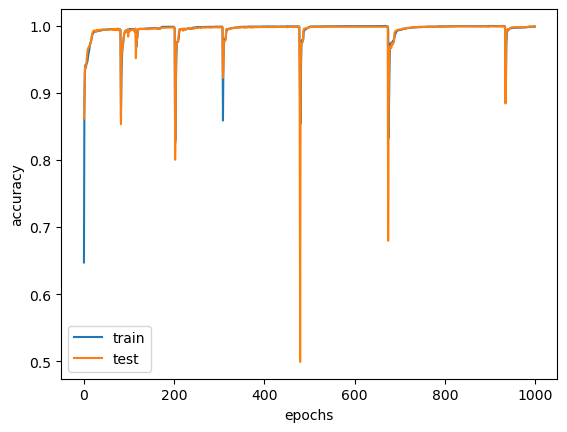

/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/seaborn/utils.py:80: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.draw()
/home/user/anaconda3/envs/linear/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 150 (\x96) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


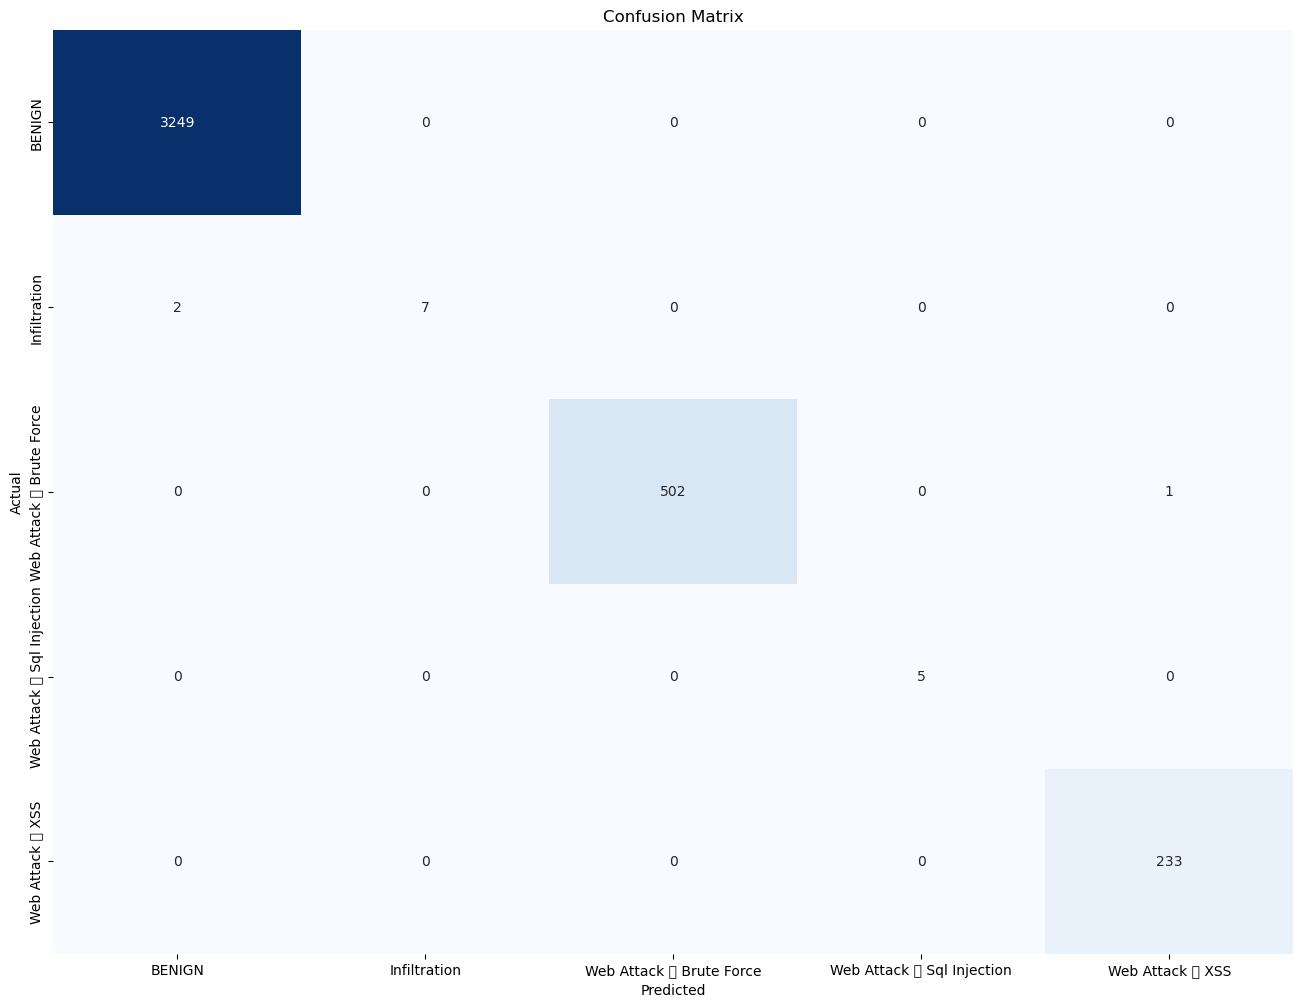

,precision,recall,f1-score,support
BENIGN,0.999385,1.000000,0.999692,3249.00000
Infiltration,1.000000,0.777778,0.875000,9.00000
Web Attack  Brute Force,1.000000,0.998012,0.999005,503.00000
Web Attack  Sql Injection,1.000000,1.000000,1.000000,5.00000
Web Attack  XSS,0.995726,1.000000,0.997859,233.00000
accuracy,0.999250,0.999250,0.999250,0.99925
macro avg,0.999022,0.955158,0.974311,3999.00000
weighted avg,0.999251,0.999250,0.999219,3999.00000


In [30]:
# Tuesday
freezed_Tue = copy.deepcopy(dnn_Mon_and_Fri)
freezed_Tue.output = nn.Linear(500, len(Tue.categories_as_list)).to(DEVICE)
training_model(model=freezed_Tue, train_test=Tue, n_epochs=1000)

# Wendsday
freezed_Wed = copy.deepcopy(dnn_Mon_and_Fri)
freezed_Wed.output = nn.Linear(500, len(Wed.categories_as_list)).to(DEVICE)
training_model(model=freezed_Wed, train_test=Wed, n_epochs=1000)

# Thursday
freezed_Thu = copy.deepcopy(dnn_Mon_and_Fri)
freezed_Thu.output = nn.Linear(500, len(Thu.categories_as_list)).to(DEVICE)
training_model(model=freezed_Thu, train_test=Thu, n_epochs=1000)